# Dependencies

In [6]:
import warnings
warnings.filterwarnings("ignore")

import operator
from functools import partial
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier

import csv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from keras.models import load_model
import random
import sys
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
    average_precision_score, precision_recall_curve
from sklearn import metrics
from pylab import mpl
from multiprocessing import Pool
import time
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from pandas import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import tensorflow as tf
import os
import copy
from keras.layers import BatchNormalization, Masking
from keras.layers import LSTM, Dropout, Bidirectional, TimeDistributed

now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))
import random
#tf.enable_eager_execution()
from keras import backend as K



In [ ]:
__

In [6]:
train = pd.read_csv('./data/train.psv', sep='|')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552265 entries, 0 to 1552264
Data columns (total 41 columns):
HR                  1398866 non-null float64
O2Sat               1349529 non-null float64
Temp                525276 non-null float64
SBP                 1326000 non-null float64
MAP                 1358995 non-null float64
DBP                 1065711 non-null float64
Resp                1313930 non-null float64
EtCO2               57636 non-null float64
BaseExcess          84166 non-null float64
HCO3                65040 non-null float64
FiO2                129376 non-null float64
pH                  107594 non-null float64
PaCO2               86312 non-null float64
SaO2                53576 non-null float64
AST                 25185 non-null float64
BUN                 106580 non-null float64
Alkalinephos        24943 non-null float64
Calcium             91334 non-null float64
Chloride            70478 non-null float64
Creatinine          94622 non-null float64
Bilirubin_d

In [6]:
sampl = pd.read_csv('./data/trainingB/p100016.psv', sep='|')
#sampl_qd = qgrid.show_grid(sampl, show_toolbar = True)
print(sampl['SepsisLabel'].tail(1))
sampl['HCO3'].head()

270    1
Name: SepsisLabel, dtype: int64


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: HCO3, dtype: float64

In [42]:
sampl.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

# Exploration

### 提取所有被判断患病的病人id

In [12]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')
list_a = []
list_b = []
for i, csv in tqdm(enumerate(a_traincsv)):
    tmp = pd.read_csv(
        './data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_a.append(csv)

for i, csv in tqdm(enumerate(b_traincsv)):
    tmp = pd.read_csv(
        './data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_b.append(csv)

In [13]:
list_a = sorted(list_a)
list_b = sorted(list_b)
normal_a = sorted(list(set(listdir('./data/trainingA/')) - set(list_a)))
normal_b = sorted(list(set(listdir('./data/trainingB/')) - set(list_b)))
patient_a = list_a
patient_b = list_b

In [14]:
#写入文件
def write(patient ,txt_name):
    with open(txt_name,mode='w') as file_handle:
        for name in patient:
            file_handle.write(name)
            file_handle.write('\n')
    file_handle.close()
    
write(patient_a, 'patient_a.txt')
write(patient_b, 'patient_b.txt')

In [2]:
#读取文件
def read_txt(txt_name):
    patient = []
    rs = os.path.exists(txt_name)
    if rs:
        with open(txt_name,mode='r') as file_handler:
            contents = file_handler.readlines()
            for name in contents:
                name = name.strip('\n')
                patient.append(name)
    else:
        print('txt does not exit')
    return patient

patient_a = read_txt('patient_a.txt')
patient_b = read_txt('patient_b.txt')



##### 单个病人数据查看

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


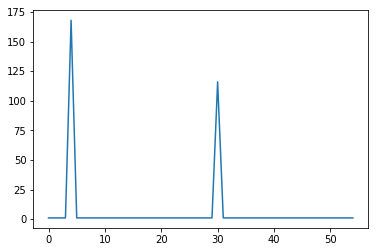

In [13]:
csv = 'p002123.psv'
print(tmp.columns)
tmp = pd.read_csv(
    '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
plt.plot(list(range(len(tmp))), tmp['Glucose'].fillna(1), label='broadcast')

### 正负样本比例

In [27]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

sick_A = [0, 0]

for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_A[1] += 1
    else:
        sick_A[0] += 1

sick_B = [0, 0]

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_B[1] += 1
    else:
        sick_B[0] += 1

Text(0.5, 1.0, '01 distribution for Sepsis')

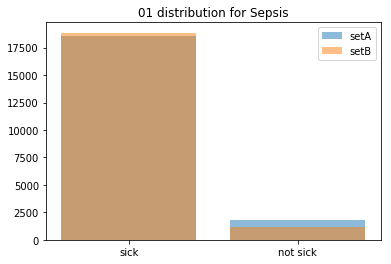

In [28]:
pA = plt.bar(['sick', 'not sick'], sick_A, label='line', alpha=0.5)
pB = plt.bar(['sick', 'not sick'], sick_B, label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("01 distribution for Sepsis")

### 正样本分析

##### 化验数据比例

In [23]:
a_traincsv = list_a
b_traincsv = list_b

chemdata_A_sick = {}
for i in range(11):
    chemdata_A_sick[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_sick[per] += 1

chemdata_B_sick = {}
for i in range(11):
    chemdata_B_sick[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_sick[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single sick person')

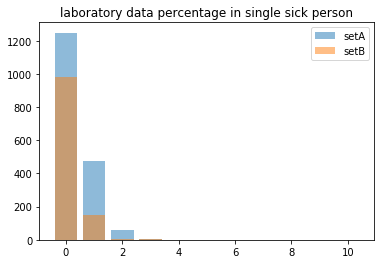

In [26]:
#chemdata_A_sick = pd.DataFrame.from_dict(chemdata_A_sick, orient='index')
#chemdata_B_sick = pd.DataFrame.from_dict(chemdata_B_sick, orient='index')
pA = plt.bar(chemdata_A_sick.index*10,
             chemdata_A_sick[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_sick.index*10,
             chemdata_B_sick[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single patient")

###### 负样本对比

In [7]:
a_traincsv = list(set(listdir('./data/trainingA/')) - set(list_a))
b_traincsv = list(set(listdir('./data/trainingB/')) - set(list_b))

chemdata_A_normal = {}
for i in range(11):
    chemdata_A_normal[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_normal[per] += 1

chemdata_B_normal = {}
for i in range(11):
    chemdata_B_normal[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_normal[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single normal person')

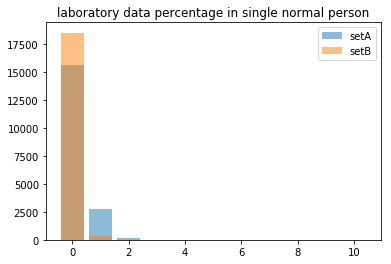

In [8]:
chemdata_A_normal = pd.DataFrame.from_dict(chemdata_A_normal, orient='index')
chemdata_B_normal = pd.DataFrame.from_dict(chemdata_B_normal, orient='index')
pA = plt.bar(chemdata_A_normal.index*10,
             chemdata_A_normal[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_normal.index*10,
             chemdata_B_normal[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single normal person")

##### 生命体征分析

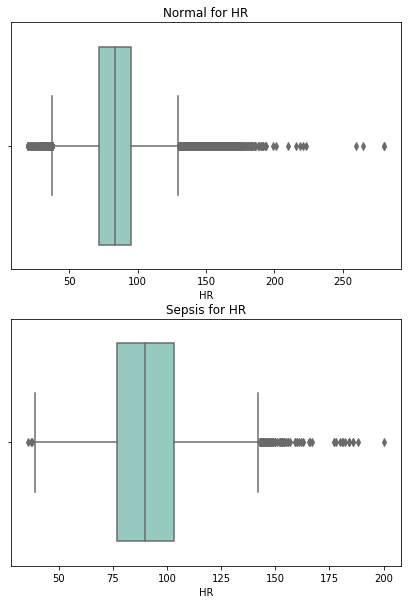

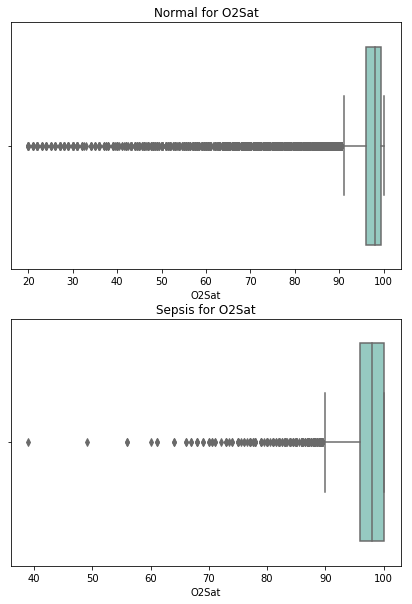

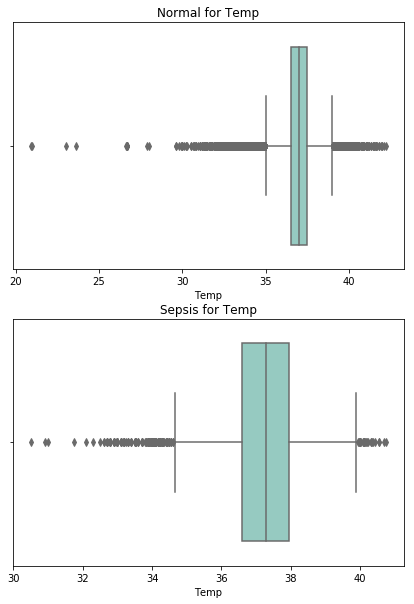

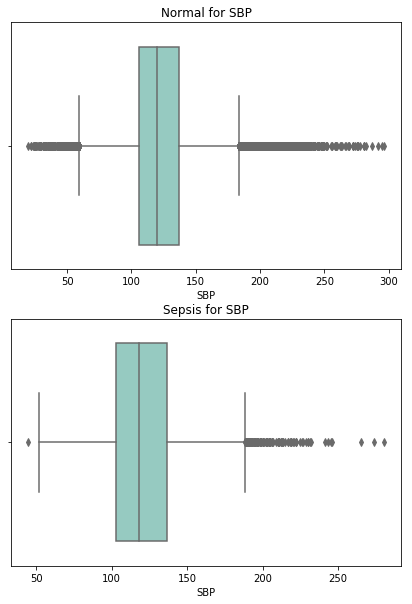

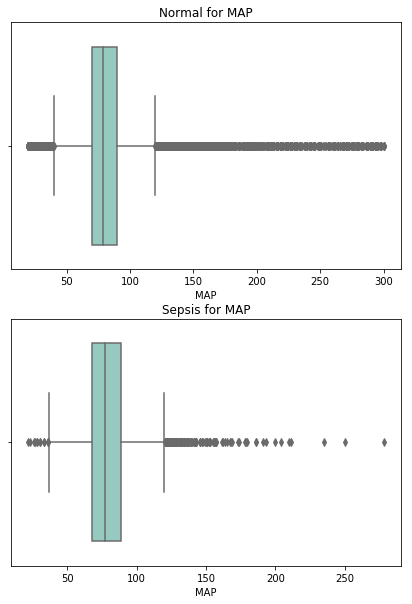

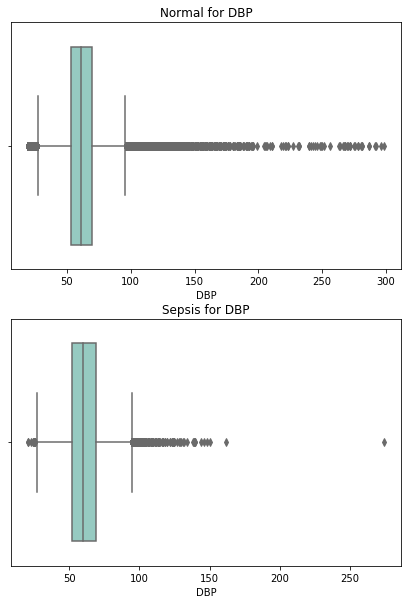

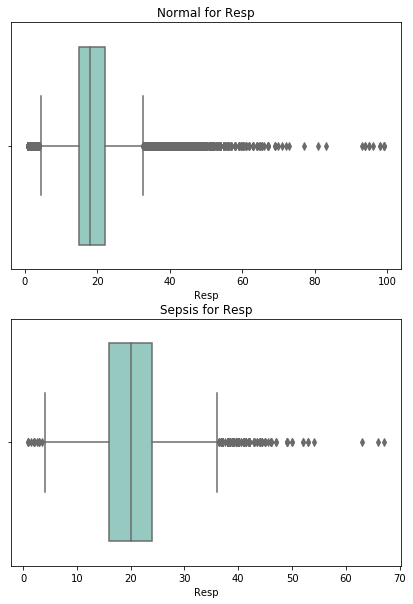

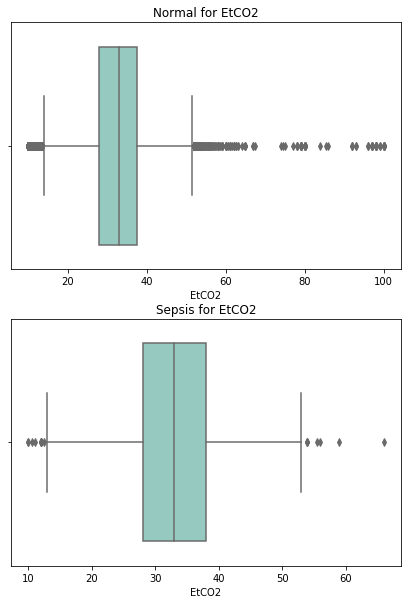

In [26]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for i, var in enumerate(vital_signs):
    temp = train[[var, 'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel'] == 0]
    temp2 = temp[temp['SepsisLabel'] == 1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

### 化验数据分析

##### 化验数据比例

In [7]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

chemdata_A = {}
for i in range(11):
    chemdata_A[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A[per] += 1

chemdata_B = {}
for i in range(11):
    chemdata_B[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B[per] += 1

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Text(0.5, 1.0, 'laboratory data percentage in one patient')

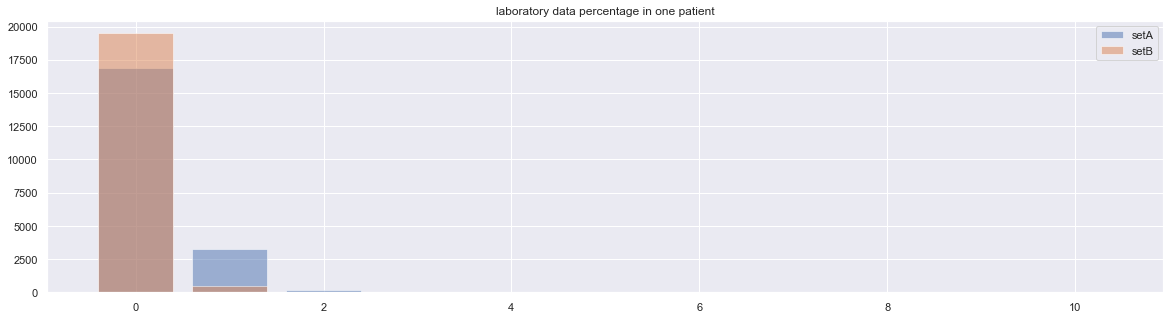

In [299]:
#chemdata_A = pd.DataFrame.from_dict(chemdata_A, orient='index')
#chemdata_B = pd.DataFrame.from_dict(chemdata_B, orient='index')
pA = plt.bar(chemdata_A.index*10, chemdata_A[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B.index*10, chemdata_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in one patient")

### 单病人观察时间长度分布

In [122]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv)
    distributionA[len(tmp)] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv)
    distributionB[len(tmp)] += 1

Text(0.5, 1.0, 'length distribution of patient set ')

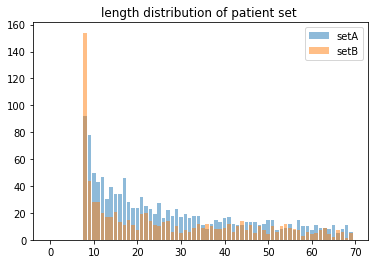

In [126]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:70], length_A[0][:70], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:70], length_B[0][:70], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("length distribution of patient set ")

### 病人平均发病时间

In [18]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionA[len(tmp[tmp['SepsisLabel'] == 0])] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionB[len(tmp[tmp['SepsisLabel'] == 0])] += 1


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'Time befored judged as sepsis ')

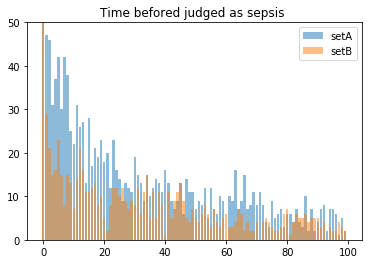

In [24]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=50)
plt.title("Time befored judged as sepsis ")

### 单病人被判断患病的时间段占比

In [102]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

one_percentage_A = {}
for i in range(11):
    one_percentage_A[i/10] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_A[percentage] += 1

one_percentage_B = {}
for i in range(11):
    one_percentage_B[i/10] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_B[percentage] += 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, "1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

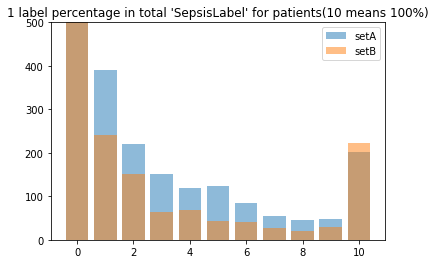

In [176]:
percentage_A = pd.DataFrame.from_dict(one_percentage_A, orient='index')
percentage_B = pd.DataFrame.from_dict(one_percentage_B, orient='index')
pA = plt.bar(percentage_A.index*10, percentage_A[0], label='line', alpha=0.5)
pB = plt.bar(percentage_B.index*10, percentage_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

### ICU种类分布

In [204]:
unit1 = 0
unit2 = 0
unit3 = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit1 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit2 += 1
    else:
        unit3 += 1

unit4 = 0
unit5 = 0
unit6 = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit4 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit5 += 1
    else:
        unit6 += 1

Text(0.5, 1.0, 'ICU kind distribution')

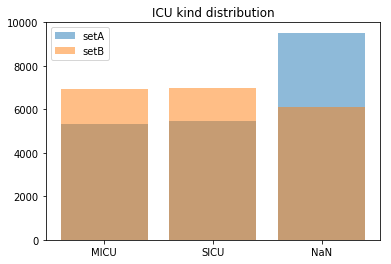

In [213]:
pA = plt.bar(['MICU', 'SICU', 'NaN'], [unit1, unit2, unit3], alpha=0.5)
pB = plt.bar(['MICU', 'SICU', 'NaN'], [unit4, unit5, unit6], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title('ICU kind distribution')

### 性别分析

In [217]:
sex = [0 for _ in range(6)]
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[0] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[1] += 1
    else:
        sex[2] += 1

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[3] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[4] += 1
    else:
        sex[5] += 1

Text(0.5, 1.0, 'sex distribution')

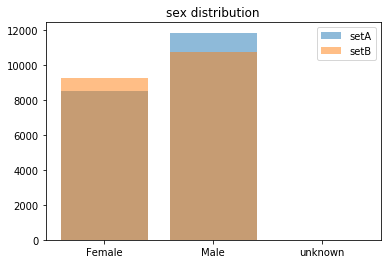

In [218]:
pA = plt.bar(['Female', 'Male', 'unknown'], sex[:3], alpha=0.5)
pB = plt.bar(['Female', 'Male', 'unknown'], sex[3:], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title('sex distribution')

### 年龄分析

In [8]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

age_A = {}
for i in range(120):
    age_A[i] = 0
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_A[age] += 1

age_B = {}
for i in range(120):
    age_B[i] = 0
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_B[age] += 1

100%|██████████| 20000/20000 [01:04<00:00, 311.63it/s]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'age distribution')

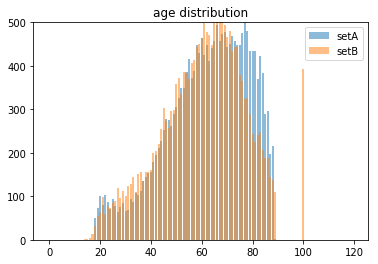

In [9]:
age_A = pd.DataFrame.from_dict(age_A, orient='index')
age_B = pd.DataFrame.from_dict(age_B, orient='index')
pA = plt.bar(age_A.index, age_A[0], label='line', alpha=0.5)
pB = plt.bar(age_B.index, age_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("age distribution")

B中最小的是14岁 A中最小的是18岁 B中有400多个100岁的

### 缺失度分析

In [239]:
train = pd.read_csv('./train.psv', sep='|')
train.shape

(1170446, 41)

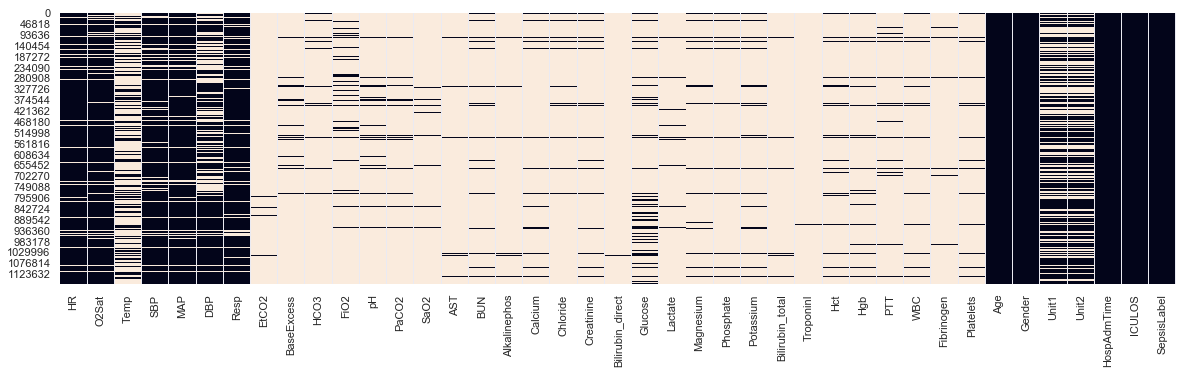

In [244]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(train.isnull(), cbar=False)

### 探索某检查与发病的关系

In [65]:
# lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
#        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
#        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
#        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
#        'Fibrinogen', 'Platelets']

lab_values = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets']



In [ ]:
a_traincsv = listdir('./data/A_single/')
b_traincsv = listdir('./data/B_single/')

distributionA = {}
for lab in lab_values:
    distributionA[lab] = []
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/A_single/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != 'normal' and list(tmp[lab])[index] != 'Missing' and list(tmp['SepsisLabel'])[index - 1] == 0 and l == -1:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                if l == -1:
                    continue
                gap = max(-1, gap - l + 1)
                distributionA[lab].append(gap)
            
        

distributionB = {}
for lab in lab_values:
    distributionB[lab] = []
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/B_single/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != 'normal' and list(tmp[lab])[index] != 'Missing' and list(tmp['SepsisLabel'])[index - 1] == 0 and l == -1:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                if l == -1:
                    continue                
                gap = max(-1, gap - l + 1)
                distributionB[lab].append(gap)
            
        



In [111]:
distributionA_ = {}
distributionB_ = {}
for feature in distributionA:
    d = distributionA[feature]
    while -1 in d:
        d.remove(-1)
    distributionA_[feature] = sum(d)/len(d) if len(d) != 0 else 0
for feature in distributionB:
    d = distributionB[feature]
    while -1 in d:
        d.remove(-1)
    distributionB_[feature] = sum(d)/len(d) if len(d) != 0 else 0

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


([<matplotlib.axis.XTick at 0x1a28103cc0>,
 <a list of 26 Text xticklabel objects>)

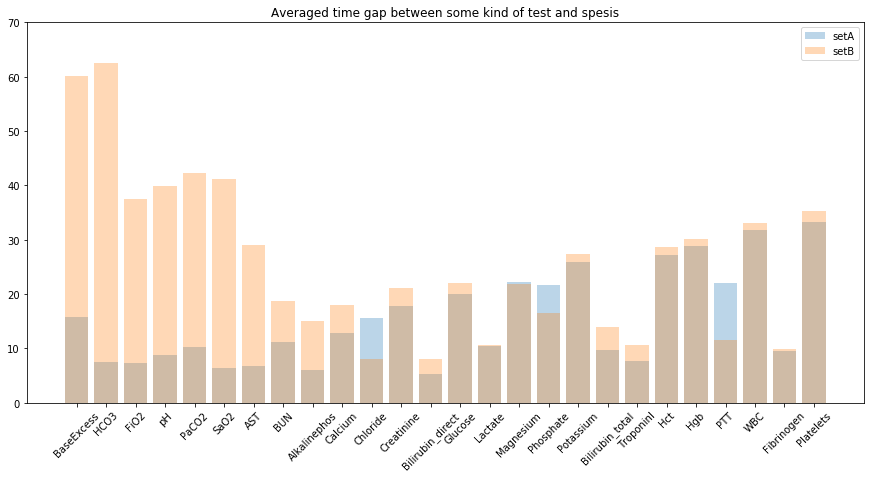

In [114]:
plt.figure(figsize=(15, 7))
length_A = pd.DataFrame.from_dict(distributionA_, orient='index')
length_B = pd.DataFrame.from_dict(distributionB_, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.3)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.3)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=70)
plt.title("Averaged time gap between some kind of test and spesis")
plt.xticks(list(range(len(list(distributionA.keys())))), list(distributionA.keys()), rotation=45, fontsize=10)

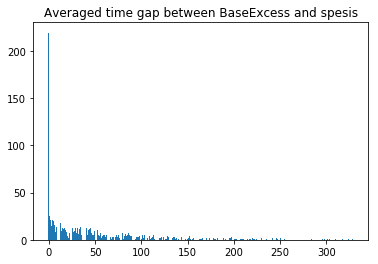

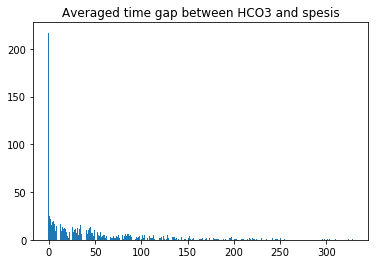

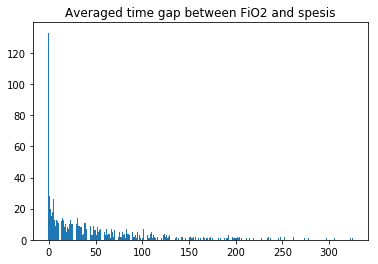

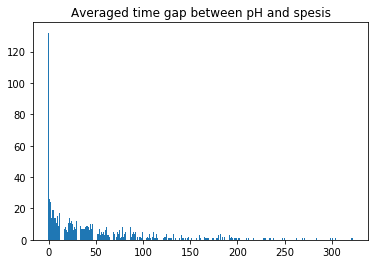

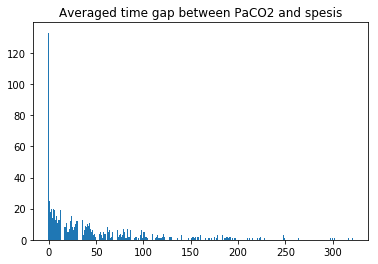

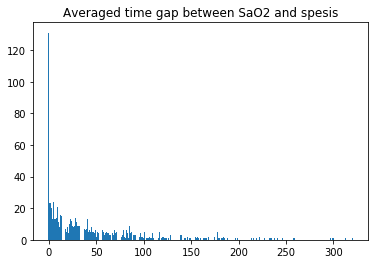

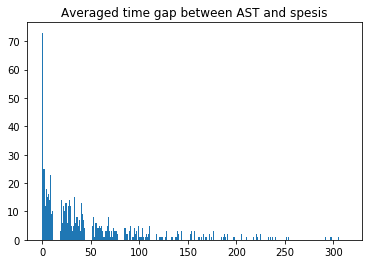

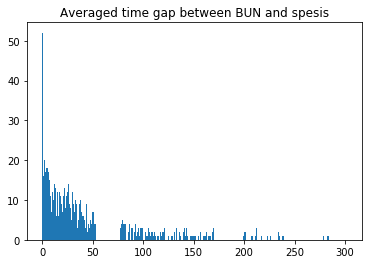

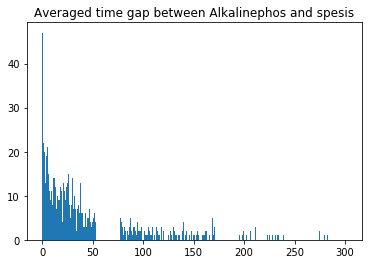

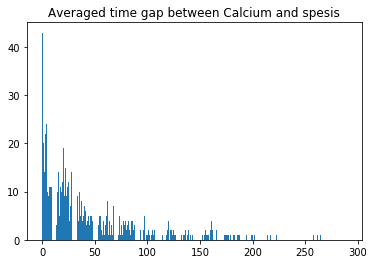

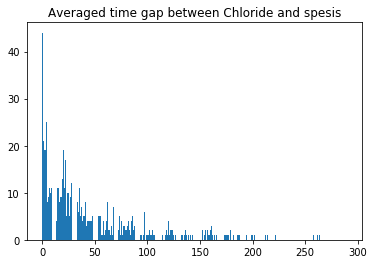

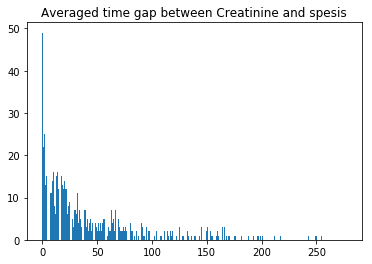

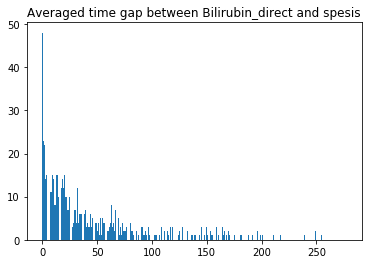

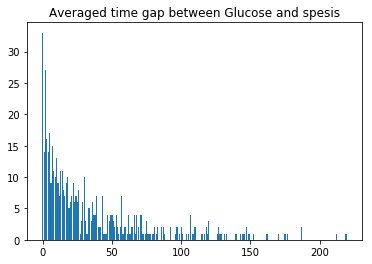

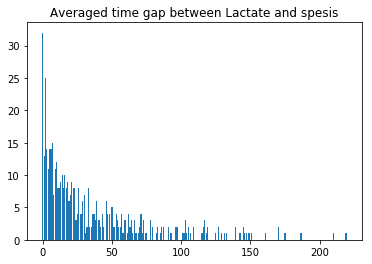

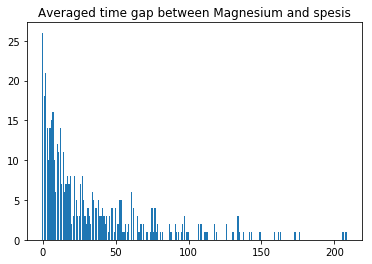

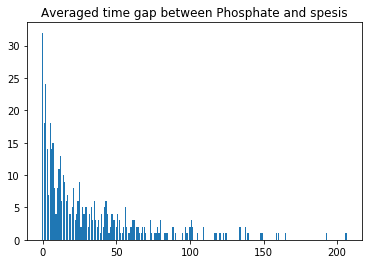

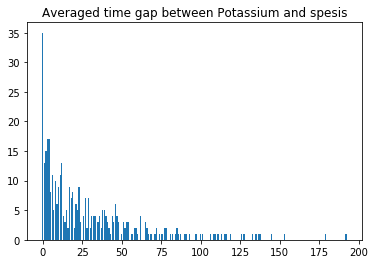

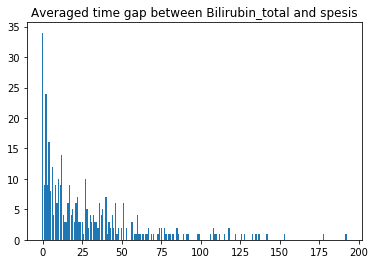

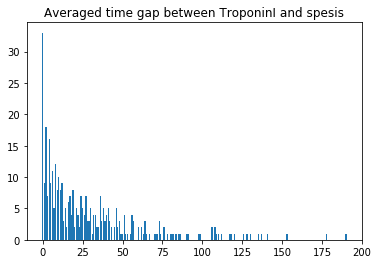

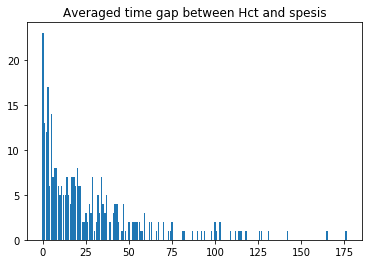

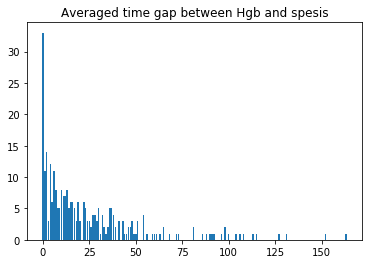

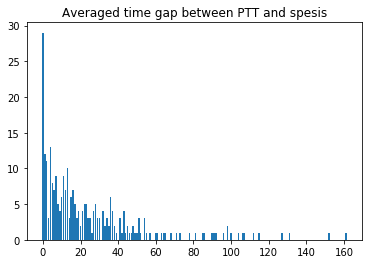

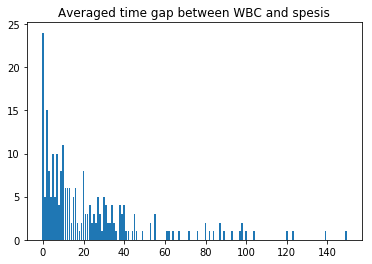

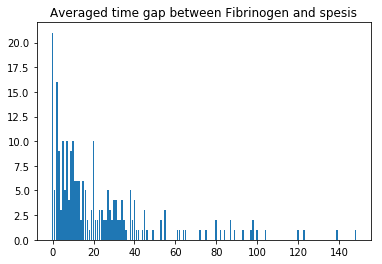

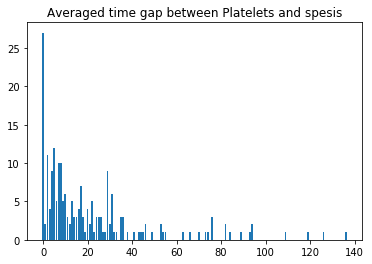

In [52]:
for i in range(len(lab_values)):
    plt.figure(i)
    plt.bar(list(Counter(distributionB[lab_values[i]])),(Counter(distributionB[lab_values[i]])).values())
    plt.title(f'Averaged time gap between {lab_values[i]} and spesis')
      

### 探索检查指标同时出现的组合

In [9]:
def cal_group(traincsv, path):
    Group = {}
    lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']
    for i, csv in enumerate(tqdm(traincsv)):
        tmp_train = pd.read_csv(path + csv, sep='|')
        tmp_train = tmp_train.fillna(-1)
        for i in range(len(tmp_train)):
            #print(tmp_train)
            group = []
            tmp = tmp_train[i:i+1]
            for feature in lab_values:
                
                if tmp[feature][i] != -1:
                    group.append(feature)
            group = tuple(group)
            if group not in Group:
                Group[group] = 1
            else:
                Group[group] += 1
    return Group


In [23]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

pathA = './data/trainingA/'
pathB = './data/trainingB/'

group_a = cal_group(a_traincsv, pathA)
group_b = cal_group(b_traincsv, pathB)

group_A = sorted(group_a, key = lambda x:group_a[x], reverse=True)
group_B = sorted(group_b, key = lambda x:group_b[x], reverse=True)
print(group_A)
print(group_B)

[(), ('FiO2',), ('Glucose',), ('Hct',), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets'), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets'), ('BaseExcess', 'FiO2', 'pH', 'PaCO2'), ('BaseExcess', 'pH', 'PaCO2'), ('HCO3', 'BUN', 'Chloride', 'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC'), ('PTT',), ('HCO3', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets'), ('BaseExcess', 'pH', 'PaCO2', 'SaO2'), ('HCO3', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium', 'Phosphate', 'Potassium'), ('BaseExcess', 'pH', 'PaCO2', 'SaO2', 'Glucose'), ('BaseExcess', 'FiO2', 'pH', 'PaCO2', 'SaO2'), ('FiO2', 'Glucose'), ('BaseExcess', 'pH', 'PaCO2', 'Lactate'), ('BaseExcess', 'pH'), ('BaseExc

In [51]:
DataFrame([group_A,[group_a[v] for v in group_A]], index=['group','numbers']).T.to_csv('A_group.csv')
DataFrame([group_B,[group_b[v] for v in group_B]], index=['group','numbers']).T.to_csv('B_group.csv')


# Data processing

In [193]:
train = pd.read_csv('./data/train.psv', sep='|')
len(train)

1552265

In [195]:
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [196]:
train_apply = train.apply(feature_engineer)

KeyError: ('Age', 'occurred at index HR')

decoration

## No FE

In [9]:
feature_org = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [10]:
a_traincsv = listdir('./data/trainingA/')
for i,csv in tqdm(enumerate(a_traincsv)):
    with open(f"./data/A_nfe/A_nfe_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
        cur_train.fillna(method='pad', inplace=True)
        cur_train.fillna(0, inplace=True)
        cur_train = feature_engineer_cut(cur_train)
        pickle.dump(cur_train, file)

20336it [52:12,  6.81it/s]


In [11]:
b_traincsv = listdir('./data/trainingB/')
for i,csv in tqdm(enumerate(b_traincsv)):
    with open(f"./data/B_nfe/B_nfe_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
        cur_train.fillna(method='pad', inplace=True)
        cur_train.fillna(0, inplace=True)
        cur_train = feature_engineer_cut(cur_train)
        pickle.dump(cur_train, file)

20000it [48:10,  7.87it/s]


### for A

In [13]:
import warnings
warnings.filterwarnings("ignore")

kind = 'nfe'
a_pkl = listdir(f'./data/A_{kind}/')
trainA = [[] for _ in range(42)]

for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/A_{kind}/A_{kind}_{i * 500}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    for _, pkl in enumerate(tqdm(a_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainA[i] = pd.merge(trainA[i], tmp,how='outer')
            
with open(f'./data/A_{kind}/A_{kind}_{20001}.pkl', 'rb') as file:
    trainA[40] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[40 * 500 + 2:])):
    with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[40] = pd.merge(trainA[40], tmp,how='outer')
    
trainA[41] = trainA[0]
with open(f"./data/A_{kind}/A{kind}.pkl", 'wb') as file_A:
    for i in range(41):
        tmp = trainA[i]
        trainA[41] = pd.merge(trainA[41], tmp,how='outer')
    pickle.dump(trainA[41], file_A)



  0%|          | 2/500 [00:00<00:27, 17.85it/s]

set****************************0******************************



 69%|██████▉   | 345/500 [01:14<00:49,  3.12it/s]


  0%|          | 2/500 [00:00<00:26, 18.49it/s]

set****************************1******************************



 71%|███████   | 354/500 [01:01<00:52,  2.79it/s]


  0%|          | 1/500 [00:00<00:56,  8.76it/s]

set****************************2******************************



 65%|██████▌   | 326/500 [01:20<00:56,  3.09it/s]


  0%|          | 2/500 [00:00<00:29, 17.00it/s]

set****************************3******************************



 68%|██████▊   | 339/500 [01:05<00:51,  3.13it/s]


  0%|          | 2/500 [00:00<00:27, 17.97it/s]

set****************************4******************************



 68%|██████▊   | 338/500 [01:12<01:07,  2.41it/s]


  0%|          | 2/500 [00:00<00:29, 16.78it/s]

set****************************5******************************



 68%|██████▊   | 340/500 [01:10<00:50,  3.15it/s]


  0%|          | 2/500 [00:00<00:28, 17.46it/s]

set****************************6******************************



 66%|██████▌   | 331/500 [01:13<00:58,  2.89it/s]


  0%|          | 2/500 [00:00<00:26, 18.75it/s]

set****************************7******************************



 69%|██████▉   | 347/500 [00:58<00:42,  3.62it/s]


  0%|          | 2/500 [00:00<00:40, 12.27it/s]

set****************************8******************************



 70%|██████▉   | 348/500 [01:00<00:40,  3.71it/s]


  1%|          | 3/500 [00:00<00:25, 19.85it/s]

set****************************9******************************



 70%|███████   | 352/500 [00:58<00:42,  3.50it/s]


  1%|          | 3/500 [00:00<00:23, 21.30it/s]

set****************************10******************************



 70%|███████   | 351/500 [01:00<00:44,  3.34it/s]


  0%|          | 2/500 [00:00<00:25, 19.85it/s]

set****************************11******************************



 69%|██████▉   | 346/500 [00:57<00:37,  4.09it/s]


  1%|          | 3/500 [00:00<00:22, 21.62it/s]

set****************************12******************************



 71%|███████   | 356/500 [00:59<00:37,  3.81it/s]


  1%|          | 3/500 [00:00<00:23, 21.40it/s]

set****************************13******************************



 71%|███████▏  | 357/500 [00:57<00:38,  3.76it/s]


  1%|          | 3/500 [00:00<00:21, 23.08it/s]

set****************************14******************************



 72%|███████▏  | 359/500 [00:57<00:42,  3.28it/s]


  1%|          | 3/500 [00:00<00:22, 21.87it/s]

set****************************15******************************



 71%|███████   | 355/500 [00:58<00:39,  3.64it/s]


  1%|          | 3/500 [00:00<00:24, 20.67it/s]

set****************************16******************************



 71%|███████   | 354/500 [00:55<00:38,  3.80it/s]


  0%|          | 2/500 [00:00<00:25, 19.78it/s]

set****************************17******************************



 71%|███████   | 354/500 [00:56<00:36,  4.02it/s]


  1%|          | 3/500 [00:00<00:20, 24.41it/s]

set****************************18******************************



 74%|███████▍  | 371/500 [00:41<00:21,  6.07it/s]


  1%|          | 4/500 [00:00<00:14, 34.84it/s]

set****************************19******************************



 86%|████████▌ | 429/500 [00:44<00:12,  5.78it/s]


  1%|          | 4/500 [00:00<00:14, 34.37it/s]

set****************************20******************************



 85%|████████▌ | 427/500 [00:45<00:12,  5.68it/s]


  1%|          | 4/500 [00:00<00:14, 34.38it/s]

set****************************21******************************



 85%|████████▌ | 426/500 [00:44<00:12,  5.79it/s]


  0%|          | 2/500 [00:00<00:28, 17.56it/s]

set****************************22******************************



 84%|████████▍ | 421/500 [00:44<00:13,  5.66it/s]


  1%|          | 4/500 [00:00<00:13, 35.64it/s]

set****************************23******************************



 86%|████████▌ | 428/500 [00:44<00:12,  5.54it/s]


  1%|          | 4/500 [00:00<00:14, 33.81it/s]

set****************************24******************************



 85%|████████▌ | 425/500 [00:45<00:13,  5.56it/s]


  1%|          | 4/500 [00:00<00:13, 35.74it/s]

set****************************25******************************



 86%|████████▌ | 430/500 [00:44<00:12,  5.68it/s]


  1%|          | 4/500 [00:00<00:14, 34.58it/s]

set****************************26******************************



 84%|████████▍ | 420/500 [00:44<00:14,  5.58it/s]


  1%|          | 4/500 [00:00<00:14, 34.64it/s]

set****************************27******************************



 86%|████████▌ | 428/500 [00:44<00:12,  5.70it/s]


  1%|          | 4/500 [00:00<00:13, 36.02it/s]

set****************************28******************************



 86%|████████▌ | 428/500 [00:45<00:13,  5.48it/s]


  1%|          | 4/500 [00:00<00:13, 35.94it/s]

set****************************29******************************



 86%|████████▋ | 432/500 [00:45<00:12,  5.48it/s]


  1%|          | 4/500 [00:00<00:14, 33.15it/s]

set****************************30******************************



 85%|████████▌ | 427/500 [00:44<00:12,  5.88it/s]


  1%|          | 4/500 [00:00<00:14, 34.19it/s]

set****************************31******************************



 85%|████████▍ | 424/500 [00:45<00:13,  5.70it/s]


  1%|          | 3/500 [00:00<00:19, 25.34it/s]

set****************************32******************************



 86%|████████▌ | 429/500 [00:45<00:12,  5.64it/s]


  1%|          | 4/500 [00:00<00:14, 34.23it/s]

set****************************33******************************



 84%|████████▍ | 422/500 [00:44<00:13,  5.62it/s]


  1%|          | 4/500 [00:00<00:13, 35.60it/s]

set****************************34******************************



 85%|████████▌ | 426/500 [00:44<00:13,  5.58it/s]


  1%|          | 4/500 [00:00<00:14, 35.36it/s]

set****************************35******************************



 87%|████████▋ | 435/500 [00:45<00:12,  5.39it/s]


  1%|          | 4/500 [00:00<00:14, 34.50it/s]

set****************************36******************************



 85%|████████▌ | 425/500 [00:45<00:14,  5.12it/s]


  1%|          | 4/500 [00:00<00:14, 33.83it/s]

set****************************37******************************



 85%|████████▌ | 425/500 [00:44<00:13,  5.49it/s]


  1%|          | 4/500 [00:00<00:14, 34.03it/s]

set****************************38******************************



 85%|████████▍ | 423/500 [00:45<00:14,  5.17it/s]


  1%|          | 4/500 [00:00<00:16, 30.68it/s]

set****************************39******************************



 81%|████████  | 404/500 [00:47<00:18,  5.21it/s]


100%|██████████| 500/500 [01:08<00:00,  4.14it/s]
0it [00:00, ?it/s]
3it [00:00, 29.25it/s]
6it [00:00, 28.97it/s]
9it [00:00, 28.55it/s]
12it [00:00, 27.97it/s]
15it [00:00, 27.13it/s]
18it [00:00, 26.30it/s]
21it [00:00, 25.64it/s]
24it [00:00, 25.14it/s]
27it [00:01, 24.37it/s]
30it [00:01, 23.75it/s]
33it [00:01, 23.23it/s]
36it [00:01, 22.87it/s]
39it [00:01, 22.12it/s]
42it [00:01, 21.58it/s]
45it [00:01, 21.02it/s]
48it [00:02, 20.42it/s]
51it [00:02, 19.97it/s]
54it [00:02, 19.05it/s]
56it [00:02, 18.53it/s]
58it [00:02, 18.26it/s]
60it [00:02, 17.97it/s]
62it [00:02, 17.55it/s]
64it [00:02, 17.28it/s]
66it [00:03, 17.02it/s]
68it [00:03, 16.62it/s]
70it [00:03, 16.52it/s]
72it [00:03, 16.32it/s]
74it [00:03, 16.15it/s]
76it [00:03, 15.56it/s]
78it [00:03, 15.58it/s]
80it [00:03, 15.54it/s]
82it [00:04, 15.22it/s]
84it [00:04, 15.16it/s]
86it [00:04, 14.97it/s]
88it [00:04, 14.79it/s]
90it [00:04, 14.70it/s]
92it [00:04, 14.45it/s]
94it [00:04, 14.04it/s]
96it [00:05, 13.95it/s

### for B

In [14]:
kind = 'nfe'
b_pkl = listdir(f'./data/B_{kind}/')
trainB = [[] for _ in range(41)]
for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/B_{kind}/B_{kind}_{i * 500}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(tqdm(b_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/B_{kind}/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainB[i] = pd.merge(trainB[i], tmp,how='outer')


  1%|          | 4/500 [00:00<00:16, 30.55it/s]

set****************************0******************************



 81%|████████▏ | 407/500 [00:48<00:19,  4.87it/s]


  1%|          | 3/500 [00:00<00:20, 24.80it/s]

set****************************1******************************



 74%|███████▍  | 372/500 [00:45<00:19,  6.47it/s]


  1%|          | 4/500 [00:00<00:15, 33.03it/s]

set****************************2******************************



 85%|████████▍ | 424/500 [00:45<00:13,  5.45it/s]


  1%|          | 4/500 [00:00<00:14, 34.27it/s]

set****************************3******************************



 86%|████████▌ | 428/500 [00:51<00:20,  3.53it/s]


  1%|          | 3/500 [00:00<00:23, 21.28it/s]

set****************************4******************************



 72%|███████▏  | 359/500 [00:52<00:27,  5.08it/s]


  1%|          | 3/500 [00:00<00:18, 26.51it/s]

set****************************5******************************



 59%|█████▊    | 293/500 [00:51<01:32,  2.25it/s]

KeyboardInterrupt: 

In [ ]:
trainB[40] = trainB[0]
with open(f"./data/B_{kind}/B{kind}.pkl", 'wb') as file_B:
    for i in tqdm(range(40)):
        tmp = trainB[i]
        trainB[40] = pd.merge(trainB[40], tmp,how='outer')
    pickle.dump(trainB[40], file_B)


### for AB

In [10]:
kind = 'nfe'
with open(f"./data/{kind}.pkl", 'wb') as file_AB:
    with open(f"./data/A_{kind}/A{kind}.pkl", 'rb') as file_A:
        cutA = pickle.load(file_A)
    with open(f"./data/B_{kind}/B{kind}.pkl", 'rb') as file_B:
        cutB = pickle.load(file_B)
        
    cut = pd.merge(cutA, cutB,how='outer')
    
    pickle.dump(cut, file_AB)

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


## Merge pkls to a big one

### for cutA

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
kind = '100'
a_pkl = listdir(f'./data/A_{kind}/')
trainA = [[] for _ in range(82)]

for i in range(80):
    print(f'set****************************{i}******************************')
    with open(f'./data/A_{kind}/A_{kind}_{i * 250}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    for _, pkl in enumerate(tqdm(a_pkl[i * 250 + 1:(i + 1) * 250 + 0])):
        if pkl == '.DS_Store':
            continue
        try:
            with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
                tmp = pickle.load(file)
                trainA[i] = pd.concat( [trainA[i], tmp], axis=0 )
                #trainA[i] = pd.merge(trainA[i], tmp,how='outer')
        except:
            continue
    #print(f'set****************************{len(trainA[i])}******************************')
with open(f'./data/A_{kind}/A_{kind}_{20000}.pkl', 'rb') as file:
    trainA[80] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[80 * 250 + 2:])):
    with open(f'./data/A_{kind}/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[80] = pd.concat( [trainA[80], tmp], axis=0 )
        #trainA[80] = pd.merge(trainA[80], tmp,how='outer')
    

trainA[81] = trainA[0]
with open(f"./data/A_100/A100.pkl", 'wb') as file_A:
    for i in tqdm(range(1,81)):
        tmp = trainA[i]
        trainA[81] = pd.concat( [trainA[81], tmp], axis=0 )
    pickle.dump(trainA[81], file_A)


  1%|          | 4/500 [00:00<00:13, 36.40it/s]

set****************************0******************************



 86%|████████▌ | 428/500 [00:45<00:13,  5.46it/s]


  1%|          | 4/500 [00:00<00:12, 39.88it/s]

set****************************1******************************



 85%|████████▌ | 425/500 [00:45<00:13,  5.38it/s]


  1%|          | 4/500 [00:00<00:12, 39.26it/s]

set****************************2******************************



 85%|████████▌ | 426/500 [00:46<00:15,  4.85it/s]


  1%|          | 4/500 [00:00<00:14, 34.93it/s]

set****************************3******************************



 83%|████████▎ | 417/500 [00:47<00:15,  5.33it/s]


  1%|          | 4/500 [00:00<00:12, 39.22it/s]

set****************************4******************************



 85%|████████▍ | 424/500 [00:45<00:13,  5.47it/s]


  1%|          | 4/500 [00:00<00:12, 39.60it/s]

set****************************5******************************



 85%|████████▌ | 427/500 [00:50<00:14,  5.17it/s]


  1%|          | 5/500 [00:00<00:12, 39.46it/s]

set****************************6******************************



 83%|████████▎ | 414/500 [00:45<00:15,  5.38it/s]


  1%|          | 4/500 [00:00<00:13, 37.21it/s]

set****************************7******************************



 86%|████████▌ | 428/500 [00:45<00:13,  5.42it/s]


  1%|          | 4/500 [00:00<00:12, 39.26it/s]

set****************************8******************************



 85%|████████▍ | 424/500 [00:45<00:14,  5.31it/s]


  1%|          | 5/500 [00:00<00:12, 39.66it/s]

set****************************9******************************



 85%|████████▍ | 424/500 [00:45<00:14,  5.10it/s]


  1%|          | 5/500 [00:00<00:12, 40.28it/s]

set****************************10******************************



 85%|████████▍ | 424/500 [00:52<00:17,  4.29it/s]


  1%|          | 5/500 [00:00<00:12, 40.29it/s]

set****************************11******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.53it/s]


  1%|          | 5/500 [00:00<00:12, 39.65it/s]

set****************************12******************************



 86%|████████▌ | 430/500 [00:44<00:12,  5.61it/s]


  1%|          | 5/500 [00:00<00:12, 41.17it/s]

set****************************13******************************



 87%|████████▋ | 433/500 [00:44<00:11,  5.61it/s]


  1%|          | 5/500 [00:00<00:12, 40.83it/s]

set****************************14******************************



 86%|████████▋ | 432/500 [00:44<00:12,  5.64it/s]


  1%|          | 4/500 [00:00<00:12, 39.63it/s]

set****************************15******************************



 87%|████████▋ | 433/500 [00:45<00:12,  5.46it/s]


  1%|          | 5/500 [00:00<00:12, 41.23it/s]

set****************************16******************************



 84%|████████▍ | 422/500 [00:44<00:14,  5.43it/s]


  1%|          | 5/500 [00:00<00:12, 40.90it/s]

set****************************17******************************



 85%|████████▌ | 427/500 [00:45<00:14,  5.21it/s]


  1%|          | 4/500 [00:00<00:13, 36.13it/s]

set****************************18******************************



 85%|████████▍ | 423/500 [00:44<00:14,  5.48it/s]


  1%|          | 4/500 [00:00<00:13, 37.22it/s]

set****************************19******************************



 85%|████████▌ | 426/500 [00:45<00:13,  5.47it/s]


  1%|          | 4/500 [00:00<00:12, 39.78it/s]

set****************************20******************************



 84%|████████▍ | 420/500 [00:44<00:14,  5.40it/s]


  1%|          | 4/500 [00:00<00:13, 36.52it/s]

set****************************21******************************



 85%|████████▍ | 424/500 [00:44<00:13,  5.50it/s]


  1%|          | 4/500 [00:00<00:13, 36.73it/s]

set****************************22******************************



 84%|████████▍ | 421/500 [00:44<00:14,  5.41it/s]


  1%|          | 4/500 [00:00<00:12, 38.89it/s]

set****************************23******************************



 85%|████████▌ | 425/500 [00:45<00:13,  5.43it/s]


  1%|          | 5/500 [00:00<00:12, 38.99it/s]

set****************************24******************************



 85%|████████▌ | 425/500 [00:45<00:13,  5.48it/s]


  1%|          | 4/500 [00:00<00:12, 39.08it/s]

set****************************25******************************



 85%|████████▍ | 424/500 [00:45<00:13,  5.64it/s]


  1%|          | 5/500 [00:00<00:11, 42.11it/s]

set****************************26******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.60it/s]


  1%|          | 5/500 [00:00<00:12, 39.57it/s]

set****************************27******************************



 87%|████████▋ | 434/500 [00:44<00:11,  5.58it/s]


  1%|          | 5/500 [00:00<00:12, 39.25it/s]

set****************************28******************************



 86%|████████▌ | 429/500 [00:44<00:12,  5.58it/s]


  1%|          | 5/500 [00:00<00:11, 42.32it/s]

set****************************29******************************



 87%|████████▋ | 435/500 [00:45<00:11,  5.56it/s]


  1%|          | 4/500 [00:00<00:13, 36.97it/s]

set****************************30******************************



 87%|████████▋ | 433/500 [00:44<00:12,  5.46it/s]


  1%|          | 5/500 [00:00<00:12, 41.06it/s]

set****************************31******************************



 87%|████████▋ | 433/500 [00:44<00:11,  5.62it/s]


  1%|          | 4/500 [00:00<00:12, 38.85it/s]

set****************************32******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.44it/s]


  1%|          | 4/500 [00:00<00:12, 39.35it/s]

set****************************33******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.60it/s]


  1%|          | 5/500 [00:00<00:12, 40.46it/s]

set****************************34******************************



 86%|████████▌ | 428/500 [00:44<00:12,  5.61it/s]


  1%|          | 4/500 [00:00<00:12, 38.73it/s]

set****************************35******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.56it/s]


  1%|          | 5/500 [00:00<00:12, 38.38it/s]

set****************************36******************************



 86%|████████▋ | 432/500 [00:45<00:12,  5.51it/s]


  1%|          | 5/500 [00:00<00:12, 41.18it/s]

set****************************37******************************



 87%|████████▋ | 433/500 [00:44<00:12,  5.47it/s]


  1%|          | 5/500 [00:00<00:11, 41.47it/s]

set****************************38******************************



 86%|████████▌ | 431/500 [00:44<00:12,  5.41it/s]


  1%|          | 5/500 [00:00<00:11, 42.04it/s]

set****************************39******************************



 86%|████████▋ | 432/500 [00:44<00:12,  5.59it/s]


100%|██████████| 500/500 [00:57<00:00,  4.80it/s]
0it [00:00, ?it/s]
5it [00:00, 40.26it/s]
9it [00:00, 38.56it/s]
13it [00:00, 37.89it/s]
17it [00:00, 36.05it/s]
20it [00:00, 32.59it/s]
24it [00:00, 32.28it/s]
28it [00:00, 31.61it/s]
31it [00:00, 30.30it/s]
34it [00:01, 29.59it/s]
37it [00:01, 29.06it/s]
40it [00:01, 28.04it/s]
43it [00:01, 26.92it/s]
46it [00:01, 26.38it/s]
49it [00:01, 25.84it/s]
52it [00:01, 24.70it/s]
55it [00:01, 23.48it/s]
58it [00:02, 22.56it/s]
61it [00:02, 21.92it/s]
64it [00:02, 21.82it/s]
67it [00:02, 21.02it/s]
70it [00:02, 20.23it/s]
73it [00:02, 19.84it/s]
75it [00:02, 19.48it/s]
77it [00:03, 19.08it/s]
79it [00:03, 18.88it/s]
81it [00:03, 18.52it/s]
83it [00:03, 18.32it/s]
85it [00:03, 18.19it/s]
87it [00:03, 17.69it/s]
89it [00:03, 17.37it/s]
91it [00:03, 15.55it/s]
93it [00:04, 14.53it/s]
95it [00:04, 14.72it/s]
97it [00:04, 15.03it/s]
99it [00:04, 15.24it/s]
101it [00:04, 15.22it/s]
103it [00:04, 15.05it/s]
105it [00:04, 15.10it/s]
107it [00:04, 14.8

### for cutB

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
kind = '100'
b_pkl = listdir(f'./data/B_{kind}/')
trainB = [[] for _ in range(81)]
for i in range(80):
    print(f'set****************************{i}******************************')
    with open(f'./data/B_{kind}/B_{kind}_{i * 250}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(b_pkl[i * 250 + 1:(i + 1) * 250 + 0]):
        if pkl == '.DS_Store':
            continue
        try:
            with open(f'./data/B_{kind}/' + pkl, 'rb') as file:
                tmp = pickle.load(file)
                trainB[i] = pd.concat( [trainB[i], tmp], axis=0 )
                #trainB[i] = pd.merge(trainB[i], tmp,how='outer')
        except:
            continue
    print(f'set****************************{len(trainB[i])}******************************')

trainB[80] = trainB[0]
with open(f"./data/B_{kind}/B{kind}.pkl", 'wb') as file_B:
    for i in tqdm(range(1, 80)):
        tmp = trainB[i]
        trainB[80] = pd.concat( [trainB[80], tmp], axis=0 )
        print(len(trainB[80]))
    pickle.dump(trainB[80], file_B)











  0%|          | 0/249 [00:00<?, ?it/s]









 12%|█▏        | 29/249 [00:00<00:00, 286.31it/s]

set****************************0******************************












 18%|█▊        | 46/249 [00:00<00:00, 233.82it/s]









 24%|██▍       | 60/249 [00:00<00:00, 189.26it/s]









 29%|██▉       | 72/249 [00:00<00:01, 156.15it/s]









 34%|███▍      | 85/249 [00:00<00:01, 146.30it/s]









 39%|███▉      | 97/249 [00:00<00:01, 135.19it/s]









 44%|████▍     | 109/249 [00:00<00:01, 121.84it/s]









 49%|████▊     | 121/249 [00:00<00:01, 112.45it/s]









 53%|█████▎    | 132/249 [00:00<00:01, 104.32it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 98.34it/s] 









 61%|██████▏   | 153/249 [00:01<00:01, 88.40it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 82.07it/s]









 69%|██████▊   | 171/249 [00:01<00:00, 78.14it/s]









 72%|███████▏  | 179/249 [00:01<00:00, 76.12it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 73.18it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 70.88it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 67.27it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 65.

set****************************25000******************************
set****************************1******************************


 22%|██▏       | 55/249 [00:00<00:00, 283.45it/s]









 29%|██▊       | 71/249 [00:00<00:00, 226.47it/s]









 34%|███▍      | 85/249 [00:00<00:00, 188.89it/s]









 40%|███▉      | 99/249 [00:00<00:00, 161.89it/s]









 45%|████▌     | 113/249 [00:00<00:00, 142.36it/s]









 51%|█████     | 126/249 [00:00<00:00, 124.99it/s]









 55%|█████▌    | 138/249 [00:00<00:00, 113.42it/s]









 60%|██████    | 150/249 [00:01<00:00, 103.48it/s]









 65%|██████▍   | 161/249 [00:01<00:00, 95.97it/s] 









 69%|██████▊   | 171/249 [00:01<00:00, 89.31it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 83.38it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 78.95it/s]









 80%|███████▉  | 199/249 [00:01<00:00, 74.78it/s]









 83%|████████▎ | 207/249 [00:01<00:00, 71.31it/s]









 86%|████████▋ | 215/249 [00:01<00:00, 68.02it/s]









 89%|████████▉ | 222/249 [00:02<00:00, 64.91it/s]









 92%|█████████▏| 229/249 [00:02<00:00, 62.58it/s]



set****************************25000******************************
set****************************2******************************












 22%|██▏       | 56/249 [00:00<00:00, 288.91it/s]









 29%|██▉       | 73/249 [00:00<00:00, 233.73it/s]









 35%|███▌      | 88/249 [00:00<00:00, 195.00it/s]









 41%|████▏     | 103/249 [00:00<00:00, 162.54it/s]









 47%|████▋     | 117/249 [00:00<00:00, 138.13it/s]









 52%|█████▏    | 130/249 [00:00<00:00, 121.69it/s]









 57%|█████▋    | 142/249 [00:00<00:00, 110.65it/s]









 61%|██████▏   | 153/249 [00:01<00:00, 101.60it/s]









 66%|██████▌   | 164/249 [00:01<00:00, 94.25it/s] 









 70%|██████▉   | 174/249 [00:01<00:00, 87.28it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 82.41it/s]









 77%|███████▋  | 192/249 [00:01<00:00, 78.13it/s]









 80%|████████  | 200/249 [00:01<00:00, 74.63it/s]









 84%|████████▎ | 208/249 [00:01<00:00, 71.89it/s]









 87%|████████▋ | 216/249 [00:01<00:00, 69.32it/s]









 90%|████████▉ | 224/249 [00:02<00:00, 66.04it/s]









 93%|█████████▎| 231/249 [00:02<00:00, 6

set****************************25000******************************
set****************************3******************************












 22%|██▏       | 55/249 [00:00<00:00, 280.81it/s]









 29%|██▉       | 72/249 [00:00<00:00, 232.01it/s]









 35%|███▍      | 87/249 [00:00<00:00, 189.06it/s]









 41%|████      | 101/249 [00:00<00:00, 148.63it/s]









 46%|████▌     | 114/249 [00:00<00:01, 131.37it/s]









 51%|█████     | 126/249 [00:00<00:01, 120.82it/s]









 55%|█████▌    | 138/249 [00:00<00:01, 110.31it/s]









 60%|█████▉    | 149/249 [00:01<00:00, 100.81it/s]









 64%|██████▍   | 160/249 [00:01<00:00, 93.37it/s] 









 68%|██████▊   | 170/249 [00:01<00:00, 79.45it/s]









 72%|███████▏  | 179/249 [00:01<00:00, 70.76it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 67.84it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 66.92it/s]









 81%|████████  | 202/249 [00:01<00:00, 65.85it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 64.54it/s]









 87%|████████▋ | 216/249 [00:02<00:00, 63.58it/s]









 90%|████████▉ | 223/249 [00:02<00:00, 6

set****************************25000******************************
set****************************4******************************












 21%|██▏       | 53/249 [00:00<00:00, 267.21it/s]









 27%|██▋       | 68/249 [00:00<00:00, 210.42it/s]









 33%|███▎      | 82/249 [00:00<00:00, 181.68it/s]









 39%|███▊      | 96/249 [00:00<00:00, 161.32it/s]









 44%|████▍     | 110/249 [00:00<00:00, 140.80it/s]









 49%|████▉     | 123/249 [00:00<00:00, 126.08it/s]









 54%|█████▍    | 135/249 [00:00<00:00, 115.09it/s]









 59%|█████▉    | 147/249 [00:01<00:00, 105.23it/s]









 63%|██████▎   | 158/249 [00:01<00:00, 91.21it/s] 









 67%|██████▋   | 168/249 [00:01<00:00, 85.84it/s]









 71%|███████   | 177/249 [00:01<00:00, 80.86it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 76.92it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 73.73it/s]









 81%|████████  | 202/249 [00:01<00:00, 68.88it/s]









 84%|████████▍ | 210/249 [00:01<00:00, 66.14it/s]









 87%|████████▋ | 217/249 [00:02<00:00, 62.81it/s]









 90%|████████▉ | 224/249 [00:02<00:00, 60

set****************************25000******************************
set****************************5******************************












 20%|██        | 50/249 [00:00<00:00, 252.41it/s]









 26%|██▌       | 65/249 [00:00<00:00, 206.07it/s]









 32%|███▏      | 80/249 [00:00<00:00, 182.03it/s]









 38%|███▊      | 94/249 [00:00<00:00, 157.22it/s]









 43%|████▎     | 107/249 [00:00<00:01, 139.75it/s]









 48%|████▊     | 120/249 [00:00<00:01, 126.12it/s]









 53%|█████▎    | 132/249 [00:00<00:01, 113.77it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 104.47it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 94.16it/s] 









 66%|██████▌   | 164/249 [00:01<00:00, 86.38it/s]









 69%|██████▉   | 173/249 [00:01<00:00, 83.15it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 78.50it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 74.81it/s]









 80%|███████▉  | 199/249 [00:01<00:00, 71.36it/s]









 83%|████████▎ | 207/249 [00:01<00:00, 68.80it/s]









 86%|████████▌ | 214/249 [00:02<00:00, 65.81it/s]









 89%|████████▉ | 221/249 [00:02<00:00, 63

set****************************24900******************************
set****************************6******************************












 21%|██        | 52/249 [00:00<00:00, 266.17it/s]









 27%|██▋       | 68/249 [00:00<00:00, 218.51it/s]









 33%|███▎      | 82/249 [00:00<00:00, 184.18it/s]









 39%|███▊      | 96/249 [00:00<00:00, 160.39it/s]









 44%|████▍     | 110/249 [00:00<00:00, 142.11it/s]









 49%|████▉     | 123/249 [00:00<00:00, 126.14it/s]









 54%|█████▍    | 135/249 [00:00<00:01, 113.30it/s]









 59%|█████▊    | 146/249 [00:01<00:00, 103.78it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 88.55it/s] 









 67%|██████▋   | 167/249 [00:01<00:01, 81.09it/s]









 71%|███████   | 176/249 [00:01<00:00, 77.25it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 71.90it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 67.88it/s]









 81%|████████  | 201/249 [00:01<00:00, 66.77it/s]









 84%|████████▎ | 208/249 [00:01<00:00, 64.87it/s]









 86%|████████▋ | 215/249 [00:02<00:00, 63.17it/s]









 89%|████████▉ | 222/249 [00:02<00:00, 61

set****************************24900******************************
set****************************7******************************












 19%|█▉        | 48/249 [00:00<00:00, 242.06it/s]









 26%|██▌       | 64/249 [00:00<00:00, 205.35it/s]









 32%|███▏      | 79/249 [00:00<00:00, 184.57it/s]









 37%|███▋      | 93/249 [00:00<00:00, 164.29it/s]









 43%|████▎     | 107/249 [00:00<00:00, 142.63it/s]









 48%|████▊     | 120/249 [00:00<00:01, 128.16it/s]









 53%|█████▎    | 132/249 [00:00<00:01, 114.09it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 103.98it/s]









 62%|██████▏   | 155/249 [00:01<00:00, 94.49it/s] 









 66%|██████▋   | 165/249 [00:01<00:00, 88.35it/s]









 70%|██████▉   | 174/249 [00:01<00:00, 82.05it/s]Process ForkPoolWorker-61:
Process ForkPoolWorker-62:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/l

  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt










KeyboardInterrupt
 90%|████████▉ | 223/249 [00:02<00:00, 48.79it/s]Process ForkPoolWorker-74:
Process ForkPoolWorker-73:
Traceback (most recent call last):
Traceback (most recent call last):










  Fil

set****************************24000******************************
set****************************8******************************












 11%|█         | 28/249 [00:00<00:00, 275.96it/s]Process ForkPoolWorker-82:
Process ForkPoolWorker-81:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()










  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
 18%|█▊        | 44/249 [00:00<00:00, 220.62it/s]  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anacond

KeyboardInterrupt










 47%|████▋     | 117/249 [00:01<00:01, 79.52it/s]









 51%|█████     | 126/249 [00:01<00:01, 82.01it/s]Process ForkPoolWorker-93:
Process ForkPoolWorker-94:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/po

set****************************23800******************************
set****************************9******************************












  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  0%|          | 0/249 [00:00<?, ?it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-10

  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()










KeyboardInterrupt
 45%|████▍     | 112/249 [00:00<00:01, 96.18it/s]









 49%|████▉     | 122/249 [00:01<00:01, 89.44it/s]Process ForkPoolWorker-116:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchroniz

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__(

set****************************23000******************************
set****************************10******************************












 21%|██        | 52/249 [00:00<00:00, 268.84it/s]









 27%|██▋       | 68/249 [00:00<00:00, 220.73it/s]









 33%|███▎      | 83/249 [00:00<00:00, 188.14it/s]









 39%|███▉      | 97/249 [00:00<00:00, 160.77it/s]









 45%|████▍     | 111/249 [00:00<00:00, 138.94it/s]









 50%|████▉     | 124/249 [00:00<00:01, 123.09it/s]









 55%|█████▍    | 136/249 [00:00<00:01, 110.76it/s]









 59%|█████▉    | 147/249 [00:01<00:01, 100.15it/s]









 63%|██████▎   | 158/249 [00:01<00:00, 92.56it/s] 









 67%|██████▋   | 168/249 [00:01<00:00, 86.66it/s]









 71%|███████   | 177/249 [00:01<00:00, 82.58it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 77.08it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 72.45it/s]









 81%|████████  | 202/249 [00:01<00:00, 65.77it/s]









 84%|████████▍ | 209/249 [00:01<00:00, 62.61it/s]









 87%|████████▋ | 216/249 [00:02<00:00, 61.22it/s]









 90%|████████▉ | 223/249 [00:02<00:00, 56

set****************************25000******************************
set****************************11******************************












 19%|█▉        | 47/249 [00:00<00:00, 243.81it/s]









 25%|██▍       | 62/249 [00:00<00:00, 202.99it/s]









 31%|███       | 76/249 [00:00<00:00, 175.98it/s]









 36%|███▌      | 89/249 [00:00<00:01, 158.69it/s]









 41%|████      | 102/249 [00:00<00:01, 142.57it/s]









 46%|████▌     | 115/249 [00:00<00:01, 127.07it/s]









 51%|█████     | 127/249 [00:00<00:01, 112.72it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 104.00it/s]









 60%|█████▉    | 149/249 [00:01<00:01, 95.59it/s] 









 64%|██████▍   | 159/249 [00:01<00:00, 90.46it/s]









 68%|██████▊   | 169/249 [00:01<00:00, 84.40it/s]









 71%|███████▏  | 178/249 [00:01<00:00, 75.71it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 69.27it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 64.75it/s]









 81%|████████  | 201/249 [00:01<00:00, 62.26it/s]









 84%|████████▎ | 208/249 [00:02<00:00, 60.69it/s]









 86%|████████▋ | 215/249 [00:02<00:00, 58

set****************************25000******************************
set****************************12******************************












 20%|██        | 50/249 [00:00<00:00, 255.14it/s]









 27%|██▋       | 66/249 [00:00<00:00, 215.97it/s]









 33%|███▎      | 81/249 [00:00<00:00, 189.37it/s]









 38%|███▊      | 95/249 [00:00<00:00, 163.78it/s]









 44%|████▍     | 109/249 [00:00<00:00, 145.38it/s]









 49%|████▉     | 122/249 [00:00<00:01, 119.24it/s]









 54%|█████▍    | 134/249 [00:00<00:01, 103.43it/s]









 58%|█████▊    | 145/249 [00:01<00:01, 96.11it/s] 









 62%|██████▏   | 155/249 [00:01<00:01, 87.19it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 79.82it/s]









 69%|██████▉   | 173/249 [00:01<00:00, 76.21it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 72.33it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 70.90it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 64.26it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 61.10it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 61.13it/s]









 88%|████████▊ | 218/249 [00:02<00:00, 61.

set****************************25000******************************
set****************************13******************************












 18%|█▊        | 46/249 [00:00<00:00, 220.88it/s]









 24%|██▍       | 61/249 [00:00<00:00, 189.98it/s]









 30%|███       | 75/249 [00:00<00:01, 169.60it/s]









 35%|███▌      | 88/249 [00:00<00:01, 151.50it/s]









 41%|████      | 101/249 [00:00<00:01, 127.45it/s]









 45%|████▌     | 113/249 [00:00<00:01, 111.57it/s]









 50%|████▉     | 124/249 [00:00<00:01, 107.67it/s]









 54%|█████▍    | 135/249 [00:01<00:01, 102.04it/s]









 58%|█████▊    | 145/249 [00:01<00:01, 95.41it/s] 









 62%|██████▏   | 155/249 [00:01<00:01, 89.13it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 78.90it/s]









 69%|██████▉   | 173/249 [00:01<00:00, 76.73it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 69.23it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 67.53it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 63.68it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 62.81it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 61

set****************************25000******************************
set****************************14******************************












 20%|██        | 50/249 [00:00<00:00, 251.53it/s]









 27%|██▋       | 66/249 [00:00<00:00, 212.89it/s]









 32%|███▏      | 80/249 [00:00<00:00, 181.20it/s]









 38%|███▊      | 94/249 [00:00<00:00, 156.08it/s]









 43%|████▎     | 107/249 [00:00<00:01, 137.16it/s]









 48%|████▊     | 120/249 [00:00<00:01, 117.31it/s]









 53%|█████▎    | 132/249 [00:00<00:01, 106.35it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 97.47it/s] 









 61%|██████▏   | 153/249 [00:01<00:01, 91.68it/s]









 65%|██████▌   | 163/249 [00:01<00:00, 86.44it/s]









 69%|██████▉   | 172/249 [00:01<00:00, 80.48it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 74.98it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 72.67it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 69.17it/s]









 82%|████████▏ | 205/249 [00:01<00:00, 65.92it/s]









 85%|████████▌ | 212/249 [00:02<00:00, 62.08it/s]









 88%|████████▊ | 219/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************15******************************












 22%|██▏       | 54/249 [00:00<00:00, 272.03it/s]









 28%|██▊       | 70/249 [00:00<00:00, 218.94it/s]









 34%|███▎      | 84/249 [00:00<00:00, 182.23it/s]









 39%|███▉      | 98/249 [00:00<00:00, 156.44it/s]









 45%|████▍     | 111/249 [00:00<00:01, 137.53it/s]









 50%|████▉     | 124/249 [00:00<00:01, 122.40it/s]









 55%|█████▍    | 136/249 [00:00<00:01, 112.20it/s]









 59%|█████▉    | 147/249 [00:01<00:00, 102.28it/s]









 63%|██████▎   | 158/249 [00:01<00:00, 92.31it/s] 









 67%|██████▋   | 168/249 [00:01<00:00, 82.95it/s]









 71%|███████   | 177/249 [00:01<00:00, 79.05it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 75.02it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 71.36it/s]









 81%|████████  | 202/249 [00:01<00:00, 68.87it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 62.36it/s]









 87%|████████▋ | 217/249 [00:02<00:00, 55.13it/s]









 90%|████████▉ | 223/249 [00:02<00:00, 51

set****************************32900******************************
set****************************16******************************












 20%|██        | 51/249 [00:00<00:00, 258.18it/s]









 26%|██▌       | 64/249 [00:00<00:00, 193.38it/s]









 31%|███       | 77/249 [00:00<00:01, 162.85it/s]









 36%|███▌      | 90/249 [00:00<00:01, 149.90it/s]









 41%|████▏     | 103/249 [00:00<00:01, 137.89it/s]









 47%|████▋     | 116/249 [00:00<00:01, 124.41it/s]









 51%|█████▏    | 128/249 [00:00<00:01, 116.55it/s]









 56%|█████▌    | 140/249 [00:01<00:01, 99.18it/s] 









 60%|██████    | 150/249 [00:01<00:01, 88.96it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 84.87it/s]









 68%|██████▊   | 169/249 [00:01<00:00, 80.40it/s]









 71%|███████▏  | 178/249 [00:01<00:00, 77.31it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 73.40it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 69.73it/s]









 81%|████████  | 202/249 [00:01<00:00, 67.34it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 62.03it/s]









 87%|████████▋ | 216/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************17******************************












 21%|██        | 52/249 [00:00<00:00, 260.61it/s]









 27%|██▋       | 67/249 [00:00<00:00, 211.03it/s]









 33%|███▎      | 81/249 [00:00<00:00, 179.96it/s]









 38%|███▊      | 95/249 [00:00<00:00, 157.92it/s]









 43%|████▎     | 108/249 [00:00<00:01, 139.89it/s]









 49%|████▊     | 121/249 [00:00<00:01, 121.90it/s]









 53%|█████▎    | 133/249 [00:00<00:01, 111.00it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 95.09it/s] 









 62%|██████▏   | 154/249 [00:01<00:01, 85.41it/s]









 65%|██████▌   | 163/249 [00:01<00:01, 78.78it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 75.48it/s]









 72%|███████▏  | 180/249 [00:01<00:00, 72.84it/s]









 76%|███████▌  | 188/249 [00:01<00:00, 71.08it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 68.77it/s]









 82%|████████▏ | 203/249 [00:01<00:00, 64.47it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 61.66it/s]









 87%|████████▋ | 217/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************18******************************












 21%|██        | 52/249 [00:00<00:00, 266.82it/s]









 28%|██▊       | 69/249 [00:00<00:00, 223.91it/s]









 33%|███▎      | 83/249 [00:00<00:00, 184.80it/s]









 39%|███▉      | 97/249 [00:00<00:00, 158.44it/s]









 45%|████▍     | 111/249 [00:00<00:01, 136.15it/s]









 50%|████▉     | 124/249 [00:00<00:01, 119.59it/s]









 55%|█████▍    | 136/249 [00:00<00:01, 102.12it/s]









 59%|█████▉    | 147/249 [00:01<00:01, 88.32it/s] 









 63%|██████▎   | 157/249 [00:01<00:01, 79.90it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 75.64it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 74.20it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 72.91it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 68.55it/s]









 80%|███████▉  | 198/249 [00:01<00:00, 64.80it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 63.46it/s]









 85%|████████▌ | 212/249 [00:02<00:00, 61.71it/s]









 88%|████████▊ | 219/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************19******************************












 21%|██▏       | 53/249 [00:00<00:00, 271.98it/s]









 28%|██▊       | 69/249 [00:00<00:00, 222.15it/s]









 33%|███▎      | 83/249 [00:00<00:00, 182.07it/s]









 39%|███▉      | 97/249 [00:00<00:01, 151.86it/s]









 44%|████▍     | 110/249 [00:00<00:01, 128.73it/s]









 49%|████▉     | 122/249 [00:00<00:01, 113.91it/s]









 53%|█████▎    | 133/249 [00:00<00:01, 103.56it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 92.21it/s] 









 62%|██████▏   | 154/249 [00:01<00:01, 84.69it/s]









 65%|██████▌   | 163/249 [00:01<00:01, 76.53it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 72.79it/s]









 72%|███████▏  | 179/249 [00:01<00:00, 70.47it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 69.54it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 64.30it/s]









 81%|████████  | 202/249 [00:02<00:00, 58.33it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 56.87it/s]









 86%|████████▋ | 215/249 [00:02<00:00, 56.

set****************************25000******************************
set****************************20******************************












 21%|██        | 52/249 [00:00<00:00, 265.00it/s]









 27%|██▋       | 67/249 [00:00<00:00, 210.22it/s]









 32%|███▏      | 80/249 [00:00<00:00, 174.24it/s]









 37%|███▋      | 93/249 [00:00<00:00, 156.46it/s]









 43%|████▎     | 106/249 [00:00<00:01, 138.51it/s]









 48%|████▊     | 119/249 [00:00<00:01, 122.47it/s]









 53%|█████▎    | 131/249 [00:00<00:01, 109.18it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 93.66it/s] 









 61%|██████    | 152/249 [00:01<00:01, 83.79it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 77.75it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 70.05it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 61.04it/s]









 74%|███████▍  | 185/249 [00:01<00:01, 57.04it/s]









 77%|███████▋  | 192/249 [00:01<00:01, 56.71it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 54.54it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 54.12it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 54.

set****************************25000******************************
set****************************21******************************












 21%|██        | 52/249 [00:00<00:00, 262.65it/s]









 27%|██▋       | 68/249 [00:00<00:00, 214.95it/s]









 33%|███▎      | 82/249 [00:00<00:00, 173.02it/s]









 38%|███▊      | 95/249 [00:00<00:01, 146.75it/s]









 43%|████▎     | 108/249 [00:00<00:01, 125.71it/s]









 48%|████▊     | 120/249 [00:00<00:01, 113.64it/s]









 53%|█████▎    | 131/249 [00:00<00:01, 102.35it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 83.43it/s] 









 61%|██████    | 151/249 [00:01<00:01, 76.85it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 73.92it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 71.57it/s]









 71%|███████   | 176/249 [00:01<00:01, 68.74it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 66.58it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 65.18it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 60.63it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 57.88it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************22******************************












 20%|█▉        | 49/249 [00:00<00:00, 246.98it/s]









 26%|██▌       | 64/249 [00:00<00:00, 202.03it/s]









 31%|███▏      | 78/249 [00:00<00:00, 176.83it/s]









 37%|███▋      | 91/249 [00:00<00:01, 148.72it/s]









 42%|████▏     | 104/249 [00:00<00:01, 125.76it/s]









 47%|████▋     | 116/249 [00:00<00:01, 110.76it/s]









 51%|█████     | 127/249 [00:00<00:01, 99.99it/s] 









 55%|█████▌    | 137/249 [00:01<00:01, 91.92it/s]









 59%|█████▉    | 147/249 [00:01<00:01, 83.19it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 77.30it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 72.67it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 71.01it/s]









 72%|███████▏  | 180/249 [00:01<00:01, 67.27it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 63.41it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 61.58it/s]









 81%|████████  | 201/249 [00:02<00:00, 61.27it/s]









 84%|████████▎ | 208/249 [00:02<00:00, 60.3

set****************************25000******************************
set****************************23******************************












 16%|█▋        | 41/249 [00:00<00:01, 206.85it/s]









 22%|██▏       | 56/249 [00:00<00:01, 181.89it/s]









 28%|██▊       | 69/249 [00:00<00:01, 158.52it/s]









 33%|███▎      | 82/249 [00:00<00:01, 145.35it/s]









 38%|███▊      | 94/249 [00:00<00:01, 133.87it/s]









 43%|████▎     | 106/249 [00:00<00:01, 123.58it/s]









 47%|████▋     | 118/249 [00:00<00:01, 112.59it/s]









 52%|█████▏    | 129/249 [00:01<00:01, 103.66it/s]









 56%|█████▌    | 140/249 [00:01<00:01, 95.75it/s] 









 60%|██████    | 150/249 [00:01<00:01, 88.91it/s]









 64%|██████▍   | 159/249 [00:01<00:01, 82.44it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 75.12it/s]









 71%|███████   | 176/249 [00:01<00:01, 69.03it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 66.59it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 64.15it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 60.77it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************24******************************












 20%|██        | 50/249 [00:00<00:00, 254.07it/s]









 26%|██▌       | 65/249 [00:00<00:00, 205.75it/s]









 31%|███▏      | 78/249 [00:00<00:00, 172.78it/s]









 37%|███▋      | 91/249 [00:00<00:01, 150.27it/s]









 42%|████▏     | 104/249 [00:00<00:01, 134.58it/s]









 47%|████▋     | 116/249 [00:00<00:01, 120.89it/s]









 51%|█████▏    | 128/249 [00:00<00:01, 103.59it/s]









 56%|█████▌    | 139/249 [00:01<00:01, 93.62it/s] 









 60%|█████▉    | 149/249 [00:01<00:01, 88.75it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 83.69it/s]









 67%|██████▋   | 167/249 [00:01<00:01, 77.39it/s]









 70%|███████   | 175/249 [00:01<00:01, 72.55it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 69.59it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 66.30it/s]









 80%|███████▉  | 198/249 [00:01<00:00, 61.94it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 54.86it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 52.

set****************************25000******************************
set****************************25******************************












 18%|█▊        | 46/249 [00:00<00:00, 235.11it/s]









 25%|██▍       | 62/249 [00:00<00:00, 200.96it/s]









 30%|███       | 75/249 [00:00<00:01, 170.83it/s]









 35%|███▌      | 88/249 [00:00<00:01, 148.94it/s]









 41%|████      | 101/249 [00:00<00:01, 133.59it/s]









 45%|████▌     | 113/249 [00:00<00:01, 112.60it/s]









 50%|████▉     | 124/249 [00:00<00:01, 101.02it/s]









 54%|█████▍    | 134/249 [00:01<00:01, 94.49it/s] 









 58%|█████▊    | 144/249 [00:01<00:01, 89.77it/s]









 61%|██████▏   | 153/249 [00:01<00:01, 86.01it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 79.57it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 71.59it/s]









 72%|███████▏  | 179/249 [00:01<00:01, 67.86it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 65.68it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 64.04it/s]









 80%|████████  | 200/249 [00:02<00:00, 61.77it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************26******************************












 20%|█▉        | 49/249 [00:00<00:00, 249.79it/s]









 26%|██▌       | 65/249 [00:00<00:00, 210.07it/s]









 31%|███▏      | 78/249 [00:00<00:01, 170.88it/s]









 37%|███▋      | 91/249 [00:00<00:01, 143.44it/s]









 41%|████▏     | 103/249 [00:00<00:01, 124.81it/s]









 46%|████▌     | 115/249 [00:00<00:01, 112.62it/s]









 51%|█████     | 126/249 [00:00<00:01, 103.16it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 96.58it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 92.35it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 86.07it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 80.76it/s]









 70%|███████   | 175/249 [00:01<00:00, 77.05it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 73.09it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 68.95it/s]









 80%|███████▉  | 199/249 [00:01<00:00, 64.30it/s]









 83%|████████▎ | 206/249 [00:02<00:00, 60.05it/s]









 86%|████████▌ | 213/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************27******************************












 19%|█▉        | 48/249 [00:00<00:00, 240.98it/s]









 25%|██▌       | 63/249 [00:00<00:00, 201.80it/s]









 31%|███       | 76/249 [00:00<00:01, 171.76it/s]









 36%|███▌      | 89/249 [00:00<00:01, 150.11it/s]









 41%|████      | 102/249 [00:00<00:01, 131.07it/s]









 46%|████▌     | 114/249 [00:00<00:01, 114.44it/s]









 50%|█████     | 125/249 [00:00<00:01, 102.14it/s]









 54%|█████▍    | 135/249 [00:01<00:01, 92.64it/s] 









 58%|█████▊    | 145/249 [00:01<00:01, 85.35it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 80.93it/s]









 65%|██████▌   | 163/249 [00:01<00:01, 76.88it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 72.38it/s]









 72%|███████▏  | 179/249 [00:01<00:01, 68.13it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 65.31it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 63.16it/s]









 80%|████████  | 200/249 [00:02<00:00, 59.66it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************28******************************












 20%|█▉        | 49/249 [00:00<00:00, 251.23it/s]









 26%|██▌       | 65/249 [00:00<00:00, 213.19it/s]









 31%|███▏      | 78/249 [00:00<00:00, 178.49it/s]









 37%|███▋      | 91/249 [00:00<00:01, 150.38it/s]









 42%|████▏     | 104/249 [00:00<00:01, 128.05it/s]









 47%|████▋     | 116/249 [00:00<00:01, 113.12it/s]









 51%|█████     | 127/249 [00:00<00:01, 101.61it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 93.46it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 87.09it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 82.26it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 78.16it/s]









 69%|██████▉   | 173/249 [00:01<00:01, 72.81it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 69.61it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 68.05it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 66.47it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 63.66it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************29******************************












 19%|█▉        | 48/249 [00:00<00:00, 244.93it/s]









 25%|██▌       | 63/249 [00:00<00:00, 202.80it/s]









 31%|███       | 76/249 [00:00<00:01, 171.70it/s]









 36%|███▌      | 89/249 [00:00<00:01, 154.11it/s]









 41%|████      | 102/249 [00:00<00:01, 134.83it/s]









 46%|████▌     | 114/249 [00:00<00:01, 117.52it/s]









 50%|█████     | 125/249 [00:00<00:01, 106.98it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 96.56it/s] 









 59%|█████▊    | 146/249 [00:01<00:01, 88.05it/s]









 62%|██████▏   | 155/249 [00:01<00:01, 80.16it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 75.64it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 72.42it/s]









 72%|███████▏  | 180/249 [00:01<00:01, 68.49it/s]









 76%|███████▌  | 188/249 [00:01<00:00, 66.68it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 63.47it/s]









 81%|████████  | 202/249 [00:02<00:00, 62.19it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************30******************************












 17%|█▋        | 43/249 [00:00<00:00, 213.84it/s]









 22%|██▏       | 54/249 [00:00<00:01, 163.13it/s]









 26%|██▌       | 65/249 [00:00<00:01, 139.57it/s]









 31%|███       | 76/249 [00:00<00:01, 128.02it/s]









 35%|███▌      | 88/249 [00:00<00:01, 121.88it/s]









 40%|███▉      | 99/249 [00:00<00:01, 110.63it/s]









 44%|████▍     | 110/249 [00:00<00:01, 103.55it/s]









 48%|████▊     | 120/249 [00:00<00:01, 96.18it/s] 









 52%|█████▏    | 130/249 [00:01<00:01, 88.66it/s]









 56%|█████▌    | 139/249 [00:01<00:01, 84.01it/s]









 59%|█████▉    | 148/249 [00:01<00:01, 76.82it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 71.16it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 68.37it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 67.89it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 65.97it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 64.14it/s]









 77%|███████▋  | 192/249 [00:02<00:00, 63.30

set****************************25000******************************
set****************************31******************************












 18%|█▊        | 45/249 [00:00<00:00, 227.45it/s]









 24%|██▍       | 60/249 [00:00<00:00, 192.03it/s]









 29%|██▉       | 73/249 [00:00<00:01, 163.61it/s]









 34%|███▍      | 85/249 [00:00<00:01, 140.53it/s]









 39%|███▉      | 97/249 [00:00<00:01, 123.93it/s]









 43%|████▎     | 108/249 [00:00<00:01, 111.35it/s]









 48%|████▊     | 119/249 [00:00<00:01, 102.40it/s]









 52%|█████▏    | 129/249 [00:01<00:01, 94.29it/s] 









 56%|█████▌    | 139/249 [00:01<00:01, 88.36it/s]









 59%|█████▉    | 148/249 [00:01<00:01, 83.84it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 79.60it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 74.51it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 71.55it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 67.83it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 65.73it/s]









 79%|███████▊  | 196/249 [00:02<00:00, 63.34it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 61.6

set****************************25000******************************
set****************************32******************************












 19%|█▉        | 47/249 [00:00<00:00, 241.52it/s]









 24%|██▍       | 61/249 [00:00<00:00, 197.85it/s]









 30%|███       | 75/249 [00:00<00:01, 171.16it/s]









 35%|███▌      | 88/249 [00:00<00:01, 140.13it/s]









 40%|████      | 100/249 [00:00<00:01, 125.58it/s]









 45%|████▍     | 112/249 [00:00<00:01, 113.98it/s]









 49%|████▉     | 123/249 [00:00<00:01, 102.80it/s]









 53%|█████▎    | 133/249 [00:01<00:01, 93.87it/s] 









 57%|█████▋    | 143/249 [00:01<00:01, 87.21it/s]









 61%|██████    | 152/249 [00:01<00:01, 82.90it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 76.26it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 72.53it/s]









 71%|███████   | 177/249 [00:01<00:01, 68.94it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 66.33it/s]









 77%|███████▋  | 192/249 [00:01<00:00, 62.52it/s]









 80%|███████▉  | 199/249 [00:02<00:00, 61.34it/s]









 83%|████████▎ | 206/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************33******************************












 19%|█▉        | 47/249 [00:00<00:00, 236.83it/s]









 24%|██▍       | 61/249 [00:00<00:00, 195.75it/s]









 29%|██▉       | 73/249 [00:00<00:01, 160.54it/s]









 34%|███▍      | 85/249 [00:00<00:01, 139.97it/s]









 39%|███▉      | 97/249 [00:00<00:01, 125.68it/s]









 44%|████▍     | 109/249 [00:00<00:01, 113.23it/s]









 48%|████▊     | 120/249 [00:00<00:01, 100.74it/s]









 52%|█████▏    | 130/249 [00:01<00:01, 94.88it/s] 









 56%|█████▌    | 140/249 [00:01<00:01, 88.54it/s]









 60%|█████▉    | 149/249 [00:01<00:01, 81.93it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 74.80it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 71.34it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 68.90it/s]









 73%|███████▎  | 182/249 [00:01<00:01, 66.84it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 64.14it/s]









 79%|███████▊  | 196/249 [00:02<00:00, 61.12it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 59.4

set****************************25000******************************
set****************************34******************************












 18%|█▊        | 45/249 [00:00<00:00, 232.05it/s]









 24%|██▎       | 59/249 [00:00<00:00, 192.71it/s]









 29%|██▉       | 73/249 [00:00<00:01, 171.01it/s]









 35%|███▍      | 86/249 [00:00<00:01, 147.69it/s]









 39%|███▉      | 98/249 [00:00<00:01, 130.84it/s]









 44%|████▍     | 110/249 [00:00<00:01, 118.67it/s]









 49%|████▊     | 121/249 [00:00<00:01, 110.09it/s]









 53%|█████▎    | 132/249 [00:01<00:01, 96.94it/s] 









 57%|█████▋    | 142/249 [00:01<00:01, 87.17it/s]









 61%|██████    | 151/249 [00:01<00:01, 81.65it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 77.18it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 72.87it/s]









 71%|███████   | 176/249 [00:01<00:01, 69.68it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 67.85it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 66.12it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 64.81it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 62.5

set****************************25000******************************
set****************************35******************************












 18%|█▊        | 45/249 [00:00<00:00, 230.89it/s]









 24%|██▍       | 61/249 [00:00<00:00, 200.45it/s]









 30%|███       | 75/249 [00:00<00:00, 174.63it/s]









 35%|███▌      | 88/249 [00:00<00:01, 143.78it/s]









 40%|████      | 100/249 [00:00<00:01, 122.52it/s]









 45%|████▍     | 112/249 [00:00<00:01, 110.78it/s]









 49%|████▉     | 123/249 [00:00<00:01, 98.93it/s] 









 53%|█████▎    | 133/249 [00:01<00:01, 95.55it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 89.69it/s]









 61%|██████    | 152/249 [00:01<00:01, 79.87it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 76.04it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 72.96it/s]









 71%|███████   | 177/249 [00:01<00:01, 70.24it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 66.55it/s]









 77%|███████▋  | 192/249 [00:01<00:00, 63.50it/s]









 80%|███████▉  | 199/249 [00:02<00:00, 60.04it/s]









 83%|████████▎ | 206/249 [00:02<00:00, 57.7

set****************************25000******************************
set****************************36******************************












 19%|█▉        | 48/249 [00:00<00:00, 241.36it/s]









 26%|██▌       | 64/249 [00:00<00:00, 204.99it/s]









 31%|███       | 77/249 [00:00<00:00, 172.16it/s]









 36%|███▌      | 90/249 [00:00<00:01, 148.09it/s]









 41%|████▏     | 103/249 [00:00<00:01, 128.92it/s]









 46%|████▌     | 115/249 [00:00<00:01, 112.82it/s]









 51%|█████     | 126/249 [00:00<00:01, 106.17it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 98.36it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 93.87it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 89.13it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 82.29it/s]









 70%|███████   | 175/249 [00:01<00:00, 77.43it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 72.57it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 67.18it/s]









 80%|███████▉  | 198/249 [00:01<00:00, 63.76it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 60.66it/s]









 85%|████████▌ | 212/249 [00:02<00:00, 58.

set****************************25000******************************
set****************************37******************************












 21%|██        | 52/249 [00:00<00:00, 268.22it/s]









 27%|██▋       | 67/249 [00:00<00:00, 216.51it/s]









 33%|███▎      | 81/249 [00:00<00:00, 178.18it/s]









 38%|███▊      | 95/249 [00:00<00:01, 150.61it/s]









 43%|████▎     | 108/249 [00:00<00:01, 129.65it/s]









 48%|████▊     | 120/249 [00:00<00:01, 113.68it/s]









 53%|█████▎    | 131/249 [00:00<00:01, 103.61it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 96.56it/s] 









 61%|██████    | 152/249 [00:01<00:01, 88.10it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 82.83it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 78.57it/s]









 71%|███████▏  | 178/249 [00:01<00:00, 72.87it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 70.18it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 67.62it/s]









 81%|████████  | 201/249 [00:01<00:00, 64.08it/s]









 84%|████████▎ | 208/249 [00:02<00:00, 62.05it/s]









 86%|████████▋ | 215/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************38******************************












 21%|██▏       | 53/249 [00:00<00:00, 268.50it/s]









 27%|██▋       | 67/249 [00:00<00:00, 210.00it/s]









 32%|███▏      | 80/249 [00:00<00:00, 176.45it/s]









 37%|███▋      | 93/249 [00:00<00:01, 151.08it/s]









 43%|████▎     | 106/249 [00:00<00:01, 131.33it/s]









 47%|████▋     | 118/249 [00:00<00:01, 114.17it/s]









 52%|█████▏    | 129/249 [00:00<00:01, 95.12it/s] 









 56%|█████▌    | 139/249 [00:01<00:01, 86.16it/s]









 59%|█████▉    | 148/249 [00:01<00:01, 82.62it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 78.11it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 75.01it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 72.28it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 68.95it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 66.76it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 65.38it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 63.46it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 59.5

set****************************25000******************************
set****************************39******************************












 19%|█▉        | 47/249 [00:00<00:00, 236.85it/s]









 25%|██▍       | 62/249 [00:00<00:00, 196.14it/s]









 30%|███       | 75/249 [00:00<00:01, 166.01it/s]









 35%|███▌      | 88/249 [00:00<00:01, 145.29it/s]









 40%|████      | 100/249 [00:00<00:01, 127.62it/s]









 45%|████▍     | 112/249 [00:00<00:01, 114.14it/s]









 49%|████▉     | 123/249 [00:00<00:01, 103.88it/s]









 54%|█████▍    | 134/249 [00:01<00:01, 96.06it/s] 









 58%|█████▊    | 144/249 [00:01<00:01, 87.79it/s]









 61%|██████▏   | 153/249 [00:01<00:01, 82.80it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 77.26it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 72.35it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 67.85it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 64.08it/s]









 77%|███████▋  | 192/249 [00:01<00:00, 60.48it/s]









 80%|███████▉  | 199/249 [00:02<00:00, 59.17it/s]









 83%|████████▎ | 206/249 [00:02<00:00, 58.

set****************************25000******************************
set****************************40******************************












 19%|█▉        | 48/249 [00:00<00:00, 242.91it/s]









 26%|██▌       | 64/249 [00:00<00:00, 206.50it/s]









 31%|███       | 77/249 [00:00<00:00, 175.40it/s]









 36%|███▌      | 90/249 [00:00<00:01, 153.26it/s]









 41%|████▏     | 103/249 [00:00<00:01, 134.39it/s]









 46%|████▌     | 115/249 [00:00<00:01, 117.18it/s]









 51%|█████     | 126/249 [00:00<00:01, 103.93it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 94.77it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 86.94it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 82.11it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 76.84it/s]









 69%|██████▉   | 173/249 [00:01<00:01, 69.26it/s]









 73%|███████▎  | 181/249 [00:01<00:01, 61.96it/s]









 76%|███████▌  | 188/249 [00:01<00:00, 61.08it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 60.38it/s]









 81%|████████  | 202/249 [00:02<00:00, 58.60it/s]









 84%|████████▎ | 208/249 [00:02<00:00, 51.

set****************************25000******************************
set****************************41******************************












 20%|█▉        | 49/249 [00:00<00:00, 252.01it/s]









 26%|██▌       | 65/249 [00:00<00:00, 210.80it/s]









 31%|███▏      | 78/249 [00:00<00:00, 175.58it/s]









 37%|███▋      | 91/249 [00:00<00:01, 144.99it/s]









 42%|████▏     | 104/249 [00:00<00:01, 123.54it/s]









 47%|████▋     | 116/249 [00:00<00:01, 112.84it/s]









 51%|█████     | 127/249 [00:00<00:01, 103.98it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 93.47it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 87.79it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 82.57it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 76.77it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 73.51it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 70.08it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 68.07it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 65.67it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 63.22it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************42******************************












 20%|██        | 50/249 [00:00<00:00, 256.46it/s]









 26%|██▌       | 65/249 [00:00<00:00, 206.72it/s]









 31%|███▏      | 78/249 [00:00<00:01, 164.67it/s]









 37%|███▋      | 91/249 [00:00<00:01, 141.22it/s]









 41%|████▏     | 103/249 [00:00<00:01, 129.46it/s]









 46%|████▌     | 115/249 [00:00<00:01, 117.17it/s]









 51%|█████     | 126/249 [00:00<00:01, 102.07it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 91.51it/s] 









 59%|█████▊    | 146/249 [00:01<00:01, 83.39it/s]









 62%|██████▏   | 155/249 [00:01<00:01, 77.67it/s]









 65%|██████▌   | 163/249 [00:01<00:01, 74.32it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 70.63it/s]









 72%|███████▏  | 179/249 [00:01<00:01, 65.00it/s]









 75%|███████▍  | 186/249 [00:01<00:01, 62.58it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 61.51it/s]









 80%|████████  | 200/249 [00:02<00:00, 60.81it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 61.

set****************************25000******************************
set****************************43******************************












 18%|█▊        | 44/249 [00:00<00:00, 220.02it/s]









 23%|██▎       | 58/249 [00:00<00:01, 182.73it/s]









 29%|██▉       | 72/249 [00:00<00:01, 166.00it/s]









 34%|███▍      | 85/249 [00:00<00:01, 150.06it/s]









 39%|███▉      | 98/249 [00:00<00:01, 135.66it/s]









 44%|████▍     | 110/249 [00:00<00:01, 121.74it/s]









 49%|████▉     | 122/249 [00:00<00:01, 100.84it/s]









 53%|█████▎    | 132/249 [00:01<00:01, 93.79it/s] 









 57%|█████▋    | 142/249 [00:01<00:01, 86.91it/s]









 61%|██████    | 151/249 [00:01<00:01, 78.74it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 75.48it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 72.40it/s]









 71%|███████   | 176/249 [00:01<00:01, 70.12it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 65.45it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 61.58it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 59.45it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 58.3

set****************************25000******************************
set****************************44******************************












 17%|█▋        | 42/249 [00:00<00:00, 207.73it/s]









 23%|██▎       | 57/249 [00:00<00:01, 182.54it/s]









 29%|██▊       | 71/249 [00:00<00:01, 166.97it/s]









 34%|███▎      | 84/249 [00:00<00:01, 151.55it/s]









 39%|███▉      | 97/249 [00:00<00:01, 135.01it/s]









 44%|████▍     | 109/249 [00:00<00:01, 116.01it/s]









 48%|████▊     | 120/249 [00:00<00:01, 101.94it/s]









 52%|█████▏    | 130/249 [00:01<00:01, 89.11it/s] 









 56%|█████▌    | 140/249 [00:01<00:01, 80.83it/s]









 60%|█████▉    | 149/249 [00:01<00:01, 76.90it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 75.17it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 71.53it/s]









 69%|██████▉   | 173/249 [00:01<00:01, 66.78it/s]









 72%|███████▏  | 180/249 [00:01<00:01, 63.52it/s]









 75%|███████▌  | 187/249 [00:01<00:01, 61.00it/s]









 78%|███████▊  | 194/249 [00:02<00:00, 59.51it/s]









 81%|████████  | 201/249 [00:02<00:00, 57.3

set****************************25000******************************
set****************************45******************************












 18%|█▊        | 45/249 [00:00<00:00, 227.59it/s]









 23%|██▎       | 58/249 [00:00<00:01, 183.78it/s]









 29%|██▉       | 72/249 [00:00<00:01, 165.39it/s]









 34%|███▍      | 85/249 [00:00<00:01, 150.88it/s]









 39%|███▉      | 98/249 [00:00<00:01, 120.73it/s]









 44%|████▍     | 109/249 [00:00<00:01, 109.40it/s]









 48%|████▊     | 120/249 [00:00<00:01, 101.20it/s]









 52%|█████▏    | 130/249 [00:01<00:01, 96.53it/s] 









 56%|█████▌    | 140/249 [00:01<00:01, 92.44it/s]









 60%|██████    | 150/249 [00:01<00:01, 88.93it/s]









 64%|██████▍   | 159/249 [00:01<00:01, 78.17it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 72.08it/s]









 71%|███████   | 176/249 [00:01<00:01, 69.26it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 67.01it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 64.07it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 62.28it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 59.8

set****************************25000******************************
set****************************46******************************












 20%|██        | 50/249 [00:00<00:00, 258.20it/s]









 26%|██▌       | 64/249 [00:00<00:00, 202.82it/s]









 31%|███       | 77/249 [00:00<00:01, 163.39it/s]









 36%|███▌      | 90/249 [00:00<00:01, 142.59it/s]









 41%|████      | 102/249 [00:00<00:01, 132.31it/s]









 46%|████▌     | 114/249 [00:00<00:01, 118.72it/s]









 51%|█████     | 126/249 [00:00<00:01, 107.07it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 97.66it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 89.57it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 82.40it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 78.33it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 74.65it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 70.54it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 67.22it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 62.73it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 61.08it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************47******************************












 18%|█▊        | 45/249 [00:00<00:00, 227.47it/s]









 24%|██▍       | 61/249 [00:00<00:00, 200.69it/s]









 30%|██▉       | 74/249 [00:00<00:01, 165.11it/s]









 35%|███▍      | 87/249 [00:00<00:01, 140.46it/s]









 40%|███▉      | 99/249 [00:00<00:01, 125.33it/s]









 45%|████▍     | 111/249 [00:00<00:01, 111.11it/s]









 49%|████▉     | 122/249 [00:00<00:01, 98.47it/s] 









 53%|█████▎    | 132/249 [00:01<00:01, 90.47it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 83.41it/s]









 61%|██████    | 151/249 [00:01<00:01, 78.76it/s]









 64%|██████▍   | 159/249 [00:01<00:01, 76.06it/s]









 67%|██████▋   | 167/249 [00:01<00:01, 74.54it/s]









 70%|███████   | 175/249 [00:01<00:01, 71.09it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 68.04it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 64.52it/s]









 79%|███████▉  | 197/249 [00:02<00:00, 60.61it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.54

set****************************25000******************************
set****************************48******************************












 19%|█▉        | 47/249 [00:00<00:00, 241.46it/s]









 25%|██▌       | 63/249 [00:00<00:00, 208.41it/s]









 31%|███       | 77/249 [00:00<00:00, 175.95it/s]









 36%|███▌      | 90/249 [00:00<00:01, 153.56it/s]









 41%|████▏     | 103/249 [00:00<00:01, 129.20it/s]









 46%|████▌     | 115/249 [00:00<00:01, 108.65it/s]









 51%|█████     | 126/249 [00:00<00:01, 97.25it/s] 









 55%|█████▍    | 136/249 [00:01<00:01, 89.65it/s]









 59%|█████▊    | 146/249 [00:01<00:01, 83.94it/s]









 62%|██████▏   | 155/249 [00:01<00:01, 78.61it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 74.50it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 69.06it/s]









 72%|███████▏  | 180/249 [00:01<00:01, 62.02it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 62.02it/s]









 78%|███████▊  | 194/249 [00:02<00:00, 59.19it/s]









 81%|████████  | 201/249 [00:02<00:00, 52.80it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 52.5

set****************************25000******************************
set****************************49******************************












 17%|█▋        | 43/249 [00:00<00:00, 217.86it/s]









 23%|██▎       | 58/249 [00:00<00:01, 189.60it/s]









 29%|██▉       | 73/249 [00:00<00:01, 172.50it/s]









 35%|███▍      | 86/249 [00:00<00:01, 156.58it/s]









 40%|███▉      | 99/249 [00:00<00:01, 139.15it/s]









 45%|████▍     | 112/249 [00:00<00:01, 115.34it/s]









 49%|████▉     | 123/249 [00:00<00:01, 97.59it/s] 









 53%|█████▎    | 133/249 [00:01<00:01, 92.64it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 88.21it/s]









 61%|██████    | 152/249 [00:01<00:01, 83.56it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 80.86it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 73.82it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 68.48it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 66.82it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 64.93it/s]









 80%|████████  | 200/249 [00:02<00:00, 60.40it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 56.87

set****************************25000******************************
set****************************50******************************












 20%|██        | 50/249 [00:00<00:00, 256.76it/s]









 25%|██▌       | 63/249 [00:00<00:00, 192.74it/s]









 31%|███       | 76/249 [00:00<00:01, 155.71it/s]









 35%|███▌      | 88/249 [00:00<00:01, 138.96it/s]









 40%|████      | 100/249 [00:00<00:01, 127.82it/s]









 45%|████▍     | 112/249 [00:00<00:01, 116.89it/s]









 49%|████▉     | 123/249 [00:00<00:01, 104.08it/s]









 54%|█████▍    | 134/249 [00:01<00:01, 91.56it/s] 









 58%|█████▊    | 144/249 [00:01<00:01, 84.98it/s]









 61%|██████▏   | 153/249 [00:01<00:01, 81.88it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 78.42it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 74.30it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 69.29it/s]









 75%|███████▍  | 186/249 [00:01<00:00, 66.43it/s]









 78%|███████▊  | 193/249 [00:01<00:00, 64.43it/s]









 80%|████████  | 200/249 [00:02<00:00, 62.42it/s]









 83%|████████▎ | 207/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************51******************************












 21%|██        | 52/249 [00:00<00:00, 264.96it/s]









 27%|██▋       | 66/249 [00:00<00:00, 208.35it/s]









 32%|███▏      | 79/249 [00:00<00:01, 164.96it/s]









 37%|███▋      | 92/249 [00:00<00:01, 132.08it/s]









 42%|████▏     | 104/249 [00:00<00:01, 121.82it/s]









 47%|████▋     | 116/249 [00:00<00:01, 114.05it/s]









 51%|█████     | 127/249 [00:00<00:01, 105.21it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 92.21it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 79.79it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 74.51it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 73.65it/s]









 69%|██████▉   | 173/249 [00:01<00:01, 72.28it/s]









 73%|███████▎  | 181/249 [00:01<00:00, 70.05it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 67.99it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 64.70it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 62.01it/s]









 84%|████████▍ | 210/249 [00:02<00:00, 58.

set****************************25000******************************
set****************************52******************************












 21%|██        | 52/249 [00:00<00:00, 263.10it/s]









 27%|██▋       | 67/249 [00:00<00:00, 212.35it/s]









 33%|███▎      | 81/249 [00:00<00:00, 178.59it/s]









 38%|███▊      | 95/249 [00:00<00:01, 147.51it/s]









 43%|████▎     | 108/249 [00:00<00:01, 124.71it/s]









 48%|████▊     | 120/249 [00:00<00:01, 104.66it/s]









 53%|█████▎    | 131/249 [00:00<00:01, 98.11it/s] 









 57%|█████▋    | 141/249 [00:01<00:01, 92.73it/s]









 61%|██████    | 151/249 [00:01<00:01, 85.13it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 76.51it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 67.76it/s]









 71%|███████   | 176/249 [00:01<00:01, 62.64it/s]









 73%|███████▎  | 183/249 [00:01<00:01, 60.96it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 60.47it/s]









 79%|███████▉  | 197/249 [00:02<00:00, 60.53it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.29it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 57.3

set****************************25000******************************
set****************************53******************************












 21%|██▏       | 53/249 [00:00<00:00, 272.34it/s]









 27%|██▋       | 67/249 [00:00<00:00, 211.34it/s]









 33%|███▎      | 81/249 [00:00<00:00, 173.02it/s]









 38%|███▊      | 94/249 [00:00<00:01, 149.97it/s]









 43%|████▎     | 107/249 [00:00<00:01, 130.70it/s]









 48%|████▊     | 119/249 [00:00<00:01, 115.29it/s]









 52%|█████▏    | 130/249 [00:00<00:01, 102.32it/s]









 57%|█████▋    | 141/249 [00:01<00:01, 95.50it/s] 









 61%|██████    | 151/249 [00:01<00:01, 88.53it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 82.84it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 75.32it/s]









 71%|███████   | 177/249 [00:01<00:01, 68.88it/s]









 74%|███████▍  | 185/249 [00:01<00:00, 67.10it/s]









 77%|███████▋  | 192/249 [00:01<00:00, 65.27it/s]









 80%|███████▉  | 199/249 [00:01<00:00, 63.29it/s]









 83%|████████▎ | 206/249 [00:02<00:00, 60.04it/s]









 86%|████████▌ | 213/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************54******************************












 20%|██        | 51/249 [00:00<00:00, 262.87it/s]









 27%|██▋       | 66/249 [00:00<00:00, 212.82it/s]









 32%|███▏      | 80/249 [00:00<00:00, 177.50it/s]









 37%|███▋      | 93/249 [00:00<00:01, 151.73it/s]









 43%|████▎     | 106/249 [00:00<00:01, 132.28it/s]









 47%|████▋     | 118/249 [00:00<00:01, 113.26it/s]









 52%|█████▏    | 129/249 [00:00<00:01, 101.89it/s]









 56%|█████▌    | 140/249 [00:01<00:01, 90.97it/s] 









 60%|██████    | 150/249 [00:01<00:01, 85.08it/s]









 64%|██████▍   | 159/249 [00:01<00:01, 79.70it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 73.21it/s]









 71%|███████   | 176/249 [00:01<00:01, 67.36it/s]









 73%|███████▎  | 183/249 [00:01<00:01, 64.42it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 63.52it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 62.18it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.76it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************55******************************












 19%|█▉        | 47/249 [00:00<00:00, 237.49it/s]









 25%|██▌       | 63/249 [00:00<00:00, 203.39it/s]









 31%|███       | 77/249 [00:00<00:00, 174.61it/s]









 36%|███▌      | 90/249 [00:00<00:01, 150.23it/s]









 41%|████▏     | 103/249 [00:00<00:01, 132.63it/s]









 46%|████▌     | 115/249 [00:00<00:01, 119.32it/s]









 51%|█████     | 127/249 [00:00<00:01, 108.25it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 98.29it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 89.60it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 82.75it/s]









 67%|██████▋   | 167/249 [00:01<00:01, 77.23it/s]









 70%|███████   | 175/249 [00:01<00:01, 72.42it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 67.66it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 63.03it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 60.52it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.36it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 58.

set****************************25000******************************
set****************************56******************************












 19%|█▉        | 48/249 [00:00<00:00, 244.09it/s]









 25%|██▌       | 63/249 [00:00<00:00, 204.83it/s]









 31%|███       | 77/249 [00:00<00:00, 175.90it/s]









 36%|███▌      | 90/249 [00:00<00:01, 152.38it/s]









 41%|████▏     | 103/249 [00:00<00:01, 134.07it/s]









 46%|████▌     | 115/249 [00:00<00:01, 119.54it/s]









 51%|█████     | 127/249 [00:00<00:01, 106.87it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 97.06it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 88.88it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 81.56it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 74.96it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 70.30it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 67.46it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 64.27it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 60.21it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 57.48it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 56.

set****************************25000******************************
set****************************57******************************












 20%|██        | 50/249 [00:00<00:00, 250.94it/s]









 26%|██▌       | 65/249 [00:00<00:00, 205.81it/s]









 31%|███▏      | 78/249 [00:00<00:00, 172.66it/s]









 37%|███▋      | 91/249 [00:00<00:01, 148.81it/s]









 42%|████▏     | 104/249 [00:00<00:01, 131.14it/s]









 47%|████▋     | 116/249 [00:00<00:01, 117.69it/s]









 51%|█████     | 127/249 [00:00<00:01, 106.36it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 97.30it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 89.70it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 83.49it/s]









 67%|██████▋   | 167/249 [00:01<00:01, 77.97it/s]









 70%|███████   | 175/249 [00:01<00:01, 71.50it/s]









 73%|███████▎  | 183/249 [00:01<00:00, 68.02it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 64.33it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 62.09it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.01it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 55.

set****************************25000******************************
set****************************58******************************












 19%|█▉        | 48/249 [00:00<00:00, 245.92it/s]









 25%|██▌       | 63/249 [00:00<00:00, 204.37it/s]









 31%|███       | 76/249 [00:00<00:01, 171.24it/s]









 36%|███▌      | 89/249 [00:00<00:01, 141.78it/s]









 41%|████      | 101/249 [00:00<00:01, 117.70it/s]









 45%|████▍     | 112/249 [00:00<00:01, 104.59it/s]









 49%|████▉     | 123/249 [00:00<00:01, 96.38it/s] 









 53%|█████▎    | 133/249 [00:01<00:01, 90.90it/s]









 57%|█████▋    | 143/249 [00:01<00:01, 86.67it/s]









 61%|██████    | 152/249 [00:01<00:01, 80.88it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 72.30it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 67.29it/s]









 71%|███████   | 176/249 [00:01<00:01, 65.21it/s]









 73%|███████▎  | 183/249 [00:01<00:01, 60.94it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 59.83it/s]









 79%|███████▉  | 197/249 [00:02<00:00, 58.09it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 56.9

set****************************25000******************************
set****************************59******************************












 20%|█▉        | 49/249 [00:00<00:00, 250.09it/s]









 26%|██▌       | 64/249 [00:00<00:00, 205.19it/s]









 31%|███       | 77/249 [00:00<00:01, 171.97it/s]









 36%|███▌      | 90/249 [00:00<00:01, 147.17it/s]









 41%|████▏     | 103/249 [00:00<00:01, 130.97it/s]









 46%|████▌     | 115/249 [00:00<00:01, 116.92it/s]









 51%|█████     | 126/249 [00:00<00:01, 105.37it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 96.87it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 89.86it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 83.91it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 77.85it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 73.48it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 69.01it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 64.84it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 62.43it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.47it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 57.

set****************************25000******************************
set****************************60******************************












 19%|█▉        | 48/249 [00:00<00:00, 249.02it/s]









 25%|██▌       | 63/249 [00:00<00:00, 204.55it/s]









 31%|███       | 76/249 [00:00<00:01, 172.29it/s]









 36%|███▌      | 89/249 [00:00<00:01, 147.19it/s]









 41%|████      | 102/249 [00:00<00:01, 121.71it/s]









 46%|████▌     | 114/249 [00:00<00:01, 99.67it/s] 









 50%|████▉     | 124/249 [00:01<00:01, 85.21it/s]









 53%|█████▎    | 133/249 [00:01<00:01, 80.21it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 72.65it/s]









 60%|██████    | 150/249 [00:01<00:01, 73.48it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 73.16it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 71.97it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 70.24it/s]









 73%|███████▎  | 182/249 [00:01<00:01, 66.08it/s]









 76%|███████▌  | 189/249 [00:02<00:01, 57.21it/s]









 79%|███████▊  | 196/249 [00:02<00:01, 48.60it/s]









 81%|████████  | 202/249 [00:02<00:01, 45.53

set****************************25000******************************
set****************************61******************************












 19%|█▉        | 47/249 [00:00<00:00, 235.84it/s]









 24%|██▍       | 61/249 [00:00<00:00, 190.69it/s]









 29%|██▉       | 73/249 [00:00<00:01, 161.49it/s]









 34%|███▍      | 85/249 [00:00<00:01, 142.85it/s]









 39%|███▉      | 97/249 [00:00<00:01, 127.84it/s]









 44%|████▍     | 109/249 [00:00<00:01, 116.45it/s]









 48%|████▊     | 120/249 [00:00<00:01, 93.97it/s] 









 52%|█████▏    | 130/249 [00:01<00:01, 81.43it/s]









 56%|█████▌    | 139/249 [00:01<00:01, 75.09it/s]









 59%|█████▉    | 147/249 [00:01<00:01, 69.30it/s]









 62%|██████▏   | 155/249 [00:01<00:01, 65.43it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 62.71it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 61.68it/s]









 71%|███████   | 176/249 [00:01<00:01, 60.49it/s]









 73%|███████▎  | 183/249 [00:01<00:01, 58.45it/s]









 76%|███████▌  | 189/249 [00:02<00:01, 54.74it/s]









 78%|███████▊  | 195/249 [00:02<00:01, 51.93

set****************************25000******************************
set****************************62******************************












 17%|█▋        | 42/249 [00:00<00:00, 212.80it/s]









 22%|██▏       | 56/249 [00:00<00:01, 183.35it/s]









 28%|██▊       | 69/249 [00:00<00:01, 161.88it/s]









 33%|███▎      | 81/249 [00:00<00:01, 144.23it/s]









 37%|███▋      | 93/249 [00:00<00:01, 123.43it/s]









 42%|████▏     | 104/249 [00:00<00:01, 110.52it/s]









 46%|████▌     | 115/249 [00:00<00:01, 102.56it/s]









 50%|█████     | 125/249 [00:01<00:01, 95.99it/s] 









 54%|█████▍    | 135/249 [00:01<00:01, 87.58it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 78.87it/s]









 61%|██████▏   | 153/249 [00:01<00:01, 75.64it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 71.19it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 65.55it/s]









 71%|███████   | 176/249 [00:01<00:01, 63.07it/s]









 73%|███████▎  | 183/249 [00:01<00:01, 59.58it/s]









 76%|███████▋  | 190/249 [00:02<00:01, 57.47it/s]









 79%|███████▊  | 196/249 [00:02<00:00, 56.5

set****************************25000******************************
set****************************63******************************












 20%|█▉        | 49/249 [00:00<00:00, 249.32it/s]









 26%|██▌       | 64/249 [00:00<00:00, 203.44it/s]









 31%|███       | 77/249 [00:00<00:01, 171.45it/s]









 36%|███▌      | 90/249 [00:00<00:01, 145.48it/s]









 41%|████      | 102/249 [00:00<00:01, 130.75it/s]









 46%|████▌     | 114/249 [00:00<00:01, 117.77it/s]









 50%|█████     | 125/249 [00:00<00:01, 107.54it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 98.72it/s] 









 59%|█████▊    | 146/249 [00:01<00:01, 91.73it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 86.57it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 80.68it/s]









 70%|██████▉   | 174/249 [00:01<00:00, 75.42it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 71.44it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 67.61it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 64.90it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 61.34it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 59.

set****************************25000******************************
set****************************64******************************












 18%|█▊        | 46/249 [00:00<00:00, 232.50it/s]









 25%|██▍       | 62/249 [00:00<00:00, 201.30it/s]









 30%|███       | 75/249 [00:00<00:01, 172.42it/s]









 35%|███▌      | 88/249 [00:00<00:01, 151.83it/s]









 41%|████      | 101/249 [00:00<00:01, 133.64it/s]









 45%|████▌     | 113/249 [00:00<00:01, 120.10it/s]









 50%|█████     | 125/249 [00:00<00:01, 108.94it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 100.47it/s]









 59%|█████▊    | 146/249 [00:01<00:01, 93.41it/s] 









 63%|██████▎   | 156/249 [00:01<00:01, 86.95it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 81.61it/s]









 70%|██████▉   | 174/249 [00:01<00:00, 76.42it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 71.08it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 67.23it/s]









 79%|███████▉  | 197/249 [00:01<00:00, 64.28it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 60.75it/s]









 85%|████████▍ | 211/249 [00:02<00:00, 57

set****************************25000******************************
set****************************65******************************












 16%|█▋        | 41/249 [00:00<00:00, 210.15it/s]









 22%|██▏       | 56/249 [00:00<00:01, 185.50it/s]









 28%|██▊       | 70/249 [00:00<00:01, 164.06it/s]









 33%|███▎      | 83/249 [00:00<00:01, 148.05it/s]









 38%|███▊      | 95/249 [00:00<00:01, 129.39it/s]









 43%|████▎     | 107/249 [00:00<00:01, 115.52it/s]









 47%|████▋     | 118/249 [00:00<00:01, 102.70it/s]









 51%|█████▏    | 128/249 [00:01<00:01, 97.12it/s] 









 55%|█████▌    | 138/249 [00:01<00:01, 91.99it/s]









 59%|█████▉    | 148/249 [00:01<00:01, 87.89it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 81.09it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 78.12it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 73.69it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 70.50it/s]









 76%|███████▋  | 190/249 [00:01<00:00, 66.64it/s]









 79%|███████▉  | 197/249 [00:02<00:00, 63.86it/s]









 82%|████████▏ | 204/249 [00:02<00:00, 59.6

set****************************25000******************************
set****************************66******************************












 19%|█▉        | 48/249 [00:00<00:00, 241.49it/s]









 24%|██▍       | 61/249 [00:00<00:00, 188.65it/s]









 29%|██▉       | 73/249 [00:00<00:01, 156.61it/s]









 34%|███▍      | 85/249 [00:00<00:01, 141.46it/s]









 39%|███▉      | 97/249 [00:00<00:01, 129.86it/s]









 44%|████▍     | 109/249 [00:00<00:01, 118.11it/s]









 48%|████▊     | 120/249 [00:00<00:01, 107.31it/s]









 53%|█████▎    | 131/249 [00:01<00:01, 97.46it/s] 









 57%|█████▋    | 141/249 [00:01<00:01, 90.58it/s]









 61%|██████    | 151/249 [00:01<00:01, 85.40it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 78.36it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 73.50it/s]









 71%|███████   | 176/249 [00:01<00:01, 71.47it/s]









 74%|███████▍  | 184/249 [00:01<00:00, 68.58it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 64.98it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 61.51it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 59.9

set****************************25000******************************
set****************************67******************************












 20%|██        | 50/249 [00:00<00:00, 249.73it/s]









 25%|██▌       | 63/249 [00:00<00:00, 192.79it/s]









 30%|███       | 75/249 [00:00<00:01, 153.05it/s]









 35%|███▍      | 87/249 [00:00<00:01, 132.86it/s]









 40%|███▉      | 99/249 [00:00<00:01, 121.68it/s]









 44%|████▍     | 110/249 [00:00<00:01, 111.93it/s]









 49%|████▊     | 121/249 [00:00<00:01, 102.10it/s]









 53%|█████▎    | 131/249 [00:01<00:01, 93.35it/s] 









 57%|█████▋    | 141/249 [00:01<00:01, 88.41it/s]









 60%|██████    | 150/249 [00:01<00:01, 83.34it/s]









 64%|██████▍   | 159/249 [00:01<00:01, 79.66it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 74.94it/s]









 71%|███████   | 176/249 [00:01<00:01, 70.67it/s]









 74%|███████▍  | 184/249 [00:01<00:01, 64.64it/s]









 77%|███████▋  | 191/249 [00:01<00:00, 62.69it/s]









 80%|███████▉  | 198/249 [00:02<00:00, 60.17it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 57.0

set****************************25000******************************
set****************************68******************************












 19%|█▉        | 47/249 [00:00<00:00, 238.46it/s]









 25%|██▍       | 62/249 [00:00<00:00, 201.76it/s]









 31%|███       | 76/249 [00:00<00:00, 173.06it/s]









 36%|███▌      | 89/249 [00:00<00:01, 144.46it/s]









 41%|████      | 101/249 [00:00<00:01, 122.87it/s]









 45%|████▌     | 113/249 [00:00<00:01, 111.79it/s]









 50%|████▉     | 124/249 [00:00<00:01, 102.44it/s]









 54%|█████▍    | 134/249 [00:01<00:01, 95.23it/s] 









 58%|█████▊    | 144/249 [00:01<00:01, 89.29it/s]









 61%|██████▏   | 153/249 [00:01<00:01, 84.22it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 80.24it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 75.39it/s]









 72%|███████▏  | 179/249 [00:01<00:00, 72.00it/s]









 75%|███████▌  | 187/249 [00:01<00:00, 67.59it/s]









 78%|███████▊  | 194/249 [00:01<00:00, 64.95it/s]









 81%|████████  | 201/249 [00:02<00:00, 62.46it/s]









 84%|████████▎ | 208/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************69******************************












 19%|█▉        | 47/249 [00:00<00:00, 235.59it/s]









 25%|██▌       | 63/249 [00:00<00:00, 204.32it/s]









 31%|███       | 76/249 [00:00<00:00, 173.86it/s]









 36%|███▌      | 89/249 [00:00<00:01, 148.59it/s]









 41%|████      | 102/249 [00:00<00:01, 131.03it/s]









 46%|████▌     | 114/249 [00:00<00:01, 111.60it/s]









 50%|█████     | 125/249 [00:00<00:01, 100.81it/s]









 54%|█████▍    | 135/249 [00:01<00:01, 93.91it/s] 









 58%|█████▊    | 145/249 [00:01<00:01, 87.47it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 83.13it/s]









 65%|██████▌   | 163/249 [00:01<00:01, 79.49it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 76.29it/s]









 72%|███████▏  | 180/249 [00:01<00:00, 71.85it/s]









 76%|███████▌  | 188/249 [00:01<00:00, 68.48it/s]









 78%|███████▊  | 195/249 [00:01<00:00, 65.59it/s]









 81%|████████  | 202/249 [00:02<00:00, 62.94it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 60.

set****************************25000******************************
set****************************70******************************












 21%|██        | 52/249 [00:00<00:00, 262.48it/s]









 27%|██▋       | 66/249 [00:00<00:00, 202.16it/s]









 32%|███▏      | 79/249 [00:00<00:01, 169.53it/s]









 37%|███▋      | 92/249 [00:00<00:01, 147.91it/s]









 42%|████▏     | 105/249 [00:00<00:01, 129.60it/s]









 47%|████▋     | 117/249 [00:00<00:01, 115.34it/s]









 51%|█████▏    | 128/249 [00:00<00:01, 100.80it/s]









 55%|█████▌    | 138/249 [00:01<00:01, 89.77it/s] 









 59%|█████▉    | 148/249 [00:01<00:01, 83.17it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 79.62it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 75.24it/s]









 70%|██████▉   | 174/249 [00:01<00:01, 71.79it/s]









 73%|███████▎  | 182/249 [00:01<00:00, 68.69it/s]









 76%|███████▌  | 189/249 [00:01<00:00, 65.54it/s]









 79%|███████▊  | 196/249 [00:01<00:00, 62.81it/s]









 82%|████████▏ | 203/249 [00:02<00:00, 58.34it/s]









 84%|████████▍ | 209/249 [00:02<00:00, 56.

set****************************25000******************************
set****************************71******************************












 20%|█▉        | 49/249 [00:00<00:00, 250.55it/s]









 26%|██▌       | 65/249 [00:00<00:00, 208.77it/s]









 31%|███▏      | 78/249 [00:00<00:00, 171.14it/s]









 37%|███▋      | 91/249 [00:00<00:01, 143.18it/s]









 41%|████▏     | 103/249 [00:00<00:01, 126.46it/s]









 46%|████▌     | 115/249 [00:00<00:01, 113.88it/s]









 51%|█████     | 126/249 [00:00<00:01, 103.31it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 91.77it/s] 









 59%|█████▉    | 147/249 [00:01<00:01, 82.57it/s]









 63%|██████▎   | 156/249 [00:01<00:01, 74.13it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 69.02it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 65.86it/s]









 72%|███████▏  | 179/249 [00:01<00:01, 64.37it/s]









 75%|███████▍  | 186/249 [00:01<00:01, 61.55it/s]









 78%|███████▊  | 193/249 [00:02<00:00, 58.16it/s]









 80%|███████▉  | 199/249 [00:02<00:00, 55.39it/s]









 82%|████████▏ | 205/249 [00:02<00:00, 52.

set****************************25000******************************
set****************************72******************************












 19%|█▉        | 47/249 [00:00<00:00, 243.53it/s]









 25%|██▍       | 62/249 [00:00<00:00, 200.37it/s]









 30%|███       | 75/249 [00:00<00:01, 169.29it/s]









 35%|███▌      | 88/249 [00:00<00:01, 146.92it/s]









 40%|████      | 100/249 [00:00<00:01, 126.50it/s]









 45%|████▍     | 112/249 [00:00<00:01, 112.86it/s]









 49%|████▉     | 123/249 [00:00<00:01, 94.54it/s] 









 53%|█████▎    | 133/249 [00:01<00:01, 83.16it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 75.21it/s]









 60%|██████    | 150/249 [00:01<00:01, 71.78it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 70.16it/s]









 67%|██████▋   | 166/249 [00:01<00:01, 65.79it/s]









 69%|██████▉   | 173/249 [00:01<00:01, 58.97it/s]









 72%|███████▏  | 180/249 [00:01<00:01, 58.76it/s]









 75%|███████▌  | 187/249 [00:02<00:01, 58.15it/s]









 78%|███████▊  | 193/249 [00:02<00:01, 44.86it/s]









 80%|███████▉  | 199/249 [00:02<00:01, 36.4

set****************************25000******************************
set****************************73******************************












 17%|█▋        | 43/249 [00:00<00:00, 215.45it/s]









 23%|██▎       | 57/249 [00:00<00:01, 181.58it/s]









 28%|██▊       | 69/249 [00:00<00:01, 155.37it/s]









 33%|███▎      | 81/249 [00:00<00:01, 134.30it/s]









 37%|███▋      | 92/249 [00:00<00:01, 113.34it/s]









 41%|████▏     | 103/249 [00:00<00:01, 99.57it/s]









 45%|████▌     | 113/249 [00:00<00:01, 91.77it/s]









 49%|████▉     | 122/249 [00:01<00:01, 79.45it/s]









 53%|█████▎    | 131/249 [00:01<00:01, 76.64it/s]









 56%|█████▌    | 139/249 [00:01<00:01, 73.27it/s]









 59%|█████▉    | 147/249 [00:01<00:01, 65.68it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 60.17it/s]









 65%|██████▍   | 161/249 [00:01<00:01, 56.60it/s]









 67%|██████▋   | 167/249 [00:01<00:01, 53.28it/s]









 69%|██████▉   | 173/249 [00:02<00:01, 52.17it/s]









 72%|███████▏  | 179/249 [00:02<00:01, 52.21it/s]









 74%|███████▍  | 185/249 [00:02<00:01, 52.22it

set****************************25000******************************
set****************************74******************************












 16%|█▌        | 39/249 [00:00<00:01, 196.93it/s]









 21%|██        | 52/249 [00:00<00:01, 167.77it/s]









 25%|██▌       | 63/249 [00:00<00:01, 138.43it/s]









 30%|██▉       | 74/249 [00:00<00:01, 121.34it/s]









 34%|███▎      | 84/249 [00:00<00:01, 108.39it/s]









 38%|███▊      | 94/249 [00:00<00:01, 93.51it/s] 









 41%|████▏     | 103/249 [00:00<00:01, 84.15it/s]









 45%|████▍     | 112/249 [00:01<00:01, 77.73it/s]









 48%|████▊     | 120/249 [00:01<00:01, 76.62it/s]









 51%|█████▏    | 128/249 [00:01<00:01, 75.72it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 71.89it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 68.29it/s]









 61%|██████    | 151/249 [00:01<00:01, 66.04it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 63.31it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 61.06it/s]









 69%|██████▉   | 172/249 [00:02<00:01, 59.63it/s]









 72%|███████▏  | 179/249 [00:02<00:01, 58.33it

set****************************25000******************************
set****************************75******************************












 16%|█▋        | 41/249 [00:00<00:01, 205.92it/s]









 22%|██▏       | 54/249 [00:00<00:01, 171.93it/s]









 27%|██▋       | 66/249 [00:00<00:01, 150.16it/s]









 31%|███       | 77/249 [00:00<00:01, 133.32it/s]









 35%|███▌      | 88/249 [00:00<00:01, 120.21it/s]









 40%|███▉      | 99/249 [00:00<00:01, 106.57it/s]









 44%|████▍     | 109/249 [00:00<00:01, 96.29it/s]









 48%|████▊     | 119/249 [00:01<00:01, 90.76it/s]









 51%|█████▏    | 128/249 [00:01<00:01, 85.83it/s]









 55%|█████▌    | 137/249 [00:01<00:01, 81.18it/s]









 59%|█████▊    | 146/249 [00:01<00:01, 75.73it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 71.03it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 66.35it/s]









 68%|██████▊   | 169/249 [00:01<00:01, 62.51it/s]









 71%|███████   | 176/249 [00:01<00:01, 56.06it/s]









 73%|███████▎  | 182/249 [00:02<00:01, 53.31it/s]









 76%|███████▌  | 188/249 [00:02<00:01, 49.03it

set****************************25000******************************
set****************************76******************************












 17%|█▋        | 42/249 [00:00<00:00, 214.48it/s]









 22%|██▏       | 56/249 [00:00<00:01, 182.95it/s]









 28%|██▊       | 69/249 [00:00<00:01, 158.54it/s]









 33%|███▎      | 81/249 [00:00<00:01, 139.89it/s]









 37%|███▋      | 93/249 [00:00<00:01, 124.10it/s]









 42%|████▏     | 104/249 [00:00<00:01, 106.97it/s]









 46%|████▌     | 115/249 [00:00<00:01, 94.44it/s] 









 50%|█████     | 125/249 [00:01<00:01, 81.34it/s]









 54%|█████▍    | 134/249 [00:01<00:01, 74.85it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 69.62it/s]









 60%|██████    | 150/249 [00:01<00:01, 67.95it/s]









 63%|██████▎   | 157/249 [00:01<00:01, 67.11it/s]









 66%|██████▌   | 164/249 [00:01<00:01, 64.82it/s]









 69%|██████▊   | 171/249 [00:01<00:01, 62.68it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 60.04it/s]









 74%|███████▍  | 185/249 [00:02<00:01, 58.37it/s]









 77%|███████▋  | 191/249 [00:02<00:01, 56.98

set****************************25000******************************
set****************************77******************************












 14%|█▍        | 36/249 [00:00<00:01, 174.82it/s]









 20%|█▉        | 49/249 [00:00<00:01, 156.47it/s]









 25%|██▍       | 62/249 [00:00<00:01, 144.75it/s]









 30%|██▉       | 74/249 [00:00<00:01, 133.84it/s]









 34%|███▍      | 85/249 [00:00<00:01, 120.48it/s]









 39%|███▊      | 96/249 [00:00<00:01, 112.20it/s]









 43%|████▎     | 107/249 [00:00<00:01, 104.30it/s]









 47%|████▋     | 117/249 [00:00<00:01, 96.75it/s] 









 51%|█████     | 127/249 [00:01<00:01, 90.61it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 84.01it/s]









 58%|█████▊    | 145/249 [00:01<00:01, 79.77it/s]









 62%|██████▏   | 154/249 [00:01<00:01, 75.44it/s]









 65%|██████▌   | 162/249 [00:01<00:01, 71.32it/s]









 68%|██████▊   | 170/249 [00:01<00:01, 67.26it/s]









 71%|███████   | 177/249 [00:01<00:01, 64.39it/s]









 74%|███████▍  | 184/249 [00:02<00:01, 62.48it/s]









 77%|███████▋  | 191/249 [00:02<00:00, 59.58

set****************************25000******************************
set****************************78******************************












 16%|█▋        | 41/249 [00:00<00:00, 208.46it/s]









 22%|██▏       | 54/249 [00:00<00:01, 176.36it/s]









 27%|██▋       | 67/249 [00:00<00:01, 154.59it/s]









 32%|███▏      | 79/249 [00:00<00:01, 137.08it/s]









 37%|███▋      | 91/249 [00:00<00:01, 123.12it/s]









 41%|████      | 102/249 [00:00<00:01, 112.02it/s]









 45%|████▌     | 113/249 [00:00<00:01, 101.04it/s]









 49%|████▉     | 123/249 [00:01<00:01, 93.68it/s] 









 53%|█████▎    | 133/249 [00:01<00:01, 87.38it/s]









 57%|█████▋    | 142/249 [00:01<00:01, 74.70it/s]









 60%|██████    | 150/249 [00:01<00:01, 69.91it/s]









 63%|██████▎   | 158/249 [00:01<00:01, 62.59it/s]









 66%|██████▋   | 165/249 [00:01<00:01, 58.19it/s]









 69%|██████▉   | 172/249 [00:01<00:01, 54.97it/s]









 71%|███████▏  | 178/249 [00:01<00:01, 55.63it/s]









 74%|███████▍  | 184/249 [00:02<00:01, 55.39it/s]









 76%|███████▋  | 190/249 [00:02<00:01, 54.6

set****************************25000******************************
set****************************79******************************












 17%|█▋        | 43/249 [00:00<00:00, 219.42it/s]









 22%|██▏       | 54/249 [00:00<00:01, 168.76it/s]









 27%|██▋       | 67/249 [00:00<00:01, 151.57it/s]









 32%|███▏      | 79/249 [00:00<00:01, 123.10it/s]









 36%|███▌      | 90/249 [00:00<00:01, 105.55it/s]









 40%|████      | 100/249 [00:00<00:01, 93.79it/s]









 44%|████▍     | 109/249 [00:00<00:01, 88.41it/s]









 47%|████▋     | 118/249 [00:01<00:01, 85.04it/s]









 51%|█████     | 127/249 [00:01<00:01, 81.61it/s]









 55%|█████▍    | 136/249 [00:01<00:01, 78.28it/s]









 58%|█████▊    | 144/249 [00:01<00:01, 74.88it/s]









 61%|██████    | 152/249 [00:01<00:01, 72.85it/s]









 64%|██████▍   | 160/249 [00:01<00:01, 69.67it/s]









 67%|██████▋   | 168/249 [00:01<00:01, 67.07it/s]









 70%|███████   | 175/249 [00:01<00:01, 64.72it/s]









 73%|███████▎  | 182/249 [00:02<00:01, 62.75it/s]









 76%|███████▌  | 189/249 [00:02<00:00, 60.56it

set****************************25000******************************
50000
75000
100000












  5%|▌         | 4/79 [00:00<00:04, 15.03it/s]









  6%|▋         | 5/79 [00:00<00:06, 11.71it/s]

125000
149900












  8%|▊         | 6/79 [00:00<00:07,  9.38it/s]









  9%|▉         | 7/79 [00:00<00:09,  7.55it/s]

174800
198800












 10%|█         | 8/79 [00:01<00:11,  6.35it/s]

222600












 11%|█▏        | 9/79 [00:01<00:12,  5.60it/s]

245600












 13%|█▎        | 10/79 [00:01<00:14,  4.84it/s]

270600












 14%|█▍        | 11/79 [00:01<00:15,  4.36it/s]

295600












 15%|█▌        | 12/79 [00:02<00:18,  3.70it/s]

320600












 16%|█▋        | 13/79 [00:02<00:20,  3.23it/s]

345600












 18%|█▊        | 14/79 [00:02<00:21,  3.04it/s]

370600












 19%|█▉        | 15/79 [00:03<00:22,  2.87it/s]

403500












 20%|██        | 16/79 [00:03<00:23,  2.71it/s]

428500












 22%|██▏       | 17/79 [00:04<00:24,  2.56it/s]

453500












 23%|██▎       | 18/79 [00:04<00:24,  2.45it/s]

478500












 24%|██▍       | 19/79 [00:05<00:26,  2.28it/s]

503500












 25%|██▌       | 20/79 [00:05<00:28,  2.08it/s]

528500












 27%|██▋       | 21/79 [00:06<00:29,  1.99it/s]

553500












 28%|██▊       | 22/79 [00:06<00:29,  1.96it/s]

578500












 29%|██▉       | 23/79 [00:07<00:29,  1.89it/s]

603500












 30%|███       | 24/79 [00:08<00:31,  1.77it/s]

628500












 32%|███▏      | 25/79 [00:08<00:32,  1.68it/s]

653500












 33%|███▎      | 26/79 [00:09<00:31,  1.66it/s]

678500












 34%|███▍      | 27/79 [00:09<00:31,  1.63it/s]

703500












 35%|███▌      | 28/79 [00:10<00:31,  1.61it/s]

728500












 37%|███▋      | 29/79 [00:11<00:32,  1.55it/s]

753500












 38%|███▊      | 30/79 [00:11<00:32,  1.52it/s]

778500












 39%|███▉      | 31/79 [00:12<00:32,  1.49it/s]

803500












 41%|████      | 32/79 [00:13<00:33,  1.42it/s]

828500












 42%|████▏     | 33/79 [00:14<00:34,  1.34it/s]

853500












 43%|████▎     | 34/79 [00:15<00:34,  1.30it/s]

878500












 44%|████▍     | 35/79 [00:15<00:34,  1.27it/s]

903500












 46%|████▌     | 36/79 [00:16<00:35,  1.21it/s]

928500












 47%|████▋     | 37/79 [00:17<00:34,  1.20it/s]

953500












 48%|████▊     | 38/79 [00:18<00:34,  1.18it/s]

978500












 49%|████▉     | 39/79 [00:19<00:35,  1.13it/s]

1003500












 51%|█████     | 40/79 [00:20<00:34,  1.12it/s]

1028500












 52%|█████▏    | 41/79 [00:21<00:34,  1.11it/s]

1053500












 53%|█████▎    | 42/79 [00:22<00:35,  1.03it/s]

1078500












 54%|█████▍    | 43/79 [00:23<00:35,  1.03it/s]

1103500












 56%|█████▌    | 44/79 [00:24<00:34,  1.01it/s]

1128500












 57%|█████▋    | 45/79 [00:25<00:34,  1.03s/it]

1153500












 58%|█████▊    | 46/79 [00:26<00:34,  1.04s/it]

1178500












 59%|█████▉    | 47/79 [00:27<00:34,  1.06s/it]

1203500












 61%|██████    | 48/79 [00:28<00:33,  1.09s/it]

1228500












 62%|██████▏   | 49/79 [00:30<00:32,  1.09s/it]

1253500












 63%|██████▎   | 50/79 [00:31<00:32,  1.12s/it]

1278500












 65%|██████▍   | 51/79 [00:32<00:31,  1.13s/it]

1303500












 66%|██████▌   | 52/79 [00:33<00:31,  1.17s/it]

1328500












 67%|██████▋   | 53/79 [00:34<00:30,  1.18s/it]

1353500












 68%|██████▊   | 54/79 [00:36<00:30,  1.24s/it]

1378500












 70%|██████▉   | 55/79 [00:37<00:29,  1.24s/it]

1403500












 71%|███████   | 56/79 [00:38<00:28,  1.25s/it]

1428500












 72%|███████▏  | 57/79 [00:40<00:27,  1.26s/it]

1453500












 73%|███████▎  | 58/79 [00:41<00:26,  1.28s/it]

1478500












 75%|███████▍  | 59/79 [00:42<00:25,  1.28s/it]

1503500












 76%|███████▌  | 60/79 [00:44<00:24,  1.31s/it]

1528500












 77%|███████▋  | 61/79 [00:45<00:23,  1.31s/it]

1553500












 78%|███████▊  | 62/79 [00:46<00:22,  1.34s/it]

1578500












 80%|███████▉  | 63/79 [00:48<00:21,  1.35s/it]

1603500












 81%|████████  | 64/79 [00:49<00:20,  1.37s/it]

1628500












 82%|████████▏ | 65/79 [00:50<00:19,  1.39s/it]

1653500












 84%|████████▎ | 66/79 [00:52<00:18,  1.45s/it]

1678500












 85%|████████▍ | 67/79 [00:54<00:17,  1.46s/it]

1703500












 86%|████████▌ | 68/79 [00:55<00:16,  1.48s/it]

1728500












 87%|████████▋ | 69/79 [00:57<00:15,  1.51s/it]

1753500












 89%|████████▊ | 70/79 [00:58<00:13,  1.53s/it]

1778500












 90%|████████▉ | 71/79 [01:00<00:12,  1.56s/it]

1803500












 91%|█████████ | 72/79 [01:02<00:11,  1.59s/it]

1828500












 92%|█████████▏| 73/79 [01:03<00:09,  1.61s/it]

1853500












 94%|█████████▎| 74/79 [01:05<00:08,  1.61s/it]

1878500












 95%|█████████▍| 75/79 [01:06<00:06,  1.60s/it]

1903500












 96%|█████████▌| 76/79 [01:08<00:04,  1.64s/it]

1928500












 97%|█████████▋| 77/79 [01:10<00:03,  1.69s/it]

1953500












 99%|█████████▊| 78/79 [01:12<00:01,  1.71s/it]

1978500












100%|██████████| 79/79 [01:13<00:00,  1.74s/it]

2003500


### AB big one cut

In [69]:
with open(f"./data/AB100.pkl", 'wb') as file_AB:
    with open(f"./data/A_100/A100.pkl", 'rb') as file_A:
        cutA = pickle.load(file_A)
    with open(f"./data/B_100/B100.pkl", 'rb') as file_B:
        cutB = pickle.load(file_B)
    cut = pd.concat([cutA, cutB], axis=0 )    
    pickle.dump(cut, file_AB)

## Feature Engineering

### Main

In [3]:
def mission_complete(func):
    def wrapper(train):
        #print(f'{func} is running')
        return func(train)
    return wrapper

@mission_complete
def feature_engineer_100(train):
    train['Length'] = len(train)
    return train

@mission_complete
def feature_engineer_cut(train):
    tmp = train.tail(1)
    while len(train) <= 100:
        train = pd.concat([train,tmp],ignore_index=True,)
    if len(train) > 100:
        train = train[:100]
    return train
    
@mission_complete
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'] = train['custom_hr'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'] = train['custom_temp'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

@mission_complete
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'] = train['custom_o2sat'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'] = train['custom_bp'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'] = train['custom_resp'].fillna('Missing')
    return train
  
@mission_complete
def feature_engineer_ph(train):
    feature = 'pH'
    custom = 'custom_ph'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) | (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

    
@mission_complete
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) | (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'] = train['custom_etco2'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_be'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) | (train['BaseExcess'] > 3), 'custom_be'] = 'abnormal'
    train['custom_be'] = train['custom_be'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= 22) & (train[feature] <= 27), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < 22) | (train[feature] > 27), 'custom_hco3'] = 'abnormal'
    train['custom_hco3'] = train['custom_hco3'].fillna('Missing')
    return train

@mission_complete
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) | (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) | (train[feature_] > 100), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train

@mission_complete
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    custom = 'custom_paco2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature].between(42, 59)), 'custom_paco2'] = 'moderate'
    train.loc[(train[feature] >= 60), 'custom_paco2'] = 'serious'
    train.loc[(train[feature] < 38), 'custom_paco2'] = 'low'

    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) | (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 21
    down = 7
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up, 60)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 60), 'custom_' + feature.lower()] = 'serious'
    train.loc[(train['BUN'] != None) & (train['Creatinine'] != None) & ((train['BUN']/train['Creatinine'] >= 10) | (train['BUN']/train['Creatinine'] <= 20)), 'custom_BC_ratio'] = 'normal'
    train[custom] = train[custom].fillna('Missing')
    train['custom_BC_ratio'] = train['custom_BC_ratio'].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train

@mission_complete
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] >= 70) & (train[feature] < down)) | (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) | (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) | (train[feature_] > up_), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train

@mission_complete
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature].between(up, 200)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= 200), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up,2.9)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 2.9) , 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_phosphate(train):
    feature = 'Phosphate'
    up = 4.5
    down = 2.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train

@mission_complete
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train

@mission_complete
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train

@mission_complete
def feature_engineer_unit(train):

    train.loc[train['Unit1'] == 1, 'Unit'] = 1
    train.loc[train['Unit2'] == 1, 'Unit'] = 2
    train['Unit'] = train['Unit'].fillna(3)

    return train

def feature_engineer(train):    
    print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    train = feature_engineer_100(train)
    train = feature_engineer_cut(train)
    print('Data processed!')
    
    return train



### Vital Signs

#### CUT

In [13]:
@mission_complete
def feature_engineer_cut(train):
    tmp = train.tail(1)
    while len(train) <= 100:
        train = pd.concat([train,tmp],ignore_index=True,)
    if len(train) > 100:
        train = train[:100]
    return train

#### Heart Rate (beats per minute)

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. 

In [47]:
@mission_complete
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'] = train['custom_hr'].fillna('Missing')
    return train

#### Temperature (Deg C)

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C. 

In [48]:
@mission_complete
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'] = train['custom_temp'].fillna('Missing')
    return train


#### Age

Categorizing patient based on age to old, infant and adult

In [49]:
@mission_complete
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

#### O2Stat (%)

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [50]:
@mission_complete
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'] = train['custom_o2sat'].fillna('Missing')
    return train


#### SBP DBP (mm Hg)

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [51]:
@mission_complete
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'] = train['custom_bp'].fillna('Missing')
    return train

#### Respiration Rate (breath per minute)

Respiration rate for healthy adults is between 12 and 20. 

In [52]:
@mission_complete
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'] = train['custom_resp'].fillna('Missing')
    return train
  

#### EtCO2 (mm Hg)

Summary. End-tidal CO2 (EtCO2) monitoring is a noninvasive technique which measures the partial pressure or maximal concentration of carbon dioxide (CO2) at the end of an exhaled breath, which is expressed as a percentage of CO2 or mmHg. The normal values are 5% to 6% CO2, which is equivalent to 35-45 mmHg. 

In [53]:
@mission_complete
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) | (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'] = train['custom_etco2'].fillna('Missing')
    return train


#### SepsisTime(hour)

This is the time between documented and diagnosed as sepsis.

In [31]:
@mission_complete
def feature_engineer_sepsistime(train):
    train.loc['custom_time'] = len(train[train['SepsisLabel'] == 0])
    return train


### Laboratory values

#### BaseExcess (mmol/L)

Base excess. Medical diagnostics. LOINC. 11555-0. In physiology, base excess and base deficit refer to an excess or deficit, respectively, in the amount of base present in the blood. -3 to 3 is normal range.

In [54]:
@mission_complete
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_be'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) | (train['BaseExcess'] > 3), 'custom_be'] = 'abnormal'
    train['custom_be'] = train['custom_be'].fillna('Missing')
    return train


#### HCO3 (mmol/L)

实际碳酸氢盐,在隔绝空气的血液标本在实验室条件下所测得的血浆碳酸氢盐值。正常情况下为22-27mmol/L,平均值为24mmol/L,动静脉血大致相等

In [55]:
@mission_complete
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= 22) & (train[feature] <= 27), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < 22) | (train[feature] > 27), 'custom_hco3'] = 'abnormal'
    train['custom_hco3'] = train['custom_hco3'].fillna('Missing')
    return train


#### FiO2 & SaO2 (%)

Partial pressure of oxygen (PaO2): 75 to 100 millimeters of mercury (mm Hg), or 10.5 to 13.5 kilopascal (kPa) 

SaO2: Normal arterial oxygen is approximately 75 to 100 millimeters of mercury (mm Hg). Values under 60 mm Hg usually indicate the need for supplemental oxygen. Normal pulse oximeter readings usually range from 95 to 100 percent. Values under 90 percent are considered low

FiO2: Normal range (PaO2/FiO2): = 400

In [56]:
@mission_complete
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) | (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) | (train[feature_] > 100), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### PaCO2 (mm Hg)

Partial pressure of carbon dioxide (PaCO2): 38 to 42 mm Hg (5.1 to 5.6 kPa) Arterial blood pH: 7.38 to 7.42. 

Like most medical normal values and ranges, the definition can vary slightly, but generally the following definitions apply: Mild hypoxemia: PaO2 = 60 to 79 mmHg. Moderate hypoxemia: PaO2 = 40 to 59 mmHg. Severe hypoxemia: PaO2 < 40 mmHg.

In [57]:
@mission_complete
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    custom = 'custom_paco2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature].between(42, 59)), 'custom_paco2'] = 'moderate'
    train.loc[(train[feature] >= 60), 'custom_paco2'] = 'serious'
    train.loc[(train[feature] < 38), 'custom_paco2'] = 'low'

    train[custom] = train[custom].fillna('Missing')
    return train


#### pH

血液酸碱度即血液内氢离子浓度的负对数值，一般以pH值作为指标，正常人血液的酸碱度保持相对恒定，变动范围在7.35～7.45之间。

In [58]:
@mission_complete
def feature_engineer_ph(train):
    feature = 'pH'
    custom = 'custom_ph'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) | (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### AST (IU/L)

The reference range for aspartate aminotransferase (AST) is as follows: Males: 6-34 IU/L. Females: 8-40 IU/L

In [59]:
@mission_complete
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) | (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### BUN (mg/dL)

In general, around 7 to 21 mg/dL (2.5 to 7.1 mmol/L) is considered normal. But normal ranges may vary, depending on the reference range used by the lab, and your age. Ask your doctor to explain your results. Urea nitrogen levels tend to increase with age.

In [60]:
@mission_complete
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 21
    down = 7
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up, 60)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 60), 'custom_' + feature.lower()] = 'serious'
    train.loc[(train['BUN'] != None) & (train['Creatinine'] != None) & ((train['BUN']/train['Creatinine'] >= 10) | (train['BUN']/train['Creatinine'] <= 20)), 'custom_BC_ratio'] = 'normal'
    train[custom] = train[custom].fillna('Missing')
    train['custom_BC_ratio'] = train['custom_BC_ratio'].fillna('Missing')
    
    return train


2893it [00:30, 232.05it/s]

#### Creatinine (mg/dL)

The kidneys are responsible for keeping the level of creatinine in the blood within a normal range. The typical reference range for serum creatinine is 60 to 110 micromoles per liter (mmol/L) (0.7 to 1.2 milligrams per deciliter (mg/dL)) for men and 45 to 90 mmol/L (0.5 to 1.0 mg/dL) for women.

In [61]:
@mission_complete
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### Alkalinephos (IU/L)

The normal range is 44 to 147 international units per liter (IU/L) or 0.73 to 2.45 microkatal per liter (µkat/L). Normal values may vary slightly from laboratory to laboratory. They also can vary with age and gender. High levels of ALP are normally seen in children undergoing growth spurts and in pregnant women.

In [62]:
@mission_complete
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Calcium (mg/dL)

The corrected total serum calcium concentration is normally 8.5-10.2 mg/dL, but there is no sure means of predicting the serum calcium level, for either hypocalcemia or hypercalcemia, at which symptoms will occur. The rapidity of change, as well as the absolute serum calcium concentration, impacts symptom development.

In [63]:
@mission_complete
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Chloride (mmol/L)

Chloride daily requirements for adults are 80-120 mEq/d as NaCL. The reference range for chloride is as follows: Normal range: 98-106 mmol/L. Critical values: < 70 or >120 mmol/L

In [64]:
@mission_complete
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] >= 70) & (train[feature] < down)) | (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) | (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Bilirubin (mg/dL)

It is normal to have some bilirubin in the blood. A normal level is: Direct (also called conjugated) bilirubin: less than 0.3 mg/dL (less than 5.1 µmol/L) Total bilirubin: 0.1 to 1.2 mg/dL (1.71 to 20.5 µmol/L)

In [65]:
@mission_complete
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) | (train[feature_] > up_), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### Glucose (mg/dL)

A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes. Oral glucose tolerance test. ... A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes.

In [66]:
@mission_complete
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature].between(up, 200)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= 200), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Lactate (mg/dL)

Based on this pathophysiology, new definition of septic shock can be explained although serum lactate level of 2 mmol/L (18.2 mg/dL) is normal value. Therefore, if a patient has a serum lactate level >2 mmol/L, BP or serum lactate level should be carefully monitored.

The normal blood lactate concentration in unstressed patients is 0.5-1 mmol/L. Patients with critical illness can be considered to have normal lactate concentrations of less than 2 mmol/L. Hyperlactatemia is defined as a mild to moderate persistent increase in blood lactate concentration (2-4 mmol/L) without metabolic

In [67]:
@mission_complete
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Magnesium (mmol/dL)

The normal range for blood magnesium level is 1.7 to 2.2 mg/dL (0.6 to 1.10 mmol/L). Normal value ranges may vary slightly among different laboratories.

Hypermagnesemia is an electrolyte disorder in which there is a high level of magnesium in the blood. ... Diagnosis is based on a blood level greater than 1.1 mmol/L (2.6 mg/dL). It is severe if levels are greater than 2.9 mmol/L (7 mg/dL). Specific electrocardiogram (ECG) changes may be present.

In [68]:
@mission_complete
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up,2.9)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 2.9) , 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Phosphate (mg/dL)

Serum phosphorus is measured in milligrams of phosphorus per deciliter of blood (mg/dL). According to Mayo Medical Laboratories, a normal range for adults is generally 2.5 to 4.5 mg/dL. The normal range varies slightly depending on your age.

In [69]:
@mission_complete
def feature_engineer_phosphate(train):
    feature = 'Phosphate'
    up = 4.5
    down = 2.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Potassium (mmol/L)

Your blood potassium level is normally 3.6 to 5.2 millimoles per liter (mmol/L). Having a blood potassium level higher than 6.0 mmol/L can be dangerous and usually requires immediate treatment.

In [70]:
@mission_complete
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Troponin (ng/mL)

Results are given in nanograms per milliliter (ng/mL). The normal range for troponin is between 0 and 0.4 ng/mL. Other types of heart injury may cause a rise in troponin levels. ... Damage to the heart from anthracycline medicines.

In [71]:
@mission_complete
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Hct (%)

This is the ratio of the volume of red cells to the volume of whole blood. Normal range for hematocrit is different between the sexes and is approximately 45% to 52% for men and 37% to 48% for women.

In [72]:
@mission_complete
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Hgb (g/dL)

The normal range for hemoglobin is: For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter.

In [73]:
@mission_complete
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### PTT (seconds)

PTT test results are measured in seconds. Normal results are typically 25 to 35 seconds. This means that it took your blood sample 25 to 35 seconds to clot after adding the chemicals.

In [74]:
@mission_complete
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### WBC (count/L)

The normal number of WBCs in the blood is 4,500 to 11,000 WBC per microliter (4.5 to 11.0 ÃƒÂ— 109/L). Normal value ranges may vary slightly among different labs. Some labs use different measurements or may test different specimens. Talk to your provider about your test results

In [75]:
@mission_complete
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Fibrinogen (mg/dL)

Fibrinogen is a soluble protein in the plasma that is broken down to fibrin by the enzyme thrombin to form clots. The reference range for the different fibrinogen tests are as follows: Fibrinogen antigen: 149-353 mg/dL. Fibrinogen: 150-400 mg/dL.

In [76]:
@mission_complete
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Platelets (counts/mL)

The normal number of platelets in the blood is 150,000 to 400,000 platelets per microliter (mcL) or 150 to 400 ÃƒÂ— 109/L. Normal value ranges may vary slightly. Some lab use different measurements or may test different specimens. Talk to your doctor about your test results.

In [77]:
@mission_complete
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### UNIT

In [78]:
@mission_complete
def feature_engineer_unit(train):

    train.loc[train['Unit1'] == 1, 'Unit'] = 1
    train.loc[train['Unit2'] == 1, 'Unit'] = 2
    train['Unit'] = train['Unit'].fillna(3)

    return train


### Transform

##### A

In [130]:
with open('./data/processedA/trainA.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)
print('Data processed!')



Begin!
<function feature_engineer_age at 0x1a35dfeea0> is running
<function feature_engineer_blood_pressure at 0x1a35e12d90> is running
<function feature_engineer_hr at 0x1a35dfe598> is running
<function feature_engineer_o2sat at 0x1a355f41e0> is running
<function feature_engineer_temp at 0x117d1e158> is running
<function feature_engineer_resp_rate at 0x1a35e12ea0> is running
<function feature_engineer_etco2 at 0x1a4cfdb9d8> is running
<function feature_engineer_baseexcess at 0x1a35f460d0> is running
<function feature_engineer_hco3 at 0x1a35f46158> is running
<function feature_engineer_fso2 at 0x1a35f46048> is running
<function feature_engineer_ph at 0x1a35f46840> is running
<function feature_engineer_paco2 at 0x1a35f46378> is running
<function feature_engineer_ast at 0x1a35f46598> is running
<function feature_engineer_bun at 0x1a35f46950> is running
<function feature_engineer_alkalinephos at 0x1a35f46a60> is running
<function feature_engineer_calcium at 0x1a35f46b70> is running
<funct

In [131]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

with open(f"./data/processedA/trainA_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [132]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789963 entries, 0 to 789962
Data columns (total 37 columns):
custom_age             789963 non-null object
custom_bp              789963 non-null object
custom_hr              789963 non-null object
custom_o2sat           789963 non-null object
custom_temp            789963 non-null object
custom_resp            789963 non-null object
custom_etco2           789963 non-null object
custom_hco3            789963 non-null object
custom_fio2            789963 non-null object
custom_sao2            789963 non-null object
custom_ph              789963 non-null object
custom_paco2           789963 non-null object
custom_ast             789963 non-null object
custom_bun             789963 non-null object
custom_BC_ratio        789963 non-null object
custom_alkalinephos    789963 non-null object
custom_calcium         789963 non-null object
custom_chloride        789963 non-null object
custom_creatinine      789963 non-null object
custom_bd      

##### B

In [133]:
with open('./data/processedB/trainB.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)

print('Data processed!')



Begin!
<function feature_engineer_age at 0x1a35dfeea0> is running
<function feature_engineer_blood_pressure at 0x1a35e12d90> is running
<function feature_engineer_hr at 0x1a35dfe598> is running
<function feature_engineer_o2sat at 0x1a355f41e0> is running
<function feature_engineer_temp at 0x117d1e158> is running
<function feature_engineer_resp_rate at 0x1a35e12ea0> is running
<function feature_engineer_etco2 at 0x1a4cfdb9d8> is running
<function feature_engineer_baseexcess at 0x1a35f460d0> is running
<function feature_engineer_hco3 at 0x1a35f46158> is running
<function feature_engineer_fso2 at 0x1a35f46048> is running
<function feature_engineer_ph at 0x1a35f46840> is running
<function feature_engineer_paco2 at 0x1a35f46378> is running
<function feature_engineer_ast at 0x1a35f46598> is running
<function feature_engineer_bun at 0x1a35f46950> is running
<function feature_engineer_alkalinephos at 0x1a35f46a60> is running
<function feature_engineer_calcium at 0x1a35f46b70> is running
<funct

In [134]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']

with open(f"./data/processedB/trainB_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [135]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760905 entries, 0 to 760904
Data columns (total 37 columns):
custom_age             760905 non-null object
custom_bp              760905 non-null object
custom_hr              760905 non-null object
custom_o2sat           760905 non-null object
custom_temp            760905 non-null object
custom_resp            760905 non-null object
custom_etco2           760905 non-null object
custom_hco3            760905 non-null object
custom_fio2            760905 non-null object
custom_sao2            760905 non-null object
custom_ph              760905 non-null object
custom_paco2           760905 non-null object
custom_ast             760905 non-null object
custom_bun             760905 non-null object
custom_BC_ratio        760905 non-null object
custom_alkalinephos    760905 non-null object
custom_calcium         760905 non-null object
custom_chloride        760905 non-null object
custom_creatinine      760905 non-null object
custom_bd      

### 缺失度

##### A

In [3]:
with open('./data/processedA/trainA_filled.pkl', 'rb') as f:
    trainA = pickle.load(f)

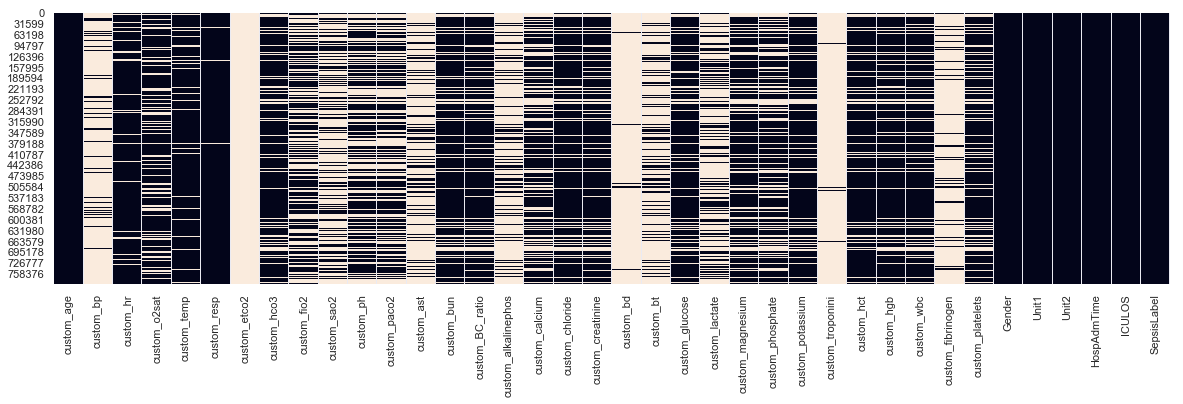

In [3]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(trainA == 'Missing', cbar=False)

In [35]:
lackA = {}
for feature in list(trainA.columns):
    lackA[feature] = len(trainA[trainA[feature] == 'Missing']) / len(trainA[feature])

([<matplotlib.axis.XTick at 0x1a4cfe0be0>,
 <a list of 38 Text xticklabel objects>)

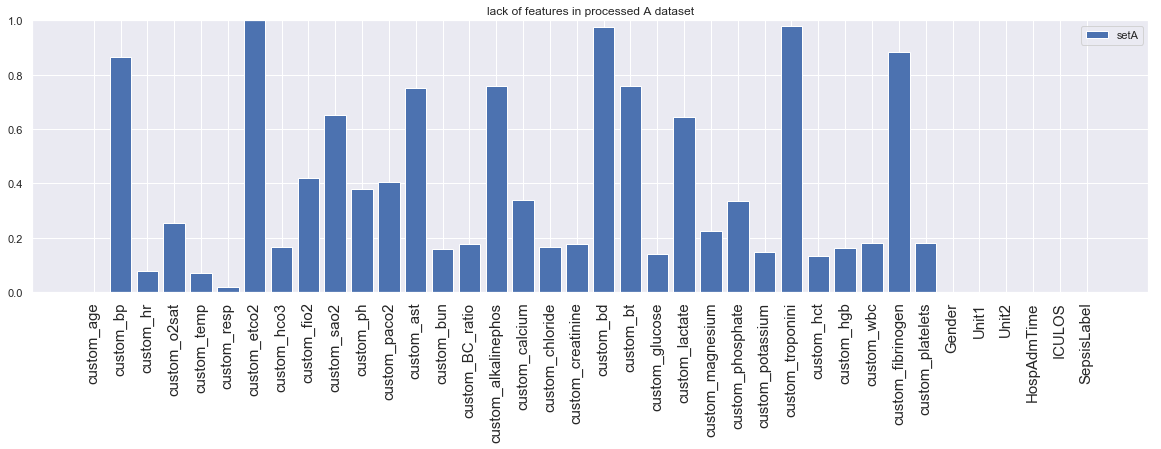

In [65]:
percentage_A = pd.DataFrame.from_dict(lackA, orient='index')
pA = plt.bar(list(trainA.columns), percentage_A[0], label='line')
plt.legend(handles=[pA], labels=['setA'], loc='best')

plt.ylim(ymax=1)
plt.title("lack of features in processed A dataset")
plt.xticks(list(range(len(list(lackA.keys())))), list(lackA.keys()), rotation=90, fontsize=15)

##### B

In [27]:
with open('./data/processedB/trainB_filled.pkl', 'rb') as f:
    trainB = pickle.load(f)

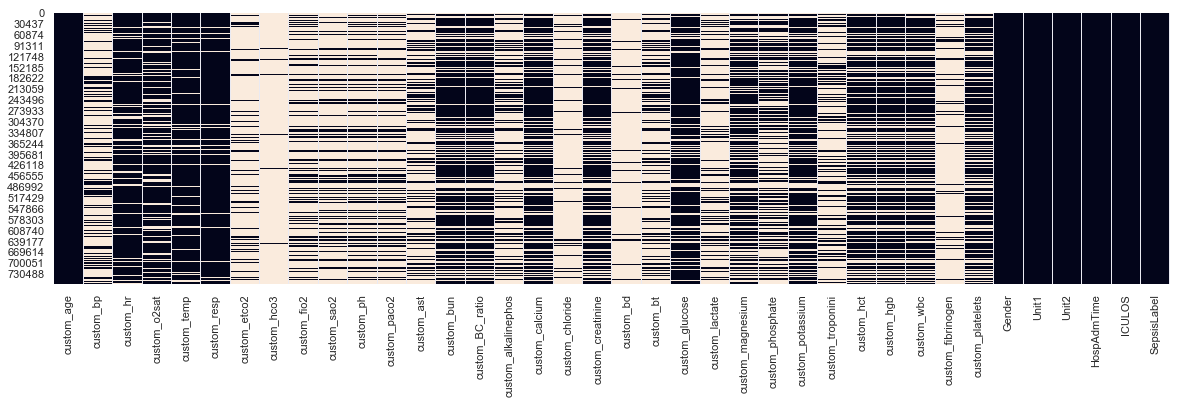

In [18]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(trainB == 'Missing', cbar=False)

In [23]:
lackB = {}
for feature in list(trainB.columns):
    lackB[feature] = len(trainB[trainB[feature] == 'Missing']) / len(trainB[feature])

([<matplotlib.axis.XTick at 0x1a34878908>,
 <a list of 38 Text xticklabel objects>)

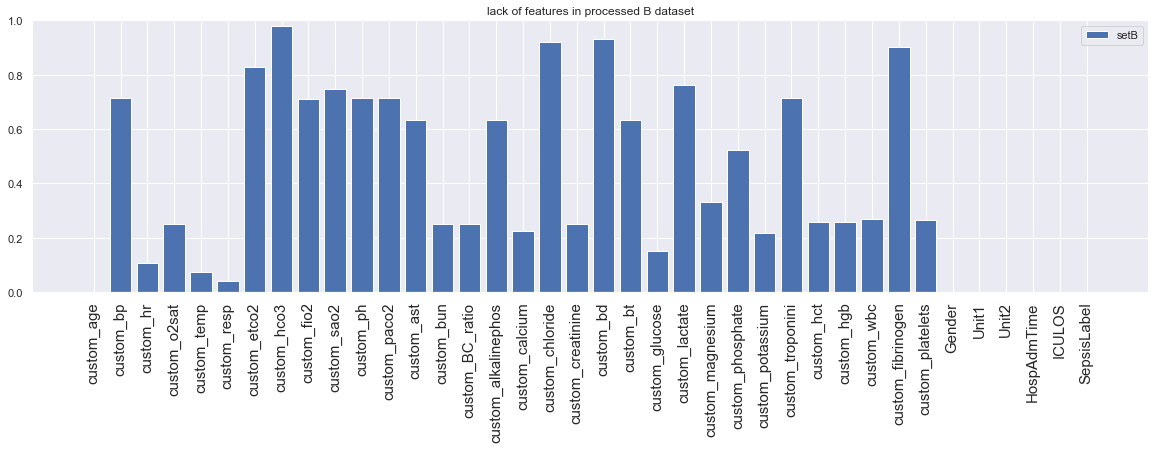

In [66]:
percentage_B = pd.DataFrame.from_dict(lackB, orient='index')
pB = plt.bar(list(trainB.columns), percentage_B[0], label='line')
plt.legend(handles=[pB], labels=['setB'], loc='best')

plt.ylim(ymax=1)
plt.title("lack of features in processed B dataset")
plt.xticks(list(range(len(list(lackB.keys())))), list(lackB.keys()), rotation=90, fontsize=15)

### Multi-Processing(old)

In [54]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
def feature_engineer(train):    
    print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    print('Data processed!')
    
    return train


In [78]:
def generate(i):
    with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        with open(f"./data/A_single/A_single_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    #seed_candidate = list(range(20336))
    seed_candidate = list(range(2890, 2900))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

EOFError: Ran out of input

In [ ]:
def generate(i):
    with open(f'./data/processedB/trainB_{i}.pkl', 'rb') as file:
        tmp = pickle.load(file)
        tmp = feature_engineer(tmp)
        with open(f"./data/B_single/B_single_{i}.pkl", 'wb') as file:
            pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    seed_candidate = list(range(20000))
    func = partial(generate, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

### Multi-Processing(new)

In [4]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS', 'SepsisLabel','Length']


In [5]:
def feature_engineer(train):    
    #print('Begin!')
    train = feature_engineer_age(train)
    train = feature_engineer_blood_pressure(train)
    train = feature_engineer_hr(train)
    train = feature_engineer_o2sat(train)
    train = feature_engineer_temp(train)
    train = feature_engineer_resp_rate(train)
    train = feature_engineer_etco2(train)

    train = feature_engineer_baseexcess(train)
    train = feature_engineer_hco3(train)
    train = feature_engineer_fso2(train)
    train = feature_engineer_ph(train)
    train = feature_engineer_paco2(train)
    train = feature_engineer_ast(train)
    train = feature_engineer_bun(train)
    train = feature_engineer_alkalinephos(train)
    train = feature_engineer_calcium(train)
    train = feature_engineer_chloride(train)
    train = feature_engineer_creatinine(train)
    train = feature_engineer_bilirubin(train)
    train = feature_engineer_glucose(train)
    train = feature_engineer_lactate(train)
    train = feature_engineer_magnesium(train)
    train = feature_engineer_phosphate(train)
    train = feature_engineer_potassium(train)
    train = feature_engineer_troponin(train)
    train = feature_engineer_hct(train)
    train = feature_engineer_hgb(train)
    train = feature_engineer_ptt(train)
    train = feature_engineer_wbc(train)
    train = feature_engineer_fibrinogen(train)
    train = feature_engineer_platelets(train)
    train = feature_engineer_unit(train)
    train = feature_engineer_100(train)
    train = feature_engineer_cut(train)
    #print('Data processed!')
    
    return train


In [15]:
a_traincsv = listdir('./data/trainingA/')

def generateA(i):
    print(i)
    tmp = pd.read_csv('./data/trainingA/' + a_traincsv[i], sep='|')
    tmp = feature_engineer(tmp)

    with open(f"./data/A_100/A_100_{i}.pkl", 'wb') as file:
        pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    seed_candidate = list(range(len(a_traincsv)))
    func = partial(generateA, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

0
424
1272
848
2968
1696
2544
2120
3392
3816
4240
4664
1
3817
2969
1273
4241
3393
1697
425
2545
2121
849
4665
2
1274
4242
2546
3394
2970
1698
2122
426
3818
850
4666
3
1275
2971
2547
2123
3395
3819
427
851
4667
4243
1699
4
2548
1276
2972
2124
3820
428
3396
4244
4668
852
1700
3397
2549
5
1277
3821
429
2125
2973
4245
4669
853
1701
3822
6
4670
3398
430
2550
1278
2974
2126
4246
854
1702
3399
7
2551
431
1279
2975
3823
2127
4247
855
4671
1703
432
3400
2976
2552
3824
1280
2128
8
4248
4672
856
1704
433
3401
1281
2553
4249
3825
2977
2129
9
4673
1705
857
434
3402
1282
2554
4250
2978
2130
3826
10
1706
858
4674
435
3403
1283
4251
2131
3827
11
2979
859
1707
2555
4675
436
3404
1284
12
4252
2132
3828
2980
1708
860
2556
4676
437
3405
1285
13
3829
2133
4253
2981
1709
861
2557
438
3406
4677
1286
4254
2134
14
3830
1710
862
2558
2982
4678
3407
1287
439
4255
15
2135
3831
863
1711
2559
2983
4679
3408
1288
440
4256
2136
16
864
1712
3832
2560
2984
4680
3409
1289
441
4257
17
2137
865
3833
1713
2561
2985
4681
34

571
3537
2266
3113
146
2690
4808
1418
4386
1842
3962
994
572
3538
2267
3114
2691
4809
147
1419
4387
1843
3963
995
573
2268
3115
3539
2692
4810
148
4388
1420
1844
3964
996
574
2269
2693
4811
3540
3116
4389
149
1421
3965
1845
575
997
4812
2694
3541
2270
4390
3117
1422
3966
150
1846
998
576
2695
4813
3542
2271
4391
3118
3967
1423
1847
151
999
4814
2696
577
4392
2272
3543
3119
3968
1424
1848
152
1000
4815
578
2697
2273
1425
3544
4393
3120
3969
153
1849
1001
4816
579
2698
3970
1426
2274
3545
4394
3121
154
1850
1002
2699
580
3971
1427
2275
4817
3546
4395
3122
155
1003
1851
2700
581
3972
2276
3547
1428
4818
4396
3123
156
1004
2701
1852
2277
1429
3548
3973
582
4819
4397
3124
157
2702
1005
1853
1430
3549
2278
4820
583
4398
3974
3125
158
1006
2703
1854
3550
1431
4821
2279
4399
3975
584
159
3126
1007
2704
1855
4822
2280
1432
3551
4400
585
3976
160
3127
1008
2705
1856
1433
2281
3552
4401
586
4823
3977
3128
1009
161
2706
1857
1434
4402
3553
2282
4824
3978
587
3129
1010
162
2707
1858
1435
4403
2283


4528
3677
2831
2407
3255
4950
713
4103
287
1983
1135
1561
4529
2832
4951
2408
3678
3256
714
4104
288
1984
1136
1562
2833
4530
4952
3679
2409
3257
715
289
4105
1137
1985
1563
4953
2410
3680
3258
2834
4531
716
290
4106
1138
1986
1564
2411
3681
3259
4954
2835
4532
4107
717
1139
291
1987
1565
3682
2836
3260
4955
2412
4533
4108
718
292
1140
1988
1566
3683
3261
2413
2837
4956
4534
293
719
1141
4109
1989
3262
3684
1567
2838
2414
4957
4535
720
294
1142
4110
1990
3263
1568
2415
3685
2839
4958
4536
1143
295
721
1569
1991
4111
2416
3264
3686
2840
4537
4959
1144
722
296
1992
1570
4112
2417
3265
2841
3687
4538
4960
1145
723
1993
297
1571
4113
2418
3266
2842
4539
3688
724
4961
1146
1994
298
4114
1572
2419
3267
2843
4540
3689
4962
1995
725
1147
299
4115
2420
1573
2844
3268
3690
4541
4963
1996
726
1148
300
4116
2421
1574
3269
2845
3691
4542
4964
727
1997
1149
301
4117
4543
2422
1575
3692
3270
2846
728
4965
1998
302
4118
1150
2423
3271
1576
4544
3693
2847
729
4966
1999
4119
303
1151
3272
2424
3694
2848

8059
8907
7636
5941
6365
7212
6789
9754
5518
9331
8484
8908
5095
8060
5942
7213
6366
5519
6790
9755
9332
7637
8485
8909
5096
8061
6367
5943
7214
6791
9756
5520
9333
7638
8486
8910
5097
8062
5944
6368
7215
6792
9757
9334
7639
5521
5098
8487
8911
8063
5945
6369
7216
6793
5522
9758
9335
7640
8488
5099
5946
6370
8912
7217
6794
5523
9759
9336
7641
8064
5100
8489
5947
6371
6795
8913
7218
5524
9760
9337
8065
7642
5101
6372
5948
6796
8490
7219
5525
9761
8914
9338
8066
7643
5102
6373
5949
6797
7220
8491
5526
8067
8915
9339
9762
7644
5103
5527
6374
7221
5950
6798
8492
8068
8916
7645
9763
9340
5104
6375
5528
6799
7222
5951
8493
8069
7646
8917
9341
9764
5105
5529
6376
8494
6800
7223
5952
8070
8918
7647
9342
5106
5530
9765
6377
7224
5953
6801
8495
7648
8919
9343
8071
5107
9766
5531
6378
7225
8496
6802
5954
8072
9344
7649
8920
5108
9767
6379
5532
7226
8497
5955
6803
8073
7650
9345
8921
5109
9768
5533
6380
7227
5956
8498
6804
8074
9346
7651
5110
9769
8922
5534
6381
5957
6805
7228
8499
8075
9347
7652


7348
6926
8196
9466
5232
9889
6502
9044
7773
8620
5656
7349
6078
8197
6927
9890
5233
9467
6503
7774
9045
8621
5657
7350
6928
6079
9468
8198
5234
9891
6504
7775
9046
8622
5658
7351
6929
6080
8199
9469
5235
9892
6505
9047
7776
8623
5659
6930
7352
6081
9470
8200
5236
9893
6506
9048
7777
8624
5660
6931
7353
6082
8201
9471
5237
9894
9049
8625
7778
5661
6507
6932
7354
6083
8202
9472
5238
9895
9050
7779
8626
5662
6508
7355
9473
6084
8203
6933
5239
9896
7780
9051
8627
5663
6509
7356
9474
6085
8204
5240
6934
9897
8628
9052
7781
5664
6510
7357
9475
6086
6935
5241
8205
9898
8629
7782
9053
5665
7358
6511
6087
9476
6936
5242
9899
8630
9054
7783
8206
7359
6512
5666
6088
9477
9900
6937
5243
8631
7784
9055
7360
8207
5667
6513
6089
9478
9901
6938
5244
8632
9056
7785
5668
8208
6514
9479
6090
7361
9902
6939
5245
7786
8633
5669
9057
6515
8209
6091
9480
7362
9903
6940
5246
7787
8634
6516
5670
9058
8210
7363
9481
6092
9904
6941
5247
8635
7788
5671
9059
7364
8211
6517
9482
6093
9905
6942
5248
8636
7789
5672


10026
6213
7485
7061
7910
5367
8332
6638
9603
5791
9181
8757
10027
6214
7062
7486
5368
7911
6639
8333
9604
5792
8758
9182
10028
7063
6215
7912
8334
7487
5369
6640
9605
5793
8759
10029
9183
7064
6216
8335
7913
5370
7488
9606
6641
5794
10030
8760
7065
6217
5371
7914
9184
7489
8336
9607
6642
5795
10031
7490
8761
7066
6218
7915
5372
9185
8337
9608
6643
7491
8762
10032
5796
6219
7067
7916
5373
9186
8338
6644
9609
8763
5797
10033
7492
6220
7068
5374
9187
8339
7917
6645
9610
10034
7493
5798
6221
8764
7069
5375
9188
8340
7918
6646
10035
6222
9611
8765
5799
7070
7494
5376
9189
8341
7919
6647
8766
9612
10036
6223
7071
8342
5800
7495
5377
9190
7920
8767
9613
6224
10037
6648
7072
5801
5378
8343
7496
9191
7921
6649
9614
8768
10038
6225
5802
7073
5379
8344
9192
7497
7922
9615
6650
10039
8769
6226
5380
7074
5803
8345
9193
7498
7923
9616
10040
6651
8770
5381
7075
5804
6227
8346
9194
7499
7924
9617
5382
8771
10041
7076
5805
6652
6228
8347
9195
7500
7925
5383
7077
8772
10042
5806
6653
9618
6229
8348
919

7195
8891
10160
8468
5501
8043
6348
6773
9736
9315
7620
8892
5926
8469
10161
7196
5502
8044
6349
9737
6774
9316
7621
8470
5927
8893
7197
10162
5503
8045
9738
6350
9317
7622
6775
8471
5928
7198
8894
10163
5504
8046
9739
6351
9318
6776
7623
8472
5929
7199
8895
10164
5505
9740
8047
6352
9319
6777
7624
7200
8473
5930
10165
8896
5506
8048
9741
6353
7625
7201
9320
8474
6778
10166
5931
8897
5507
8049
9742
6354
9321
7202
7626
10167
8475
5932
6779
8898
5508
8050
9743
6355
9322
7203
7627
8476
10168
5933
6780
8899
5509
8051
9744
6356
9323
7204
8477
10169
7628
5934
6781
8900
5510
8052
6357
9745
10170
9324
7629
8478
5935
7205
8901
5511
6782
8053
6358
10171
9746
9325
7630
8479
10176
7206
8902
10600
6783
8054
10172
6359
9747
9326
7631
11024
10177
7207
8903
10601
11448
10173
11872
9327
9748
8055
12296
10178
11025
10602
12720
13144
11449
10174
11873
9749
13568
13992
12297
10179
12721
11026
13145
10603
11450
10175
11874
9750
13569
13993
12298
10180
11027
13146
10604
12722
11451
14416
11875
9751
13570
13

14938
13247
10705
14093
11976
12399
12823
11128
10283
14517
13671
14939
11553
10706
13248
14094
11977
11129
12400
12824
10284
14518
13672
14940
11554
10707
13249
14095
11978
11130
12401
12825
14519
13673
10285
14941
10708
11555
13250
11131
11979
12826
12402
14096
13674
14520
14942
10709
10286
11556
13251
11980
12827
12403
11132
14097
13675
14943
10710
10287
11557
14521
12828
11981
13252
12404
11133
14098
13676
10711
10288
14944
14522
12829
11558
13253
12405
11982
11134
14099
13677
10289
10712
14523
14945
12830
11559
13254
12406
11983
11135
14100
13678
10290
14946
14524
10713
12831
11560
12407
11984
13255
11136
14101
13679
10291
14525
14947
11561
10714
11985
12408
12832
13256
11137
14102
13680
10292
14948
11562
12409
14526
10715
11986
12833
13257
11138
14103
13681
10293
14949
11563
12410
14527
10716
11987
13258
11139
12834
14104
13682
10294
11988
11564
14950
12411
10717
13259
14528
11140
12835
14105
13683
10295
11989
11565
14951
10718
14529
13260
12412
11141
12836
14106
10296
11990
1368

15050
10818
14631
13361
11242
12091
11666
10397
13785
14207
12937
12514
15051
10819
14632
13362
11243
10398
12092
11667
13786
12938
14208
12515
15052
10820
14633
13363
12093
10399
11668
11244
13787
12939
12516
14209
10821
15053
14634
12094
10400
13788
11245
13364
11669
12517
12940
14210
10822
15054
14635
11246
12095
13789
10401
11670
13365
14211
12518
10823
12941
12096
14636
15055
11247
13790
10402
11671
13366
14212
12519
10824
12942
15056
14637
11248
13791
12097
10403
13367
11672
14213
12520
10825
12943
13792
11249
14638
15057
12098
10404
11673
13368
12521
14214
10826
12944
13793
11250
14639
15058
12099
11674
13369
10405
14215
12522
10827
12945
11251
13794
14640
15059
12100
11675
13370
10406
14216
12523
10828
11252
13795
15060
14641
12101
12946
13371
11676
10407
14217
12524
11253
15061
13796
14642
10829
12947
12102
13372
10408
14218
11677
12525
11254
13797
14643
10830
15062
12948
12103
13373
10409
14219
11678
11255
13798
10831
15063
14644
12526
12949
12104
13374
10410
14220
11679
1125

12205
12627
10510
11357
13474
15164
14745
10933
13899
11780
13051
14320
12206
12628
10511
11358
15165
13475
10934
14746
11781
13052
13900
14321
12207
10512
11359
12629
13476
10935
15166
14747
11782
13053
13901
14322
12208
11360
12630
10513
15167
13477
11783
10936
13902
13054
14748
14323
11361
12209
12631
10514
15168
13478
11784
10937
13055
13903
14749
14324
11362
12210
12632
10515
15169
13479
11785
10938
14750
13904
13056
14325
11363
12211
12633
10516
15170
13480
11786
10939
14751
13057
13905
14326
12212
11364
12634
10517
13481
15171
11787
10940
13906
14752
13058
14327
12635
12213
10518
11365
15172
13482
11788
10941
13059
14753
12636
14328
13907
12214
10519
11366
11789
15173
10942
13483
14754
13060
12637
14329
13908
12215
10520
11367
10943
15174
13484
11790
13061
14755
12638
13909
12216
14330
10521
11368
10944
15175
13485
13062
11791
14756
12639
13910
14331
10522
12217
11369
10945
15176
13486
13063
14757
11792
12640
13911
14332
10523
12218
11370
10946
15177
13487
13064
11793
14758
1433

16558
19098
15711
19521
16135
16982
18676
18253
15289
17829
17405
19942
16559
19099
15712
16136
17830
15290
18254
19522
18677
17406
19943
16983
16560
19100
15713
16137
19523
17831
18255
18678
16561
15291
17407
19944
16984
19101
16138
15714
19524
18256
18679
16562
17832
17408
15292
16985
19945
19102
16139
15715
19525
16563
18257
17833
17409
18680
16986
15293
19946
19103
16140
15716
19526
18258
17834
18681
17410
16987
15294
19947
16564
19104
16141
15717
19527
16988
18259
17835
18682
17411
19948
16565
19105
15295
16142
19528
16989
15718
18260
18683
17836
19949
17412
19106
16566
15296
19529
15719
16990
18261
16143
18684
17837
19950
17413
19107
16567
15297
19530
15720
16144
16991
18262
18685
17838
19951
17414
15298
19108
16568
19531
15721
16145
18263
16992
18686
17839
17415
19952
15299
19109
16569
19532
18264
16146
16993
18687
15722
17840
17416
19953
15300
19110
16570
19533
18265
16147
16994
18688
17841
15723
19111
17417
19954
15301
16571
19534
18266
16148
16995
18689
17842
15724
19112
1741

19212
19634
15402
17096
15824
18789
17942
20056
16673
18368
15825
16249
19213
17520
15403
17097
19635
17943
18790
20057
16674
15826
17521
18369
16250
15404
19214
17098
19636
17944
18791
20058
16675
17522
15827
16251
18370
15405
19637
17099
19215
17945
18792
20059
16676
18371
15406
17523
16252
15828
19216
17100
19638
17946
18793
20060
16677
16253
18372
17524
15829
17101
19217
17947
15407
19639
18794
20061
16678
18373
16254
15830
17525
19218
17102
18795
19640
17948
15408
20062
16679
18374
15831
17526
16255
17103
18796
19219
19641
17949
15409
20063
18375
16680
17527
15832
16256
18797
17104
19220
19642
20064
15410
17950
16681
18376
16257
17528
15833
18798
17105
19221
19643
15411
17951
20065
18377
16258
16682
17529
15834
19644
17106
19222
18799
15412
20066
17952
16259
18378
17530
16683
15835
17107
18800
19223
15413
19645
17953
20067
18379
16260
17531
18801
16684
15836
17108
19224
15414
19646
17954
20068
18380
16261
16685
17532
18802
17109
15837
19225
19647
15415
17955
20069
18381
16262
1668

16786
17632
19326
20171
15936
18056
18903
19749
18482
17210
16363
16787
15517
17633
19327
15937
20172
18057
19750
18904
18483
16364
17211
16788
17634
19328
15518
20173
15938
18058
16365
17212
18905
19751
16789
18484
17635
15519
19329
15939
20174
18059
16366
17213
18906
19752
16790
17636
18485
15520
19330
20175
15940
18060
16367
17214
18907
19753
16791
18486
17637
15521
19331
20176
18061
15941
17215
16368
19754
16792
18908
19332
18487
17638
15522
20177
18062
15942
17216
16369
19755
19333
18909
16793
17639
18488
15523
20178
18063
15943
17217
19756
16370
19334
18910
16794
15524
17640
18489
20179
18064
15944
17218
19757
16371
19335
18490
18911
16795
17641
20180
15525
18065
15945
17219
16372
19336
18491
19758
18912
16796
17642
20181
15526
18066
15946
17220
19337
16373
18492
18913
19759
16797
17643
20182
15527
15947
18067
16374
17221
19338
18914
18493
16798
19760
17644
18068
20183
15528
15948
16375
17222
19339
18915
16799
19761
18494
18069
15529
17645
20184
15949
16376
17223
19340
18916
1976

20285
19862
16476
19440
16050
16901
19016
15631
18595
18171
17746
20286
17324
19863
16477
19441
16051
19017
16902
18596
15632
18172
17747
17325
20287
19864
16478
19442
16052
16903
19018
18597
18173
17748
17326
20288
15633
19865
16479
19443
19019
16904
16053
18598
18174
17749
20289
17327
15634
19866
16480
19444
19020
16905
16054
18599
18175
20290
17750
17328
15635
19867
16481
19021
19445
16906
16055
18176
18600
20291
17751
17329
15636
16482
19868
19022
16907
16056
18177
20292
18601
19446
17752
17330
15637
19869
16483
19023
16908
17753
18178
16057
20293
18602
19447
17331
15638
19870
16484
19024
16909
18179
16058
20294
18603
19448
17754
17332
15639
19871
16485
18180
19025
16910
16059
18604
20295
17755
19449
17333
19872
15640
16486
18181
16060
16911
18605
20296
19450
19026
17756
17334
19873
15641
16487
18182
16061
16912
18606
17757
19451
19027
20297
15642
17335
19874
16488
18183
16062
16913
17758
18607
19452
19028
20298
15643
17336
19875
16489
18184
16063
16914
17759
18608
19453
20299
1902

In [16]:
b_traincsv = listdir('./data/trainingB/')

def generateB(i):
    print(i)
    tmp = pd.read_csv('./data/trainingB/' + b_traincsv[i], sep='|')
    tmp = feature_engineer(tmp)

    with open(f"./data/B_100/B_100_{i}.pkl", 'wb') as file:
        pickle.dump(tmp[feature_to_use], file)
            
def main():

    pool = Pool()
    seed_candidate = list(range(len(b_traincsv)))
    func = partial(generateB, )
    pool.map(func, seed_candidate)
    pool.close()
    pool.join()

main()
    

417
0
1251
834
2085
1668
2502
2919
3336
3753
4170
4587
418
4171
1669
3337
1252
2086
3754
835
2503
2920
1
4588
4172
419
2087
3338
836
1253
3755
2504
2921
1670
2
4589
4173
3339
420
1254
837
2088
3756
2922
1671
2505
4590
3
4174
421
3340
1255
2089
2506
3757
2923
838
1672
4
4591
4175
1256
2090
3341
839
422
1673
2924
2507
5
4592
3758
4176
840
1257
2091
423
2925
3342
1674
2508
6
3759
4593
1258
424
4177
841
2926
2092
1675
7
3343
2509
3760
4594
1259
425
4178
842
2927
2093
1676
3344
8
2510
3761
4595
843
426
1260
4179
2928
2094
9
1677
3345
2511
3762
4596
844
1261
427
4180
2929
1678
3346
10
2095
2512
4597
3763
845
1262
2930
428
1679
4181
11
3347
2096
2513
4598
3764
846
1263
2931
4182
3348
429
1680
2097
12
2514
3765
4599
847
430
1264
4183
2932
3349
2098
1681
13
3766
2515
4600
848
1265
431
2933
4184
1682
14
2099
3350
3767
2516
4601
1266
2934
432
4185
849
2100
1683
15
3768
3351
2517
4602
850
433
1267
2935
4186
2101
1684
3769
16
3352
2518
4603
851
1268
434
2936
4187
1685
2102
17
3770
2519
3353
4604
43

3898
1396
4316
3481
563
2647
980
3065
2231
4733
147
1814
3899
1397
3482
4317
2648
564
981
3066
2232
4734
148
1815
3483
4318
3900
1398
565
982
2649
3067
2233
1816
4735
149
3901
3484
1399
4319
983
566
2650
2234
3068
150
1817
3902
4736
3485
4320
1400
984
567
2651
2235
3069
3903
151
1818
4737
3486
1401
4321
985
568
2236
2652
3070
152
3904
1819
4738
3487
1402
4322
986
569
2237
2653
3071
1820
153
4739
3905
1403
3488
4323
987
570
2238
2654
3072
1821
4740
154
3489
3906
1404
988
4324
571
2239
2655
3073
1822
4741
155
3907
3490
1405
989
4325
572
2240
3074
1823
2656
4742
156
3908
1406
3491
4326
990
573
2657
1824
2241
3075
4743
157
3909
1407
3492
4327
991
574
2658
1825
2242
3076
158
4744
3910
1408
992
4328
3493
575
2243
2659
1826
3077
159
3911
4745
1409
4329
993
3494
576
2244
2660
1827
3078
160
4746
3912
1410
994
4330
577
3495
1828
2661
2245
161
3079
4747
3913
1411
995
4331
3496
578
2246
162
1829
2662
3080
3914
4748
1412
996
4332
3497
579
2247
1830
2663
163
3081
4749
3915
1413
997
4333
580
3498
224

2372
1122
4456
2787
3207
4040
1539
288
3623
706
4875
1956
2373
1123
4457
2788
3208
4041
289
1540
3624
707
4876
1957
2374
1124
4458
2789
3209
4042
1541
290
708
3625
4877
1958
2375
4459
1125
3210
2790
4043
291
709
1542
3626
4878
1959
4460
3211
2376
1126
4044
2791
710
1543
3627
292
4879
1960
2377
3212
4461
1127
4045
2792
1544
711
3628
293
4880
1961
3213
2378
4462
4046
1128
2793
1545
712
3629
4881
294
1962
3214
4463
2379
4047
1129
2794
713
3630
4882
1546
295
1963
3215
4464
2380
4048
2795
1130
3631
714
4883
1547
296
1964
2381
3216
4465
4049
2796
1131
715
3632
4884
1548
1965
297
3217
4466
2382
4050
2797
1132
3633
716
1966
1549
4885
3218
298
4467
2383
4051
2798
1133
3634
717
1967
4886
3219
1550
299
4468
2384
4052
2799
1134
718
4887
3635
1968
3220
1551
300
4469
2385
4053
2800
1135
4888
719
3636
1969
1552
301
3221
4470
2386
4054
2801
4889
720
1136
3637
1970
1553
3222
302
2387
4471
4055
2802
721
4890
1137
1971
3638
1554
3223
303
4472
2388
4056
2803
722
1138
4891
1972
3639
1555
3224
4473
304
2389

7517
7100
9183
6267
8351
9600
8767
7934
5017
5851
5434
6684
7518
7101
9184
8352
8768
6268
9601
7935
5018
5852
5435
6685
7519
8769
9185
7102
8353
6269
9602
7936
5019
5853
5436
6686
7520
9186
8770
7103
6270
8354
9603
7937
5020
5854
5437
6687
7521
6271
8771
7104
9187
9604
8355
7938
5021
5855
5438
6688
7522
8772
6272
9188
9605
7105
8356
5022
7939
5856
5439
6689
6273
7523
8773
9189
7106
8357
9606
5023
7940
5857
5440
6274
6690
8774
7524
9190
8358
7107
9607
5024
7941
5858
6275
6691
5441
8775
7525
9608
8359
5025
7108
9191
7942
5859
6276
5442
6692
7526
8776
9609
8360
7109
5026
9192
7943
5860
6277
5443
7527
6693
8777
7110
5027
9610
8361
9193
7944
5861
6278
6694
8778
7528
5444
7111
5028
9611
8362
9194
5862
7945
6279
6695
8779
7529
5445
5029
7112
8363
9195
7946
9612
5863
6280
6696
7530
8780
5446
5030
7113
8364
9196
5864
6281
9613
7947
6697
8781
5447
7531
5031
6282
7114
8365
9197
5865
9614
7948
5448
6698
8782
7532
5032
7115
6283
9198
8366
9615
5866
7949
5449
8783
6699
7533
7116
9199
5033
8367
6284


9736
8904
6819
7236
7654
9321
6404
5154
5988
8488
8070
5570
9737
6820
8905
7237
7655
9322
6405
5155
5989
8489
8071
9738
5571
8906
6821
7656
7238
9323
6406
5156
5990
8490
8072
9739
8907
5572
6822
7239
7657
6407
9324
5157
5991
8491
5573
8073
8908
7240
6823
9740
7658
9325
6408
5158
5992
8074
5574
7241
8492
8909
7659
6824
9741
9326
5159
6409
5993
8075
7242
8493
8910
5575
7660
9742
6825
9327
5160
6410
5994
7243
8494
8076
8911
7661
9743
5576
6826
9328
5161
6411
5995
8912
7244
8077
8495
9744
5577
7662
6827
9329
5162
6412
5996
8078
8913
7245
8496
9745
5578
7663
6828
9330
5163
6413
5997
8914
8079
8497
5579
9746
7246
7664
6829
9331
5164
6414
5998
8915
8080
8498
9747
7247
5580
7665
6830
9332
5165
6415
5999
8916
8499
8081
7248
7666
5581
9748
6831
9333
5166
6416
6000
8917
8500
7249
8082
9749
5582
6832
7667
9334
5167
6417
6001
7250
8918
9750
8083
8501
5583
6833
7668
9335
5168
6418
6002
8919
9751
7251
5584
8502
6834
7669
8084
9336
5169
6419
6003
8920
7252
9752
5585
8503
9337
6835
5170
8085
7670
6420


6956
8624
8206
9458
5706
9041
6125
7791
6540
9873
7373
5290
6957
8625
8207
9459
5707
9042
6541
6126
7792
9874
7374
5291
6958
8626
9460
8208
5708
9043
6542
7793
6127
9875
5292
7375
6959
8627
9461
5709
8209
9044
6543
6128
7794
5293
7376
9876
6960
8628
9462
8210
7795
5710
6544
9045
6129
5294
7377
9877
6961
8629
8211
9463
7796
5711
6545
9046
6130
7378
5295
6962
9878
8630
8212
5712
9464
7797
9047
6546
5296
7379
6131
6963
8631
9879
8213
7798
9465
5713
9048
6547
5297
6132
7380
6964
8632
9880
8214
9466
5714
7799
9049
6548
6133
5298
7381
6965
8633
9881
8215
7800
9050
9467
5715
6549
5299
6134
7382
8634
9882
6966
8216
5716
7801
9468
9051
6550
5300
9883
8635
6135
7383
6967
8217
5717
9469
7802
9052
6551
5301
9884
8636
6136
7384
6968
8218
9470
5718
7803
9053
6552
5302
9885
6137
8637
7385
6969
9471
8219
7804
6553
5719
5303
9054
9886
8638
6138
6970
7386
9472
8220
5720
7805
6554
9055
5304
9887
6139
8639
7387
6971
9473
8221
5721
6555
7806
9056
5305
9888
6140
8640
7388
6972
9474
8222
9057
6556
5722
7807


10013
12096
14595
10430
10846
11680
11263
14180
12930
13764
13347
12513
10014
12097
14596
10431
11681
10847
11264
12931
14181
13348
12514
13765
10015
12098
14597
10432
10848
11682
11265
12932
14182
13349
12515
13766
10016
12099
14598
10433
10849
11683
11266
12933
14183
13350
12516
13767
12100
10017
14599
10434
11684
10850
11267
14184
12934
12101
13351
12517
13768
10018
14600
10435
10851
11685
11268
14185
12935
13352
12102
12518
13769
10019
14601
10436
10852
11686
11269
12936
14186
13353
12103
12519
10020
13770
14602
10437
11687
10853
11270
12937
14187
13354
12104
13771
12520
10021
14603
10438
11688
10854
11271
12938
14188
13355
12105
13772
12521
10022
10439
14604
11689
11272
10855
12939
13356
14189
12106
13773
12522
10023
14605
10440
11273
11690
10856
14190
12940
13357
12107
13774
12523
10024
10441
14606
11691
11274
10857
14191
12941
13358
12524
12108
13775
14607
10025
11692
10442
10858
14192
13359
12942
11275
12525
12109
13776
14608
10026
11693
10443
10859
13360
12943
11276
14193
1211

12626
11376
10127
14710
11795
13043
10544
14294
12211
10959
13877
13461
12627
11377
10128
14711
13044
10545
11796
14295
10960
12212
13878
13462
12628
11378
10129
10546
13045
14712
11797
14296
10961
12213
13879
13463
12629
11379
10547
13046
14713
11798
14297
10130
10962
13880
12214
13464
12630
11380
14714
13047
10548
14298
11799
10131
10963
13881
12215
13465
12631
11381
14715
10549
13048
11800
14299
10132
10964
13882
12216
13466
12632
14716
11382
10550
13049
11801
14300
10965
10133
13883
12217
13467
12633
14717
10551
11383
13050
14301
11802
10966
10134
13884
13468
12218
12634
14718
11384
10552
13051
14302
10967
10135
11803
12219
13469
13885
12635
14719
13052
11385
10553
14303
11804
10968
10136
12220
13470
13886
14720
13053
12636
10554
11386
10969
14304
11805
10137
12221
13887
13471
14721
13054
12637
11387
10555
10970
14305
11806
10138
12222
13888
13472
14722
12638
13055
10556
11388
11807
10971
14306
10139
13889
12223
13473
14723
13056
12639
10557
11389
14307
10972
11808
10140
12224
1389

11489
14823
11909
14408
10658
13991
13574
12325
10241
12741
11074
13156
11490
14824
11910
14409
10659
12326
13992
13575
12742
10242
13157
11075
11491
14825
14410
11911
10660
13993
12327
13576
12743
10243
13158
11076
11492
14826
14411
11912
10661
13577
13994
12328
12744
13159
11077
10244
14827
14412
11493
11913
10662
13578
13995
12329
12745
13160
11078
10245
14413
14828
11494
11914
10663
13579
13996
12330
11079
12746
13161
10246
14414
11495
14829
11915
10664
13580
13997
12331
11080
12747
13162
10247
14415
11496
14830
11916
10665
13581
13998
12332
11081
10248
13163
12748
14416
11497
11917
14831
10666
13582
13999
12333
11082
10249
12749
13164
11498
14417
11918
14832
13583
10667
14000
11083
10250
12334
12750
13165
14418
11499
11919
14833
13584
10668
14001
11084
12335
10251
12751
13166
11500
14419
11920
14834
10669
13585
14002
12336
11085
10252
12752
13167
11501
14420
11921
10670
13586
14835
14003
12337
10253
11086
12753
13168
11502
11922
14421
13587
10671
14004
14836
12338
10254
12754
1108

10772
14936
14103
12855
11603
10354
12439
13270
14522
12024
11189
10773
13688
14937
14104
11604
12856
10355
13271
12440
12025
14523
11190
10774
13689
14938
14105
14524
12857
10356
11605
13272
12026
12441
11191
13690
10775
14939
14106
14525
10357
12858
11606
13273
13691
12442
12027
11192
14940
10776
14107
14526
10358
12859
11607
13274
12443
13692
12028
11193
10777
14941
14527
11608
14108
12860
10359
12444
13275
12029
13693
11194
10778
14942
11609
14528
14109
10360
12030
12861
13276
12445
13694
11195
10779
14943
11610
14529
10361
14110
12031
12862
12446
13277
13695
11196
10780
14944
11611
14530
14111
10362
12032
12863
12447
13278
13696
11197
10781
14945
11612
14531
10363
14112
12033
12448
12864
13279
11198
13697
14946
10782
11613
14113
10364
14532
12449
12034
13280
12865
11199
13698
14947
10783
11614
14114
10365
14533
12450
12035
12866
13281
11200
14948
10784
13699
11615
14115
14534
10366
12451
12036
13282
12867
11201
10785
13700
14949
11616
14535
14116
10367
12452
12037
12868
13283
1370

16306
15890
17555
15472
19220
16723
17139
18389
17972
19638
15056
18805
16307
15891
17556
15473
19221
17140
18390
16724
17973
19639
15057
16308
18806
15892
15474
17557
19222
17141
16725
18391
17974
19640
15058
16309
18807
15893
15475
17558
19223
17142
18392
16726
16310
19641
17975
15059
18808
15894
15476
17559
17143
19224
18393
16727
19642
16311
17976
18809
15060
15895
17560
15477
17144
19225
18394
16728
17977
16312
19643
18810
15061
15896
17561
15478
17145
18395
16729
19644
19226
17978
16313
18811
15062
15897
17562
15479
17146
18396
19645
16730
19227
17979
16314
18812
15063
17563
15898
15480
17147
18397
16315
19646
16731
19228
17980
18813
15064
17564
15899
15481
17148
18398
17981
16732
19647
16316
19229
15065
18814
17565
18399
15900
17149
19648
15482
17982
16733
16317
19230
15066
18815
17566
18400
15901
15483
17150
19649
16734
17983
16318
19231
15067
18816
17567
18401
15484
15902
17151
19650
16735
17984
19232
16319
15068
18817
17568
18402
15903
17152
16736
15485
17985
19651
19233
1632

17253
16837
18503
18918
18085
17669
15586
19752
19333
15170
16421
16004
17254
18504
16838
18919
18086
15587
17670
19753
19334
15171
16422
16839
16005
18505
17255
18920
18087
15588
17671
19754
19335
16006
15172
16840
18506
16423
17256
18921
15589
17672
18088
19755
16007
19336
15173
16841
16424
18507
17257
18922
17673
18089
15590
19756
19337
16008
15174
16842
16425
18508
17258
18923
17674
18090
15591
19757
19338
16009
16426
16843
15175
18509
18924
17259
17675
18091
15592
19339
19758
16010
16427
16844
18510
15176
18925
17676
17260
18092
15593
19759
19340
16011
17677
16428
16845
15177
18511
18926
15594
18093
17261
19760
19341
16012
16846
16429
17678
15178
18512
18927
17262
15595
18094
19761
16013
16847
16430
15179
18513
19342
17679
18928
15596
18095
17263
19762
16014
16848
15180
16431
18514
17680
19343
15597
18929
18096
19763
17264
16849
16015
16432
18515
15181
17681
15598
19344
18930
18097
19764
17265
16850
16433
16016
15182
17682
18516
19345
15599
18931
19765
17266
18098
16851
16434
1601

15700
17783
16534
19446
19866
15283
17367
18617
18199
19032
16952
16118
15701
17784
19447
16535
19867
15284
18618
17368
18200
19033
16953
16119
15702
17785
16536
19448
15285
19868
18619
17369
19034
18201
16954
16120
15703
17786
16537
19449
15286
19869
18620
17370
18202
19035
16955
15704
16121
17787
16538
19450
15287
19870
17371
18621
19036
18203
15705
16956
17788
16539
16122
15288
19451
18622
17372
19871
19037
18204
15706
17789
16957
16540
16123
15289
19452
17373
19872
18623
19038
18205
15707
17790
16958
16124
16541
15290
19453
17374
18624
19873
19039
18206
15708
17791
16959
16542
15291
16125
19454
17375
18625
19874
19040
18207
15709
17792
16960
15292
16126
16543
19455
17376
18626
19875
19041
18208
15710
17793
16961
16127
16544
15293
19456
17377
18627
19876
19042
18209
15711
16962
17794
16128
15294
16545
19457
18628
17378
19877
18210
19043
15712
17795
16963
16129
15295
16546
19458
17379
18629
19878
19044
18211
15713
17796
16964
15296
16130
16547
18630
17380
19459
19879
19045
15714
1821

16231
18730
16648
17065
17898
15398
19979
17481
19146
19560
15814
18313
16232
18731
16649
17066
17899
17482
19980
15815
15399
19147
19561
18314
16233
18732
17067
16650
17483
17900
19981
15816
15400
19148
19562
18315
16234
18733
16651
17068
17484
17901
15817
15401
19982
19149
19563
18316
16235
18734
17902
16652
17069
17485
19983
15402
15818
19150
19564
18317
16236
18735
17903
16653
15403
17070
17486
19984
15819
19151
18318
16237
19565
18736
17904
15404
16654
17071
17487
15820
19985
19152
18319
16238
19566
18737
17905
15405
17072
16655
15821
19986
17488
19153
18320
16239
19567
18738
17906
16656
15406
17073
15822
17489
19987
18321
19154
16240
19568
18739
17907
16657
17074
15823
15407
17490
19988
18322
19155
16241
18740
19569
16658
17908
17075
15824
15408
17491
19989
19156
18323
16242
18741
19570
16659
17909
15825
17076
17492
19990
15409
19157
18324
16243
18742
16660
17910
19571
15826
17493
17077
15410
19991
19158
18325
18743
16244
16661
17911
19572
15827
17078
15411
17494
19159
18326
1999

In [ ]:
# fix 0 bytes files generated
def generate1(fix_list):
    for i in tqdm(fix_list):
        with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
            tmp = pickle.load(file)
            tmp = feature_engineer(tmp)
            with open(f"./data/A_single/A_single_{i}.pkl", 'wb') as file:
                pickle.dump(tmp[feature_to_use], file)

def generate2(fix_list):
    for i in tqdm(fix_list):
        try:
            with open(f'./data/processedA/trainA_{i}.pkl', 'rb') as file:
                tmp = pickle.load(file)
                tmp = feature_engineer(tmp)
            with open(f"./data/A_100/A_100_{i}.pkl", 'wb') as file:
                pickle.dump(tmp[feature_to_use], file)
        except:
            print(i)
        
                    
def get_number(path):
    for i in range(len(path)):
        name = ''
        for char in path[i]:
            if char.isdigit():
                name += char
        if len(name) == 0:
            print(path[i])
            continue
        else:
            path[i] = name
    return path
    
def fix_data():
    
    # processed ➡️ single 
    # processed ➡️ cut
    cut = get_number(listdir('./data/A_100/'))
    processed = get_number(listdir('./data/processedA/'))
    
    processed.remove('trainA_filled.pkl')
    processed.remove('trainA.pkl')
    while '.DS_Store' in processed:
        processed.remove('.DS_Store')
        
    single = get_number(listdir('./data/A_single/'))
    print(len(cut), len(processed), len(single))
    fix1 = list(set(processed).difference(set(single)))
    fix2 = list(set(processed).difference(set(cut)))
    generate1(fix1)
    generate2(fix2)
    

fix_data()

0it [00:00, ?it/s]
  0%|          | 0/20236 [00:00<?, ?it/s]

.DS_Store
trainA_filled.pkl
.DS_Store
trainA.pkl
.DS_Store
20265 20336 20337


  0%|          | 18/20236 [00:06<1:41:23,  3.32it/s]

16542


  1%|          | 176/20236 [01:07<2:11:58,  2.53it/s]Process ForkPoolWorker-54:


19702


Process ForkPoolWorker-57:
Process ForkPoolWorker-50:
Process ForkPoolWorker-52:
Process ForkPoolWorker-60:
Process ForkPoolWorker-59:
Process ForkPoolWorker-49:
Process ForkPoolWorker-53:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-56:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most rec

16324

  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File 

  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessin

913


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  1%|          | 180/20236 [01:07<1:19:10,  4.22it/s]  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


8053


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3

  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-71:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Keyb

913


  1%|          | 187/20236 [01:11<1:58:05,  2.83it/s]Process ForkPoolWorker-82:
Process ForkPoolWorker-80:
Process ForkPoolWorker-73:
Process ForkPoolWorker-72:
Process ForkPoolWorker-78:
Process ForkPoolWorker-77:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-74:
Process ForkPoolWorker-83:
Process ForkPoolWorker-75:
Process ForkPoolWorker-81:
Traceback (most recent call last):


9623


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  1%|          | 188/20236 [01:11<1:44:28,  3.20it/s]Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


11317


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):


1652

  1%|          | 189/20236 [01:11<1:31:10,  3.66it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


  1%|          | 190/20236 [01:11<1:19:15,  4.22it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


19615


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/mult

13631


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  1%|          | 192/20236 [01:12<1:07:09,  4.97it/s]  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


391


  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  1%|          | 193/20236 [01:12<1:01:42,  5.41it/s]  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


5894


  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  1%|          | 194/20236 [01:12<1:00:22,  5.53it/s]KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


19368


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  1%|          | 195/20236 [01:12<56:52,  5.87it/s]  KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


9821


  1%|          | 196/20236 [01:12<56:36,  5.90it/s]KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


8484


KeyboardInterrupt
  1%|          | 197/20236 [01:12<54:35,  6.12it/s]

8053


Process ForkPoolWorker-84:
Process ForkPoolWorker-85:


14206


Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  1%|          | 198/20236 [01:12<55:12,  6.05it/s]  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/

5280


Process ForkPoolWorker-86:
  1%|          | 199/20236 [01:13<56:35,  5.90it/s]Process ForkPoolWorker-87:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


7487


  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  1%|          | 200/20236 [01:13<56:32,  5.91it/s]

11317


KeyboardInterrupt
Process ForkPoolWorker-88:
Process ForkPoolWorker-89:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


8261


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  1%|          | 201/20236 [01:13<57:14,  5.83it/s]  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line

8363


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


  1%|          | 202/20236 [01:13<55:25,  6.02it/s]KeyboardInterrupt
Process ForkPoolWorker-90:
Process ForkPoolWorker-91:
Traceback (most recent call last):


17092


Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  1%|          | 203/20236 [01:13<54:04,  6.17it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:


280


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-92:
  1%|          | 204/20236 [01:14<1:10:38,  4.73it/s]Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/p

20124


KeyboardInterrupt


13631


Process ForkPoolWorker-93:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  1%|          | 205/20236 [01:14<1:06:42,  5.00it/s]

7738


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  1%|          | 206/20236 [01:14<1:01:13,  5.45it/s]Process ForkPoolWorker-94:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


13321


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  1%|          | 207/20236 [01:14<59:59,  5.56it/s]    File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


5894
1347


Process ForkPoolWorker-95:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  1%|          | 208/20236 [01:14<58:08,  5.74it/s]KeyboardInterrupt


19368


Process ForkPoolWorker-96:
Traceback (most recent call last):


6403


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  1%|          | 209/20236 [01:14<58:00,  5.75it/s]  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


8209


KeyboardInterrupt


9821


Process ForkPoolWorker-97:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-98:
  1%|          | 210/20236 [01:15<55:38,  6.00it/s]Process ForkPoolWorker-99:
Traceback (most rec

1027


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  1%|          | 211/20236 [01:15<55:10,  6.05it/s]  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line

5280


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-101:
Process ForkPoolWorker-100:


7991


  1%|          | 212/20236 [01:15<54:42,  6.10it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


8564


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxl

16830
7487


Process ForkPoolWorker-102:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  1%|          | 214/20236 [01:15<53:10,  6.28it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


8261
18503


  1%|          | 215/20236 [01:15<51:53,  6.43it/s]Process ForkPoolWorker-103:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


17970


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


8363


Process ForkPoolWorker-104:
  1%|          | 216/20236 [01:16<53:56,  6.19it/s]Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()


1837


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


17092


Process ForkPoolWorker-105:
Traceback (most recent call last):
  1%|          | 217/20236 [01:16<53:44,  6.21it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


15926


KeyboardInterrupt
  1%|          | 218/20236 [01:16<52:46,  6.32it/s]

280


Process ForkPoolWorker-106:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


13164


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-107:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  1%|          | 219/20236 [01:16<53:26,  6.24it/s]  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 40

10439


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


13321


Process ForkPoolWorker-110:
Process ForkPoolWorker-109:
Traceback (most recent call last):
Traceback (most recent call last):
  1%|          | 220/20236 [01:16<52:31,  6.35it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


4941


  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-111:
Process ForkPoolWorker-112:
  1%|          |

7644


  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  1%|          | 222/20236 [01:16<52:38,  6.34it/s]  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


4622
8209


Process ForkPoolWorker-113:
Process ForkPoolWorker-114:
Traceback (most recent call last):
  1%|          | 223/20236 [01:17<52:23,  6.37it/s]Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


11903


  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  1%|          | 224/20236 [01:17<52:07,  6.40it/s]  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


975


  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


1027


  1%|          | 225/20236 [01:17<52:28,  6.36it/s]Process ForkPoolWorker-115:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


14906


  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  1%|          | 226/20236 [01:17<52:12,  6.39it/s]  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


7991


Process ForkPoolWorker-116:


11843


Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  1%|          | 227/20236 [01:17<51:19,  6.50it/s]  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


17747


KeyboardInterrupt
Process ForkPoolWorker-117:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-118:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiproc

18503


Process ForkPoolWorker-119:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-121:
Process ForkPoolWorker-120:
Traceback (most recent call last):
Traceback (most recent call last

15926


Process ForkPoolWorker-123:
Process ForkPoolWorker-124:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3

13164


Process ForkPoolWorker-126:
Process ForkPoolWorker-125:
Traceback (most recent call last):
Traceback (most recent call last):
  1%|          | 228/20236 [01:18<2:02:41,  2.72it/s]  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line

10439


Process ForkPoolWorker-127:
Process ForkPoolWorker-128:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3

4941


Process ForkPoolWorker-129:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


7644


Process ForkPoolWorker-130:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


4622


Process ForkPoolWorker-131:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


# Classification

### one-hot

In [13]:
with open('./data/processedA/trainA_filled.pkl', 'rb') as f:
    train = pickle.load(f)

In [4]:
encoder = LabelEncoder()
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
#                  'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
#                  'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
for c in tqdm(custom):
    train[c][0:len(train[c])] = encoder.fit_transform(train[c][0:len(train[c])])


100%|██████████| 26/26 [00:12<00:00,  3.71it/s]


In [33]:
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']
encoded_x = None
for f in custom:
    print(f)
    enc = OneHotEncoder()
    fff = train[f].to_numpy().reshape(train[f].shape[0], 1)
    enc.fit(fff)
    array = enc.transform(fff).toarray()
    if encoded_x is None:
        encoded_x = array
    else:
        encoded_x = np.concatenate((encoded_x, array), axis=1)
    

custom_age
custom_hr
custom_o2sat
custom_temp
custom_resp
custom_hco3
custom_fio2
custom_ph
custom_paco2
custom_bun
custom_BC_ratio
custom_calcium
custom_chloride
custom_creatinine
custom_glucose
custom_magnesium
custom_phosphate
custom_potassium
custom_hct
custom_hgb
custom_wbc
custom_platelets
Gender
Unit
HospAdmTime


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [40]:
#vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
                 'custom_paco2', 'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']
# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = pd.DataFrame(encoded_x[train['SepsisLabel'] == 1])
data_0 = pd.DataFrame(encoded_x[train['SepsisLabel'] == 0])
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel']
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### 不带one-hot

In [6]:
with open('./data/AB100.pkl', 'rb') as f:
    train = pickle.load(f)

In [20]:
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
#                  'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
#                  'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
# custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
#                  'custom_paco2', 'custom_bun', 'custom_BC_ratio',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']

custom_ = copy.deepcopy(custom)
custom_.remove('HospAdmTime')
custom_.remove('ICULOS')

encoder = {}

for c in tqdm(custom_):
    
    encoder[c] = LabelEncoder()
    train[c][0:len(train[c])] = encoder[c].fit_transform(train[c][0:len(train[c])])

output = open(f'./Encoder_{NOW}.pkl', 'wb')
pickle.dump(encoder, output)
output.close()
#scaler = MinMaxScaler(feature_range=(0, 1))
#train[custom] = scaler.fit_transform(train[custom])
    

100%|██████████| 22/22 [00:06<00:00,  3.75it/s]


In [21]:
#vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
# custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
#                  'custom_resp', 'custom_hco3', 'custom_fio2', 'custom_ph',
#                  'custom_paco2', 'custom_bun', 'custom_BC_ratio',
#                  'custom_calcium', 'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = train[train['SepsisLabel'] == 1][custom]
data_0 = train[train['SepsisLabel'] == 0][custom]
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel'] # todo
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### XGBOOST

In [201]:
def custom_loss(y_pre,D_label): #别人的自定义损失函数
    label=D_label.get_label()
    penalty=2.0
    grad=-label/y_pre+penalty*(1-label)/(1-y_pre) #梯度
    hess=label/(y_pre**2)+penalty*(1-label)/(1-y_pre)**2 #2阶导
    return grad,hess


SyntaxError: invalid character in identifier (<ipython-input-201-3573965e7820>, line 2)

[0]	train-auc:0.800708
[1]	train-auc:0.810588
[2]	train-auc:0.814009
[3]	train-auc:0.813133
[4]	train-auc:0.815035
[5]	train-auc:0.815553
[6]	train-auc:0.817389
[7]	train-auc:0.818354
[8]	train-auc:0.819188
[9]	train-auc:0.820955
[10]	train-auc:0.822073
[11]	train-auc:0.825929
[12]	train-auc:0.828423
[13]	train-auc:0.827949
[14]	train-auc:0.82749
[15]	train-auc:0.827449
[16]	train-auc:0.827171
[17]	train-auc:0.826828
[18]	train-auc:0.827676
[19]	train-auc:0.828381
[20]	train-auc:0.828778
[21]	train-auc:0.828966
[22]	train-auc:0.829002
[23]	train-auc:0.828764
[24]	train-auc:0.828991
[25]	train-auc:0.829175
[26]	train-auc:0.830029
[27]	train-auc:0.829773
[28]	train-auc:0.830501
[29]	train-auc:0.83105
[30]	train-auc:0.831286
[31]	train-auc:0.83119
[32]	train-auc:0.831053
[33]	train-auc:0.830729
[34]	train-auc:0.8314
[35]	train-auc:0.83174
[36]	train-auc:0.832042
[37]	train-auc:0.832272
[38]	train-auc:0.83248
[39]	train-auc:0.832763
[40]	train-auc:0.833344
[41]	train-auc:0.833445
[42]	trai

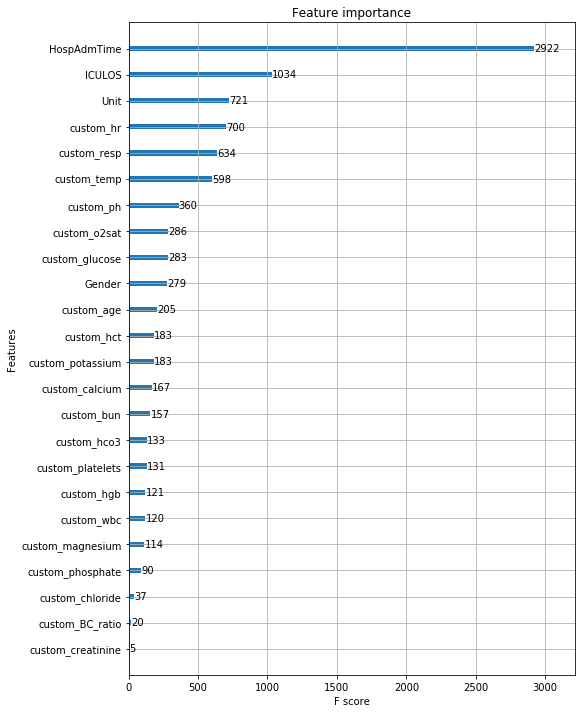

In [22]:
# 模型初始化设置
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# booster:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 7,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.025,
          'seed': 0,
          'nthread': 8,
          'silent': 1,
          'gamma': 0.15,
          'learning_rate': 0.01}

watchlist = [(dtrain, 'train')]

# 建模与预测:NUM_BOOST_round迭代次数和数的个数一致
bst = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist,) #obj=custom_loss, maximize=False)
now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))
bst.save_model(f'xgb_{NOW}.model')

ypred = bst.predict(dtest)

# 设置阈值, 输出一些评价指标，>0.5预测为1，其他预测为0
y_pred = (ypred >= 0.47)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))
metrics.confusion_matrix(test_y, y_pred)


mpl.rcParams['font.sans-serif'] = ['SimHei']
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(8, 12)

In [80]:
for t in range(10,100):
    y_pred = (ypred >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
    print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))

0.1
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.11
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.12
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.13
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.14
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.15
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.16
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.17
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.18
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.19
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.2
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.21
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.22
AUC: 0.8363
ACC: 0.5000
Recall: 1.0000
F1-score: 

In [10]:
y_pred = bst.predict(dtest)
y_pred = (ypred >= 0.5)*1
df = pd.DataFrame(y_pred, columns = ['0'])


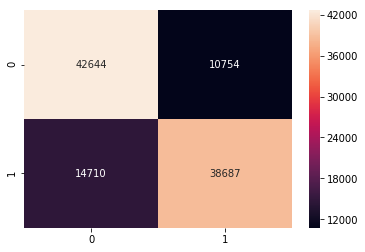

In [11]:
conf_matrix = confusion_matrix(pd.DataFrame(test_y)['SepsisLabel'], df['0'])
sns.heatmap(conf_matrix, annot=True, fmt="d");

### LGBM

Start training...
[1]	valid_0's auc: 0.73541	valid_0's binary_logloss: 0.673683
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.750084	valid_0's binary_logloss: 0.658468
[3]	valid_0's auc: 0.776011	valid_0's binary_logloss: 0.643324
[4]	valid_0's auc: 0.777863	valid_0's binary_logloss: 0.630795
[5]	valid_0's auc: 0.780368	valid_0's binary_logloss: 0.621615
[6]	valid_0's auc: 0.7825	valid_0's binary_logloss: 0.612192
[7]	valid_0's auc: 0.7815	valid_0's binary_logloss: 0.6051
[8]	valid_0's auc: 0.780756	valid_0's binary_logloss: 0.599132
[9]	valid_0's auc: 0.784234	valid_0's binary_logloss: 0.592895
[10]	valid_0's auc: 0.786723	valid_0's binary_logloss: 0.587952
[11]	valid_0's auc: 0.787763	valid_0's binary_logloss: 0.584381
[12]	valid_0's auc: 0.789202	valid_0's binary_logloss: 0.580489
[13]	valid_0's auc: 0.79031	valid_0's binary_logloss: 0.577333
[14]	valid_0's auc: 0.791894	valid_0's binary_logloss: 0.574489
[15]	valid_0's auc: 0.794234	valid_0's b

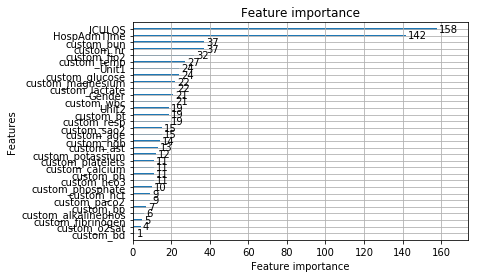

In [210]:
test_X, val_x, test_Y, val_y = train_test_split(
    test_x, 
    test_y, 
    test_size=0.25,
    random_state=0, 
    stratify=test_y ## 这里保证分割后y的比例分布与原数据一致
)

X_train = train_x
y_train = train_y

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 5,
    'max_depth': 6,
    'min_data_in_leaf': 450,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'lambda_l1': 1,  
    'lambda_l2': 0.001,  # 越小l2正则程度越高
    'min_gain_to_split': 0.2,
    'verbose': 5,
    'is_unbalance': True
}
 
# train
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
 
print('Start predicting...')
 
preds = gbm.predict(test_X, num_iteration=gbm.best_iteration)  # 输出的是概率


y_pred = (preds >= 0.36)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))
metrics.confusion_matrix(test_Y, y_pred)

# 绘制特征重要性

lgb.plot_importance(gbm)

In [211]:
for t in range(10,100):
    y_pred = (preds >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
    print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))

0.1
AUC: 0.5298
ACC: 0.5299
Recall: 0.9984
F1-score: 0.6799
Precesion: 0.5155
0.11
AUC: 0.5387
ACC: 0.5387
Recall: 0.9971
F1-score: 0.6837
Precesion: 0.5202
0.12
AUC: 0.5477
ACC: 0.5478
Recall: 0.9953
F1-score: 0.6876
Precesion: 0.5252
0.13
AUC: 0.5568
ACC: 0.5569
Recall: 0.9938
F1-score: 0.6916
Precesion: 0.5304
0.14
AUC: 0.5663
ACC: 0.5663
Recall: 0.9912
F1-score: 0.6957
Precesion: 0.5359
0.15
AUC: 0.5735
ACC: 0.5736
Recall: 0.9888
F1-score: 0.6987
Precesion: 0.5402
0.16
AUC: 0.5838
ACC: 0.5838
Recall: 0.9860
F1-score: 0.7032
Precesion: 0.5465
0.17
AUC: 0.5927
ACC: 0.5928
Recall: 0.9839
F1-score: 0.7073
Precesion: 0.5521
0.18
AUC: 0.6019
ACC: 0.6020
Recall: 0.9816
F1-score: 0.7115
Precesion: 0.5580
0.19
AUC: 0.6118
ACC: 0.6119
Recall: 0.9774
F1-score: 0.7158
Precesion: 0.5646
0.2
AUC: 0.6217
ACC: 0.6217
Recall: 0.9730
F1-score: 0.7201
Precesion: 0.5715
0.21
AUC: 0.6296
ACC: 0.6296
Recall: 0.9694
F1-score: 0.7236
Precesion: 0.5772
0.22
AUC: 0.6405
ACC: 0.6405
Recall: 0.9663
F1-score: 

### Test Example for XGBOOST

In [83]:
!ls

A_group.csv                   labels.txt
B_group.csv                   labels.zip
Data_Preprocessing.ipynb      model
EDA_and_Baseline.ipynb        others'works
Feature_Engineering.ipynb     output.zip
README.md                     patient_a.txt
__pycache__                   patient_b.txt
data                          predictions
data_analysis_images          predictions.txt
driver.py                     predictions.zip
environment.yml               reference
evaluate_sepsis_score.py      result
get_sepsis_score.py           src
get_sepsis_test.py            test_doc.txt
kw-Copy1.ipynb                train_LSTM.py
kw.ipynb                      xgb_2019-07-29-18-21-45.model
labels


In [25]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']
bst2 = xgb.Booster(model_file='xgb_2019-07-29-18-37-24.model') 

def test(csv, bst2):
    #csv = 'p108230.psv'
    cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]

    #model = load_model(model_name)
    pkl_file = open('Encoder_2019-07-29-18-31-07.pkl', 'rb')
    encoder = pickle.load(pkl_file)
    
    
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']

    custom_ = copy.deepcopy(custom)
    custom_.remove('HospAdmTime')
    custom_.remove('ICULOS')
    
    for c in tqdm(custom_):
        cur_train[c][0:len(cur_train[c])] = encoder[c].fit_transform(cur_train[c][0:len(cur_train[c])])
    
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #cur_train[custom] = scaler.fit_transform(cur_train[custom])
    
#     encoded_x = None
#     for f in custom:
#         #print(f)
#         enc = OneHotEncoder()
#         fff = cur_train[f].to_numpy().reshape(cur_train[f].shape[0], 1)
#         enc.fit(fff)
#         array = enc.transform(fff).toarray()
#         if encoded_x is None:
#             encoded_x = array
#         else:
#             encoded_x = np.concatenate((encoded_x, array), axis=1)


    dtest = xgb.DMatrix(cur_train[custom])
    preds = bst2.predict(dtest)
    #print(preds)
    return preds, cur_train['SepsisLabel']

res = None
label = []
for i in tqdm(range(100,500,10)):
    R,l = test(f'p100{i}.psv', bst2)
    if res is None:
        res = R
    else:
        res = np.concatenate((res, R))
    label += list(l)
    
    
    
    
    


 18%|█▊        | 4/22 [00:00<00:01, 13.09it/s]


100%|██████████| 40/40 [01:21<00:00,  2.07s/it]


Text(0.5, 1.0, 'Predicted Result of 80 samples from set B by model trained by set A')

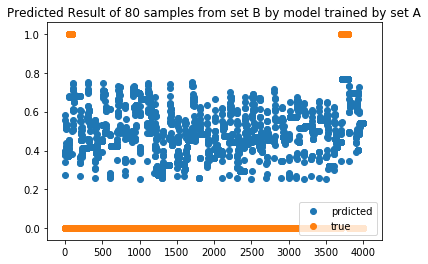

In [26]:
plt.figure(1)
plt.scatter(list(range(len(label))), res, )
plt.scatter(list(range(len(label))), label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 80 samples from set B by model trained by set A')

In [29]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']
bst2 = xgb.Booster(model_file='xgb_2019-07-22-09-58-17.model') 

def test(csv, bst2):
    #csv = 'p108230.psv'
    cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]

    encoder = LabelEncoder()
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                     'custom_resp', 'custom_hco3', 'custom_ph',
                     'custom_bun', 'custom_BC_ratio',
                     'custom_calcium', 'custom_chloride', 'custom_creatinine',
                     'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                     'custom_hct', 'custom_hgb', 'custom_wbc', 
                      'custom_platelets', 'Gender', 'Unit', 'HospAdmTime']

    for c in tqdm(custom):
        cur_train[c][0:len(cur_train[c])] = encoder.fit_transform(cur_train[c][0:len(cur_train[c])])

    encoded_x = None
    for f in custom:
        #print(f)
        enc = OneHotEncoder()
        fff = cur_train[f].to_numpy().reshape(cur_train[f].shape[0], 1)
        enc.fit(fff)
        array = enc.transform(fff).toarray()
        if encoded_x is None:
            encoded_x = array
        else:
            encoded_x = np.concatenate((encoded_x, array), axis=1)


    dtest = xgb.DMatrix(cur_train[custom])
    preds = bst2.predict(dtest)
    #print(preds)
    return preds, cur_train['SepsisLabel']

res = None
label = []
for i in tqdm(range(102,500,5)):
    R,l = test(f'p000{i}.psv', bst2)
    if res is None:
        res = R
    else:
        res = np.concatenate((res, R))
    label += list(l)
    
    
    
    
    


  0%|          | 0/80 [00:00<?, ?it/s]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.22it/s]

Data processed!



  1%|▏         | 1/80 [00:02<02:48,  2.13s/it]]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  4%|▍         | 3/80 [00:06<02:39,  2.07s/it]]


Begin!
Data processed!


  5%|▌         | 4/80 [00:08<02:35,  2.04s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.43it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  8%|▊         | 6/80 [00:12<02:30,  2.04s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.72it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 10%|█         | 8/80 [00:16<02:25,  2.01s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.00it/s]

Data processed!



 11%|█▏        | 9/80 [00:18<02:28,  2.10s/it]]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.37it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 15%|█▌        | 12/80 [00:24<02:18,  2.03s/it]

Begin!



  4%|▍         | 1/23 [00:00<00:02,  9.78it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 20%|██        | 16/80 [00:32<02:07,  1.99s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.97it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 24%|██▍       | 19/80 [00:38<01:55,  1.89s/it]

Begin!



 25%|██▌       | 20/80 [00:39<01:52,  1.88s/it]

Data processed!
Begin!



 26%|██▋       | 21/80 [00:41<01:50,  1.87s/it]

Data processed!
Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.93it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 30%|███       | 24/80 [00:47<01:44,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.07it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


 36%|███▋      | 29/80 [00:56<01:34,  1.86s/it]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 42%|████▎     | 34/80 [01:06<01:25,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.94it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 52%|█████▎    | 42/80 [01:20<01:11,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.62it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  9%|▊         | 2/23 [00:00<00:01, 15.65it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  9%|▊         | 2/23 [00:00<00:01, 14.40it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 64%|██████▍   | 51/80 [01:37<00:53,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.49it/s]

Data processed!



 65%|██████▌   | 52/80 [01:39<00:52,  1.88s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.94it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 70%|███████   | 56/80 [01:47<00:44,  1.85s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.46it/s]

Data processed!



 71%|███████▏  | 57/80 [01:48<00:42,  1.86s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.15it/s]

Data processed!



 72%|███████▎  | 58/80 [01:50<00:41,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 12.92it/s]


Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 75%|███████▌  | 60/80 [01:55<00:40,  2.01s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 12.77it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 78%|███████▊  | 62/80 [01:59<00:36,  2.05s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.14it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 80%|████████  | 64/80 [02:03<00:32,  2.04s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.13it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 82%|████████▎ | 66/80 [02:07<00:28,  2.03s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.29it/s]

Data processed!



 84%|████████▍ | 67/80 [02:09<00:26,  2.02s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 13.36it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 86%|████████▋ | 69/80 [02:13<00:22,  2.06s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.14it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


 89%|████████▉ | 71/80 [02:17<00:18,  2.00s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 14.70it/s]


Data processed!


 90%|█████████ | 72/80 [02:19<00:15,  1.98s/it]

Begin!



  0%|          | 0/23 [00:00<?, ?it/s]

Data processed!
Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]


Begin!
Data processed!


  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



 96%|█████████▋| 77/80 [02:28<00:05,  1.88s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.40it/s]

Data processed!



 98%|█████████▊| 78/80 [02:30<00:03,  1.87s/it]

Begin!



  9%|▊         | 2/23 [00:00<00:01, 15.31it/s]

Data processed!



  0%|          | 0/23 [00:00<?, ?it/s]

Begin!
Data processed!



100%|██████████| 80/80 [02:34<00:00,  1.88s/it]


Text(0.5, 1.0, 'Predicted Result of 80 samples from set A by model trained by set A')

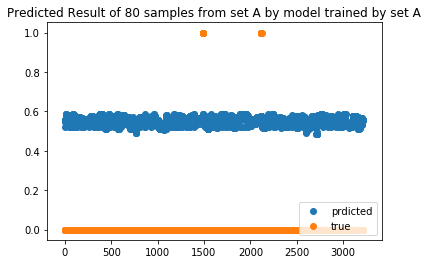

In [30]:
plt.figure(1)
plt.scatter(list(range(len(label))), res, )
plt.scatter(list(range(len(label))), label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 80 samples from set A by model trained by set A')

### Time-Series-XGBOOST

In [4]:
%reload_ext rpy2.ipython

In [5]:
%R print("Hi from R")

[1] "Hi from R"


array(['Hi from R'], dtype='<U9')

In [6]:
#%load_ext rpy2.ipython


%R
print("Hi from R")
print("Hi from R")

Hi from R
Hi from R


In [7]:
import rpy2
print(rpy2.__version__)

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
#forecastxgb = importr('forecastxgb')
# import R's "utils" package
utils = importr('utils')

3.0.5


In [8]:
import rpy2.robjects as robjects
%reload_ext rpy2.ipython

In [12]:
%%R

#version
library(forecastxgb)
model <- xgbar(gas)
summary(model)


Importance of features in the xgboost model:
     Feature         Gain        Cover   Frequency
 1:    lag12 5.096008e-01 0.1166706236 0.068676717
 2:    lag11 2.795777e-01 0.0676836024 0.041876047
 3:    lag13 1.043150e-01 0.0243945869 0.025125628
 4:    lag24 7.806913e-02 0.1071937322 0.058626466
 5:     lag1 1.586491e-02 0.1826329535 0.185929648
 6:    lag23 5.628797e-03 0.0405389364 0.040201005
 7:     lag9 2.609947e-03 0.0850546059 0.061976549
 8:     lag2 6.965430e-04 0.0543091168 0.068676717
 9:    lag14 6.023859e-04 0.0474240266 0.030150754
10:    lag10 5.511717e-04 0.0367798354 0.045226131
11:     lag6 3.845375e-04 0.0114355809 0.030150754
12:     lag4 2.302062e-04 0.0073401393 0.033500838
13:    lag22 2.248839e-04 0.0096549541 0.018425461
14:    lag16 2.050286e-04 0.0069246597 0.011725293
15:    lag21 2.019113e-04 0.0170346629 0.025125628
16:    lag18 1.934416e-04 0.0197847420 0.026800670
17:     lag3 1.830137e-04 0.0202002216 0.036850921
18:     lag5 1.522916e-04 0.02427587

In [14]:
%%R
gas
model.

W0722 09:37:48.566647 4410422720 callbacks.py:116] R[write to console]: Error in model.predict() : could not find function "model.predict"
Calls: <Anonymous> -> <Anonymous> -> withVisible




Error in model.predict() : could not find function "model.predict"
Calls: <Anonymous> -> <Anonymous> -> withVisible


### LSTM

#### train

In [7]:
with open('./data/AB100.pkl', 'rb') as file:
    meta_data = pickle.load(file)

In [8]:
custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']

# custom = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
#        'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
#        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
#        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
#        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
#        'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
#        'HospAdmTime', 'ICULOS']

train_data = meta_data[custom]
train_label = np.array(meta_data['SepsisLabel'])[:int(len(meta_data)//100) * 100]

encoder = {}
custom_ = copy.deepcopy(custom)
custom_.remove('HospAdmTime')
custom_.remove('ICULOS')

for c in tqdm(custom_):
    encoder[c] = LabelEncoder()
    train_data[c][0:len(train_data[c])] = encoder[c].fit_transform(train_data[c][0:len(train_data[c])])
        
train_data = np.array(train_data)[:int(len(meta_data)//100) * 100]

#scaler = MinMaxScaler(feature_range=(0, 1))
#train_data = scaler.fit_transform(train_data)

train_label = np.asarray(train_label).astype('float32')

# with open('./data/train_data.pkl', 'wb') as file:
#     pickle.dump(train_data,file)


100%|██████████| 22/22 [00:37<00:00,  1.05it/s]


In [8]:
with open('./data/train_data.pkl', 'wb') as file:
    pickle.dump(train_data,file)
with open('./data/train_label.pkl', 'wb') as file:
    pickle.dump(train_label,file)


reshape input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [9]:
# keep the same shuffle
#random.seed(7)
def sample_shuffle(train, label, rate_01):
    normal = []
    abnormal = []
    
    for i in range(len(train)):
        if sum(label[i]) == 0: 
            normal.append(i)
        else:
            abnormal.append(i)
            
    random.shuffle(normal)
    normal = normal[:len(abnormal * rate_01)] # sample to same for 1 and 0 training case
    #normal = normal[:int(len(normal) * 0.1)]
    #abnormal = abnormal[:int(len(abnormal) * 0.1)]
    index = normal + abnormal
    #print(len(normal), len(abnormal), len(index))
    random.shuffle(index) # shuffle
    
    return index
    
rate_01 = 2 # 1:1 for normal and abnormal 
            # 2 for 2 : 1 
train_size = len(meta_data)
num_features = len(custom)
patient_length = 100

# resize to [samples, time steps, features]
train_data = train_data.reshape(int(train_size/patient_length), patient_length, num_features)
train_label = train_label.reshape(int(train_size/patient_length),patient_length)

# sample and shuffle
index = sample_shuffle(train_data, train_label, rate_01)
train_data_ss, train_label_ss  = train_data[index], train_label[index]

# split
val_size = int(len(train_data_ss) * 0.1)
test_size = int(len(train_data_ss) * 0.1)

x_train = train_data_ss[val_size + test_size:]
x_val = train_data_ss[:test_size]
x_test = train_data_ss[test_size:val_size + test_size]

y_train = train_label_ss[val_size + test_size:]
y_val = train_label_ss[:test_size]
y_test = train_label_ss[test_size:val_size + test_size]



自定义metrics and loss

ref https://stackoverflow.com/questions/33859864/how-to-create-custom-objective-function-in-keras

https://keras.io/backend/#backend

In [188]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

def kw_loss():
# def kw_loss(y_true, y_pred, threshold = 0.8):
    
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     y_pred_f = [K.constant(1) if K.greater(y,threshold) is True else K.constant(0) for y in y_pred_f]
    
#     print(K.int_shape(y_pred_f))
#     loss = K.constant(0)
#     if tf.math.equal(K.sum(y_true_f),0) is True:
#         healthy = [K.constant(0) if K.equal(y_true_f[i],y_pred_f[i]) else K.constant(-0.1) for i in range(100)]
#         loss = K.sum(healthy)    

#     else:
#         sick = [K.constant(-0.1) for _ in range(K.int_shape(y_pred_f))]
#         t_optimal = y_true_f.index(1)
#         for i in range(len(y_pred_f)):
#             gap = t_optimal - i
#             if K.greater_equal(gap,7):
#                 sick[i] = K.constant(-0.1) if K.not_equal(y_true_f[i],y_pred_f[i]) else K.constant(0)
#             elif K.greater_equal(gap,0) and K.less(gap,7):
#                 sick[i] = K.constant(-0.1) + gap * 11. / 70.
#             elif K.less(gap,0) and K.greater_equal(gap,-9):
#                 sick[i] = K.constant(1 + gap * 10 / 9) if K.equal(y_true_f[i],y_pred_f[i]) else gap * 2/9
#             else:
#                 continue
#         loss = K.sum(sick)
        
#     return loss

# #@autograph.convert()
# def kw_loss(y_true, y_pred):
# #     y_true_ = K.flatten(y_true)
# #     y_pred_ = K.flatten(y_pred)
    
#     y_true_ = y_true
#     y_pred_ = y_pred
    
#     t = 0.8
#     y_pred_t = []
#     for y_p in y_pred_:
#         if y_p > t:
#             y_pred_t.append(1)
#         else:
#             y_pred_t.append(0)
#     loss = 0
#     healthy = []
#     if sum(y_true_) == 0:
#         for i in range(len(y_pred_t)):
#             if y_true_[i] == y_pred_t[i]:
#                 healthy.append(0)
#             else:
#                 healthy.append(-0.1)
#         loss = sum(healthy)    

#     else:
#         sick = [0 for _ in range(len(y_pred_t))]
#         t_optimal = y_true_.index(1)
#         gap = t_optimal - i
#         for i in range(len(y_pred_t)):
#             if gap >= 7:
#                 sick[i] = -0.1 if y_true_[i] != y_pred_t[i] else 0
#             elif 0 <= gap < 7:
#                 sick[i] = -0.1 + gap * 11 / 70
#             elif 0 > gap >= -9:
#                 sick[i] = (1 + gap * 10 / 9) if y_true_[i] == y_pred_t[i] else gap * 2/9
#             else:
#                 continue
#         loss = sum(sick)
#     print(type(loss), loss)
#     return loss

# def kw_loss(y_true,y_pred):
#     with tf.Graph().as_default():
        
#         with tf.Session() as sess:
#             loss = tf.placeholder(tf.int32)
#             loss = kw_loss_fn(y_true, y_pred).eval()
#         return loss
        

        
# def kw_loss(y_true,y_pred):
#     with tf.Session() as sess:
#         #print(type(y_true))
#         #print(sess.run(y_pred))
#         #print(y_pred.shape[1])
#         #print(y_true.shape)
#         #y_true=K.flatten(y_true)
#        # y_true=K.flatten(y_true)
#         #print(y_true.shape)
#         y_true = tf.reshape(y_true, shape = [-1,y_pred.shape[1]])
#         y_pred = tf.reshape(y_pred, shape = [-1,y_pred.shape[1]])
#         print(y_true.shape)
#         #print(y_true.shape)
#         #print((y_pred))
#        # y_true1 = tf.placeholder(tf.float64)
#         loss = tf.Variable(tf.zeros([y_true.shape[-1],1]))
#         for i in range(y_true.shape[0]):
#             y_true1=tf.map_fn(lambda x:1.0 if tf.greater(x,0.8) is True else 0.0,y_true[i])
#             #y_pred1 = tf.placeholder(tf.float64)
#             y_pred1=tf.map_fn(lambda x:1.0 if tf.greater(x,0.8) is True else 0.0,y_pred[i])

#             print(sess.run(y_true1))
#             loss=tf.constant(0)
#             if tf.reduce_sum(y_pred1)==0:
#                 condi=tf.cast(tf.equal(y_true1,y_pred1),tf.float32) # 注意tf.cast的使用，将bool转为tf.float
#                 print(sess.run(condi))
#                 healthy=tf.map_fn(lambda x:1.0 if tf.equal(x,0.0) is True else -1.0,sess.run(condi))
#                 print(sess.run(healthy))
#                 loss=tf.reduce_sum(healthy)
#     #             print(sess.run(loss))
#     #             print('ppp')
#             elif tf.reduce_sum(y_pred1)!=1:
#                 sick=tf.zeros((1, 100))
#     #             print(sess.run(sick))

#                 pos = sess.run(tf.where(tf.equal(y_true1,1.0)))
#                 print(pos)
#                 try:
#                     t_optimal=pos[0]
#                 except:
#                     t_optimal=tf.constant(100)

#                 res=tf.constant(0)
#                 for i in range(10):#y_pred1.shape[0]
#                     print(i)
#                     gap=t_optimal-i
#                     if sess.run(tf.greater(gap,7)):
#                         condi=tf.equal(y_true1[i],y_pred1[i])
#                         if not sess.run(condi):
#                             temp=tf.constant(-0.1)
#                         else:
#                             temp=tf.constant(0.0)

#                     elif sess.run(tf.greater(gap,0)):
#                         temp= tf.constant(-0.1 + gap * 11 / 70)

#                     elif sess.run(tf.greater(gap,-9)):
#                         condi=tf.equal(y_true1[i],y_pred1[i])
#                         if sess.run(condi):
#                             temp=tf.constant(1 + gap * 10 / 9)
#                         else:
#                             temp=tf.constant(gap * 2/9)
#                     else:
#                         continue
#                     res = tf.reduce_sum([res, temp])
#             loss[i] = res
#     return tf.constant(loss)

# def kw_loss(y_true, y_pred):
#         return K.mean(tf.nn.weighted_cross_entropy_with_logits(
#             y_true,
#             y_pred,
#             1,
#             name=None
#         ), axis=-1)
    return 1
def w_binary_crossentropy(y_true, y_pred):
        return K.mean(tf.nn.weighted_cross_entropy_with_logits(
            y_true,
            y_pred,
            1,
            name=None
        ), axis=-1)
def weight_loss(weights):
    def w_binary_crossentropy(y_true, y_pred):
        return K.mean(tf.nn.weighted_cross_entropy_with_logits(
            y_true,
            y_pred,
            weights,
            name=None
        ), axis=-1)
    return w_binary_crossentropy


双向LSTM

In [ ]:
model = models.Sequential()
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=50,return_sequences=True), input_shape=(1,patient_length,num_features)))
# model.add(layers.Dense(200,activation='tanh'))
# model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(patient_length, activation='sigmoid')))

#model.add(layers.Dense(patient_length,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam')
model.compile(loss='mse', optimizer='adam', metrics=['crossentropy'])

单向LSTM

In [189]:
model = models.Sequential()
#model.add(Masking(mask_value= -1,input_shape=(patient_length, num_features)))
model.add(BatchNormalization())
model.add(LSTM(100, input_shape=(patient_length,num_features)))
# model.add(layers.Dense(128,activation='tanh'))
# model.add(Dropout(0.5))
model.add(layers.Dense(patient_length,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam')
#model_loss = kw_loss(threshold=0.8)
kw_loss = weight_loss(weights=1)
model.compile(loss=kw_loss, optimizer='adam', metrics=[fmeasure])


In [190]:
des = f'newAB with no dense 01_rate=2 kw_loss weights=1'
now = int(round(time.time()*1000))
NOW = time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(now/1000))

history = model.fit(x_train,
                    y_train,
                    epochs=30, # todo
                    batch_size=16, # todo
                    validation_data=(x_val,y_val))
plt.figure(1)
plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.savefig(f'./result/{NOW}_loss.png')

plt.figure(2)
plt.plot(history.history[ 'fmeasure' ])
plt.plot(history.history[ 'val_fmeasure' ])
plt.savefig(f'./result/{NOW}_fmeasure.png')
# save model
model.save(f'./model/LSTM_{NOW}.h5')

# save encoder
output = open(f'./model/Encoder_{NOW}.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

# document
with open('test_doc.txt', 'r') as fr:
        lines = fr.readlines()
with open('test_doc.txt', 'w') as f:
    for line in lines:
        # 对每一行进行操作
        f.write(f'{line}') # 写入你想要的东西
    f.write(f'\n')
    f.write(f'{NOW} | {des}')
print(NOW)

Train on 5897 samples, validate on 737 samples
Epoch 1/30


KeyboardInterrupt: 

#### test

In [192]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_sao2', 'custom_ph',
                  'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS','SepsisLabel']
NOW_test = '2019-07-31-17-42-55'
def test(csv, encoder):
    model = load_model(f'./model/LSTM_{NOW_test}.h5', custom_objects={'w_binary_crossentropy':w_binary_crossentropy,'fmeasure':fmeasure})
    cur_train = pd.read_csv('./data/trainingB/' + csv, sep='|')
    org_length = len(cur_train)
    cur_train = cur_train.fillna(method='pad')
    cur_train = feature_engineer(cur_train)[feature_to_use]
    
    
    
    custom = ['custom_age', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_hco3', 'custom_ph',
                  'custom_bun', 'custom_BC_ratio',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine',
                 'custom_glucose', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_hct', 'custom_hgb', 'custom_wbc', 
                  'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']


#     custom = ['custom_age', 'custom_hr',  'custom_temp', 
#                  'custom_resp', 'custom_hco3',
#                   'custom_bun', 'custom_BC_ratio',
#                  'custom_chloride', 'custom_creatinine',
#                  'custom_glucose', 'custom_potassium',
#                  'custom_hct', 'custom_hgb', 'custom_wbc', 
#                   'custom_platelets', 'Gender', 'Unit', 'HospAdmTime', 'ICULOS']
    
    custom_ = copy.deepcopy(custom)
    custom_.remove('HospAdmTime')
    custom_.remove('ICULOS')
    
    encoder_ = LabelEncoder()
    for c in tqdm(custom_):
        cur_train[c][0:len(cur_train[c])] = encoder[c].transform(cur_train[c][0:len(cur_train[c])])
    
    dtest = np.array(cur_train[custom])
    dtest = dtest.reshape(-1,100,len(custom))
    
    preds = model.predict(dtest)
    
    return preds, cur_train['SepsisLabel'], org_length

res = None
org_label = []

test_dir = listdir('./data/trainingB/')
random.shuffle(test_dir)
test_candidate = test_dir[:4]
test_candidate += patient_b[:3]
random.shuffle(test_candidate)
org_length = []

pkl_file = open(f'./model/Encoder_{NOW_test}.pkl', 'rb')
encoder = pickle.load(pkl_file) 
pkl_file.close()
    
for i in tqdm(test_candidate):
    R,l,org_l = test(i, encoder)
    if res is None:
        res = list(R[0])
    else:
        res += list(R[0])
    org_label += list(l)
    org_length.append(org_l)
    




  0%|          | 0/7 [00:00<?, ?it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  5%|▍         | 1/22 [00:00<00:10,  1.94it/s]


  9%|▉         | 2/22 [00:01<00:10,  1.90it/s]


 14%|█▎        | 3/22 [00:01<00:10,  1.83it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Predicted Result of 10 samples from set B by model trained by set A')

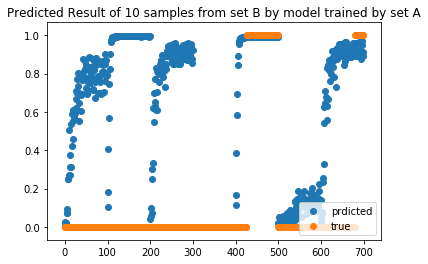

In [160]:
plt.figure(1)
plt.scatter(list(range(len(org_label))), res )
plt.scatter(list(range(len(org_label))), org_label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 10 samples from set B by model trained by set A')

In [163]:
from evaluate_sepsis_score import *
import os, zipfile
Res = res
gap = max(Res) - 0 + 0.01
Res = (Res / gap)
Res = [abs(x) for x in Res]
threshold = 0.8
prefix_length = [org_length[0]]
for i in range(1, len(org_length)):
    prefix_length.append(org_length[i] + prefix_length[i-1])
    
def fix_100(res, label, org_length, t):
    """
    input: 
            res label are given by predict
            org_length is the original length of each patient
            t is threshold
    output:
            fixed probabilities, original labels and predictions of original length,
            also processed by threshold
            
    """
    l = 100 # fixed length of each patient
    Res = []
    Label = []
    Predict = []
    for i in range(len(org_length)):
        tmp_res = res[i*l:(i+1)*l]
        tmp_label = label[i*l:(i+1)*l]
        if org_length[i] <= l:
            tmp_res = tmp_res[:org_length[i]]
            tmp_label = tmp_label[:org_length[i]]
        else:
            last = tmp_res[-1]
            tmp_res += [last for _ in range(org_length[i] - l)]
            tmp_label += [tmp_label[-1] for _ in range(org_length[i] - l)]
        tmp_predict = [1 for _ in range(len(tmp_res))]
        for r in range(len(tmp_res)):
            if tmp_res[r] < t:
                tmp_predict[r] = 0
            else:    
                r += 1
                while r < len(tmp_res):
                    tmp_res[r] = tmp_res[r - 1]
                    r += 1
                    
                break
                
        Predict += tmp_predict
        Res += tmp_res
        Label += tmp_label
    return Res, Label, Predict 
        
Res, Label, predicts = fix_100(Res, org_label, org_length, threshold)

with open('labels.txt', 'w') as f:
    f.write('SepsisLabel\n')
    if len(Label) != 0:
        for l in Label:
            f.write('%d\n' % l)
            
with open('predictions.txt', 'w') as f:
    f.write('PredictedProbability|PredictedLabel\n')
    if len(Res) != 0:
        for (s, l) in zip(Res, predicts):
            f.write('%g|%d\n' % (s, l))
        
with zipfile.ZipFile('labels.zip', 'w') as z:
    z.write('labels.txt')
with zipfile.ZipFile('predictions.zip', 'w') as z:
    z.write('predictions.txt')    

!python3 evaluate_sepsis_score.py labels.zip predictions.zip


AUROC|AUPRC|Accuracy|F-measure|Utility
0.4966281310211945|0.04899267399267399|0.35064935064935066|0.10256410256410256|0.2057142857142859
AUROC|AUPRC|Accuracy|F-measure|Utility
0.4966281310211945|0.04899267399267399|0.35064935064935066|0.10256410256410256|0.2057142857142859


Text(0.5, 1.0, 'Predicted Result of 10 samples from set B by model trained by set A')

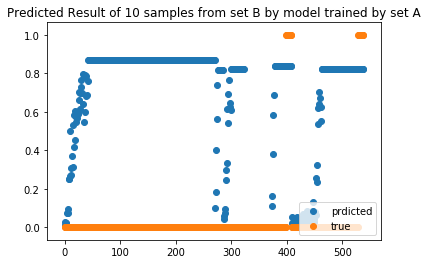

In [164]:
#plt.figure(1)
plt.scatter(list(range(len(Label))), Res)
plt.scatter(list(range(len(Label))), Label)
plt.legend(['prdicted','true'], loc = 'lower right')
plt.title('Predicted Result of 10 samples from set B by model trained by set A')

### Random Forest

In [ ]:

data=[]
traffic_feature=[]
traffic_target=[]
csv_file = csv.reader(open('packSize_all.csv'))
for content in csv_file:
    content=list(map(float,content))
    if len(content)!=0:
        data.append(content)
        traffic_feature.append(content[0:6])
        traffic_target.append(content[-1])
print('data=',data)
print('traffic_feature=',traffic_feature)
print('traffic_target=',traffic_target)
scaler = StandardScaler() # 标准化转换
scaler.fit(traffic_feature)  # 训练标准化对象
traffic_feature= scaler.transform(traffic_feature)   # 转换数据集
feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
# clf = RandomForestClassifier(criterion='entropy')
clf = RandomForestClassifier()
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))
